In [21]:
#pip install prophet
#pip install pathos

In [7]:
import sys
sys.path.append(str('/home/jupyter/SearchForecasting/'))
from configparser import ConfigParser

from repo.MyConfigParser import MyConfigParser

from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts
from repo.FileGenerator import *

In [8]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/SearchForecasting/UK/June 2024 Update 2/v2 config ups uk.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)

region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

training_query = config_dict["PROPHETSETTING"]["training_query"]
_input = config_dict["PROPHETSETTING"]["input"]
_output = config_dict["PROPHETSETTING"]["output"]

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]


today = datetime.date.today().strftime("%m.%d.%Y") #'03.10.2023' #
print(today)
base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]

06.06.2024


In [9]:
daily_df = GetBQData(training_query, _input, _output)

df = daily_df.copy()
df = df.groupby(['market', 'account_type', 'funnel', 'ds']).sum().reset_index()

# log Transformation
# df['cost'] = np.log(df['cost'])
# df.loc[(df['cost'] < 0) | (np.isinf(df['cost'])), 'cost'] = 0

df.ds = pd.to_datetime(df.ds)
df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]
df
#Combine Tablet and desktop together 
#For November data, use the daily average for that year to fill the missing data

/home/jupyter/SearchForecasting/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)


,market,account_type,funnel,ds,region,X,y
0,UK,Desktop,-,2022-01-01,EMEA,451.76,58.0
1,UK,Desktop,-,2022-01-02,EMEA,748.38,119.0
2,UK,Desktop,-,2022-01-03,EMEA,1526.97,428.0
3,UK,Desktop,-,2022-01-04,EMEA,3765.39,1521.0
4,UK,Desktop,-,2022-01-05,EMEA,3341.83,1346.0
...,...,...,...,...,...,...,...
1637,UK,Mobile & Tablet,-,2024-04-26,EMEA,175.69,25.0
1638,UK,Mobile & Tablet,-,2024-04-27,EMEA,148.09,12.0
1639,UK,Mobile & Tablet,-,2024-04-28,EMEA,209.39,26.0
1640,UK,Mobile & Tablet,-,2024-04-29,EMEA,279.72,38.0


In [10]:
# df = daily_df.copy()
# df.market = 'US'
# df = df.groupby(['region', 'market', 'account_type', 'funnel', 'ds']).sum().reset_index()

# # log Transformation
# # df['cost'] = np.log(df['cost'])
# # df.loc[(df['cost'] < 0) | (np.isinf(df['cost'])), 'cost'] = 0

# df.ds = pd.to_datetime(df.ds)

# df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]
# df = df[df.ds < cutoff_month]
# # remove inactive days
# df.drop(df[((df['ds'] >= '2021-08-01')&(df['ds'] <= '2021-10-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].index,
#        axis = 0, inplace = True)
# df.drop(df[((df['ds'] >= '2019-03-01')&(df['ds'] <= '2019-08-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].index,
#        axis = 0, inplace = True)

# df.drop(df[((df['ds'] >= '2021-07-01')&(df['ds'] <= '2021-10-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Generic'))].index,
#        axis = 0, inplace = True)

# # add regressors
# df['anomaly_2021'] = df['ds'].apply(lambda x: 1 if (x >= datetime.datetime(2021,8,1))\
#                                      & (x <= datetime.datetime(2021,10,31)) else 0)
# df['covid_year_dummy'] = 0
# df.loc[(df['ds'] >= '2020-01-01') & (df['ds'] <= '2020-12-31'), 'Covid_Year_Dummy'] = 1

# df['weekday_or_weekend'] = df['ds'].apply(lambda x: 1 if x.dayofweek > 4 else 0)

# # set cap and floor for log regression
# df['Month of Ds'] = df['ds'].dt.month_name()

# df['floor'] = 0

# boundary_df = pd.read_csv('Floor Cap Setting 2022.csv')
# boundary_df.rename(columns = {'Account Type': 'account_type', 'Funnel':'funnel'}, inplace = True)
# boundary_df.drop(['Market'], axis = 1, inplace = True)

# df = pd.merge(df, boundary_df, on = ['account_type', 'funnel'])
# df['cap'] = df.ROAS * df.X / df.AOV
# df.loc[df.cap == 0, 'cap'] = df.cap.max()

# # df.to_csv(f'Daily Data {today}.csv')
# df.tail()

#del df

In [11]:
df['ds'] = pd.to_datetime(df['ds'])

# Filter the data for the year 2022
df_2022 = df[df['ds'].dt.year == 2022]

# Get the unique account types
account_types = df['account_type'].unique()

# Initialize an empty dataframe to store the filled November data
filled_november_data = pd.DataFrame()

# Loop through the unique account types
for account_type in account_types:
    # Filter the data for the current account type
    df_2022_account_type = df_2022[df_2022['account_type'] == account_type]

    # Group the data by day of the month and calculate the mean for X and y columns
    daily_avg_2022 = df_2022_account_type.groupby(df_2022_account_type['ds'].dt.day)[['X', 'y']].mean()

    # Create a new dataframe for November 2022 with date range from 1st to 30th
    november_2022 = pd.date_range(start='2022-11-01', end='2022-11-30', freq='D')
    november_df = pd.DataFrame(november_2022, columns=['ds'])

    # Merge the daily averages with the November dataframe
    filled_november_df = november_df.merge(daily_avg_2022, left_on=november_df['ds'].dt.day, right_index=True)

    # Update the 'ds' column with the correct dates for November 2022
    filled_november_df['ds'] = november_2022

    # Forward-fill the missing values in region, market, funnel, and account_type columns
    filled_november_df[['region', 'market', 'funnel']] = df_2022_account_type[['region', 'market', 'funnel']].fillna(method='ffill').iloc[-1]
    filled_november_df['account_type'] = account_type

    # Append the filled November data for the current account type to the filled_november_data dataframe
    filled_november_data = pd.concat([filled_november_data, filled_november_df], ignore_index=True)

# Append the filled November data to the original dataframe
df_filled = pd.concat([df, filled_november_data], ignore_index=True).drop(columns='key_0')

/var/tmp/ipykernel_5927/3220856806.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_november_df[['region', 'market', 'funnel']] = df_2022_account_type[['region', 'market', 'funnel']].fillna(method='ffill').iloc[-1]
/var/tmp/ipykernel_5927/3220856806.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filled_november_df[['region', 'market', 'funnel']] = df_2022_account_type[['region', 'market', 'funnel']].fillna(method='ffill').iloc[-1]
/var/tmp/ipykernel_5927/3220856806.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

In [12]:
#missing_data_df = pd.DataFrame(missing_data)
#df = pd.concat([df, missing_data_df], ignore_index=True)

In [13]:
df_filled['weekday_or_weekend'] = df_filled['ds'].apply(lambda x: 1 if x.dayofweek > 4 else 0)

# set cap and floor for log regression
df_filled['Month of Ds'] = df_filled['ds'].dt.month_name()

df_filled['floor'] = 0

boundary_df = pd.read_csv(base_path + 'UK Floor Cap Setting Feb 2024.csv')
boundary_df.rename(columns = {'Account Type': 'account_type', 'Funnel':'funnel'}, inplace = True)
boundary_df.drop(['Market'], axis = 1, inplace = True)

df_filled = pd.merge(df_filled, boundary_df, on = ['account_type', 'funnel'])
df_filled['cap'] = df_filled.ROAS * df_filled.X / df_filled.AOV
df_filled.loc[df_filled.cap == 0, 'cap'] = df_filled.cap.max()

df_filled.to_csv(f'Daily Data {today}.csv')

df_filled.to_csv(base_path + 'df_filled.csv')

df_filled

,market,account_type,funnel,ds,region,X,y,weekday_or_weekend,Month of Ds,floor,AOV,ROAS,cap
0,UK,Desktop,-,2022-01-01,EMEA,451.760000,58.000000,1,January,0,23.28,1.98,38.422887
1,UK,Desktop,-,2022-01-02,EMEA,748.380000,119.000000,1,January,0,23.28,1.98,63.650876
2,UK,Desktop,-,2022-01-03,EMEA,1526.970000,428.000000,0,January,0,23.28,1.98,129.871160
3,UK,Desktop,-,2022-01-04,EMEA,3765.390000,1521.000000,0,January,0,23.28,1.98,320.252242
4,UK,Desktop,-,2022-01-05,EMEA,3341.830000,1346.000000,0,January,0,23.28,1.98,284.227809
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,UK,Mobile & Tablet,-,2022-11-26,EMEA,303.719091,51.909091,1,November,0,21.90,0.85,11.788184
1698,UK,Mobile & Tablet,-,2022-11-27,EMEA,304.482727,62.000000,1,November,0,21.90,0.85,11.817823
1699,UK,Mobile & Tablet,-,2022-11-28,EMEA,304.740909,65.818182,0,November,0,21.90,0.85,11.827844
1700,UK,Mobile & Tablet,-,2022-11-29,EMEA,315.543000,67.100000,0,November,0,21.90,0.85,12.247103


# Analytical File Generator

In [14]:
generator = AnalyticalFileGenerator(config_dict)
analytical_file_df = generator.generate()
analytical_file_df = pd.merge(analytical_file_df, boundary_df, on = ['account_type', 'funnel'])
analytical_file_df.to_csv(analytical_file_path)

/home/jupyter/SearchForecasting/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)


In [30]:
[col for col in analytical_file_df.columns if 'UK' in col]

['UK_Desktop_-_Apr_2024',
 'UK_Desktop_-_Aug_2024',
 'UK_Desktop_-_Dec_2024',
 'UK_Desktop_-_Jul_2024',
 'UK_Desktop_-_Jun_2024',
 'UK_Desktop_-_May_2024',
 'UK_Desktop_-_Nov_2024',
 'UK_Desktop_-_Oct_2024',
 'UK_Desktop_-_Sep_2024',
 'UK_Mobile_&_Tablet_-_Apr_2024',
 'UK_Mobile_&_Tablet_-_Aug_2024',
 'UK_Mobile_&_Tablet_-_Dec_2024',
 'UK_Mobile_&_Tablet_-_Jul_2024',
 'UK_Mobile_&_Tablet_-_Jun_2024',
 'UK_Mobile_&_Tablet_-_May_2024',
 'UK_Mobile_&_Tablet_-_Nov_2024',
 'UK_Mobile_&_Tablet_-_Oct_2024',
 'UK_Mobile_&_Tablet_-_Sep_2024']

In [23]:
cuts_df = pd.read_csv(base_path + region + ' Breakdown Feb.csv')#.drop('Unnamed: 0', axis = 1)
cuts_df['periods'] = periods
cuts_df['periods_for_acc_cal'] = 183
cuts_df['cutoff_month'] = cutoff_month
# cuts_df.account_type = 'unified'
cuts_df.input_mode = 'multiplicative'
query_item_list = [query_item for query_item in [config_dict["CLIENTINFO"]["breakdown1"], \
                             config_dict["CLIENTINFO"]["breakdown2"], \
                             config_dict["CLIENTINFO"]["breakdown3"], \
                             config_dict["CLIENTINFO"]["breakdown4"]]
                             if query_item != None]
#cuts_df.drop(columns='Unnamed: 0', inplace=True)
cuts_df

,market,account_type,funnel,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,...,anomaly_2021,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,MAPE,period_AE,periods,cutoff_month
0,UK,Desktop,-,183,0.050,10.00,1.00,multiplicative,multiplicative,additive,...,na,na,na,na,na,linear,9.71,1.04,251.0,2024-04-25
1,UK,Mobile & Tablet,-,183,0.001,0.01,0.01,additive,multiplicative,na,...,na,na,na,na,na,logistic,30.00,5.46,251.0,2024-04-25


# Accuracy Calculator

generic_df = pd.read_csv("record_df 2023-08-16 18:16:20 best result.csv")
generic_df

In [24]:
# %load_ext autoreload
# %autoreload 2


calculator = AccuracyCalculator()
accuracy_df = calculator.CalculateAccuracy(cuts_df, df_filled, query_item_list)
# calculator.SaveFile()

16:14:52 - cmdstanpy - INFO - Chain [1] start processing
16:14:52 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/SearchForecasting/repo/Accuracy.py:267: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.monthly_acc_df_temp = pd.concat([self.monthly_acc_df_temp, monthly_acc_df], ignore_index=True)
16:14:52 - cmdstanpy - INFO - Chain [1] start processing
16:14:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.8 Period MAE: 19.189999999999998
It's underpredicted.
Monthly Error: 87.65 Period MAE: 1.69


In [25]:
accuracy_df.to_csv(base_path + 'test_Acc_feb.csv')

In [26]:
# This is to convert error metrics to accuracy. Note the column names won't change
100-accuracy_df.groupby(['account_type']).mean(numeric_only=1)

,Actual,Forecast,Percentage Error,MAPE,Forecast Period MAE
account_type,,,,,
Desktop,-18288.857143,-14760.507143,81.798571,78.20,80.81
Mobile & Tablet,-899.428571,-882.528571,100.948571,12.35,98.31


In [15]:
100-accuracy_df.groupby(['market']).mean(numeric_only=1)

,Actual,Forecast,Percentage Error,MAPE,Forecast Period MAE
market,,,,,
UK,-9594.142857,-9665.722143,94.370714,83.475,91.345


In [16]:
# param_grid = {
#                 'changepoint_prior_scale': [0.05],# ,0.001,0.1, 0.5], #  
#                 'seasonality_prior_scale': [10.0],#,0.01,  0.1, 1.0], #
#                 'holidays_prior_scale': [0.01],#,0.1,1.0, 10.0], #
#                 'seasonality_mode': ['additive'],#,'multiplicative'], #
#                 'input_mode': ['na'], #'additive','multiplicative'], #
#                 'weekday_or_weekend':['na'],#, 'additive', 'multiplicative'],  #
#                 'include_holiday': ['na'],#, 'default', 'customized'],#
#                 'covid_year_exclude':['na'],
#                 'covid_year_dummy':['na'],
#                 'anomaly_2021':['na'],
#                 'generic_cost_split':['na'],#, 'additive'],#
#                 'competitor_cost_split':['na'],#, 'additive'], #
#                 'new_confirmed':['na'],#, 'additive'],#
#             }
param_grid = {
    'changepoint_prior_scale': [ 0.1, 0.05],   # 0.001
    'seasonality_prior_scale': [10.0, 1.0, 0.1],  # 0.01
    'holidays_prior_scale': [10.0, 1.0,  0.1], # 0.01
    'seasonality_mode': ['additive','multiplicative'], #'multiplicative'
    'input_mode': ['additive','multiplicative'],  #,'multiplicative'
    'weekday_or_weekend':['na', 'additive','multiplicative'],  #, 'multiplicative'
    'include_holiday': ['na','Default', 'Custom'], #'Default', 'custom'
    'covid_year_exclude':['na'],
    'covid_year_dummy':['na'],#, 'additive', 'multiplicative'],
    'anomaly_2021':['na'],#, 'additive', 'multiplicative'],
    'generic_cost_split':['na'],#, 'additive', 'multiplicative'
    'competitor_cost_split':['na'], #, 'additive', 'multiplicative'
    'new_confirmed': ['na'],#, 'additive', 'multiplicative'
            }

cuts_df_mobile = cuts_df.query("account_type == 'Mobile & Tablet'")

cuts_df_desktop = cuts_df.loc[cuts_df['account_type'] == 'Desktop'] 
cuts_df_mobile

,market,account_type,funnel,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,...,anomaly_2021,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,MAPE,period_AE,periods,cutoff_month
1,UK,Mobile & Tablet,-,183,0.1,10.0,1.0,multiplicative,multiplicative,additive,...,na,na,na,na,na,logistic,17.61,9.84,251.0,2024-04-25


# Parallel Param Search

In [ ]:
# %load_ext autoreload
# %autoreload 2
# search_engine = ProphetParameterSearch(power_flag = False) # , logistic_flag = False
# # search_engine.add_power_params()
# grid_brand = search_engine.search(cuts_df, df_filled)
# #grid_bing = search_engine.search(cuts_df[(cuts_df.index==0)], df_filled)

# %load_ext autoreload
# %autoreload 2
search_engine = ProphetParameterSearch(param_grid=param_grid, power_flag = False, base_path=base_path) # 
# search_engine.add_power_params() # consider using it when the basic setting won't get you good results
# Mobile
grid_brand_mobile = search_engine.search(cuts_df_mobile, df_filled) #competitor and bing generic

  0%|          | 0/1 [00:00<?, ?it/s]22:19:58 - cmdstanpy - INFO - Chain [1] start processing
22:19:58 - cmdstanpy - INFO - Chain [1] start processing
22:19:58 - cmdstanpy - INFO - Chain [1] done processing
22:19:58 - cmdstanpy - INFO - Chain [1] done processing
22:19:58 - cmdstanpy - INFO - Chain [1] start processing
22:19:58 - cmdstanpy - INFO - Chain [1] start processing
22:19:58 - cmdstanpy - INFO - Chain [1] done processing
22:19:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.55 Period MAE: 20.810000000000002
It's underpredicted.

22:20:00 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 50.45 Period MAE: 25.490000000000002
It's underpredicted.
Monthly Error: 80.3 Period MAE: 

22:20:00 - cmdstanpy - INFO - Chain [1] done processing


80.57


22:20:01 - cmdstanpy - INFO - Chain [1] start processing
22:20:01 - cmdstanpy - INFO - Chain [1] start processing
22:20:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.31 Period MAE: 

22:20:01 - cmdstanpy - INFO - Chain [1] done processing


39.58


22:20:02 - cmdstanpy - INFO - Chain [1] start processing
22:20:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 60.38 Period MAE: 10.58
It's underpredicted.
Monthly Error: 54.61 Period MAE: 21.279999999999998


22:20:03 - cmdstanpy - INFO - Chain [1] start processing
22:20:03 - cmdstanpy - INFO - Chain [1] done processing
22:20:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 63.09 Period MAE: 

22:20:04 - cmdstanpy - INFO - Chain [1] done processing


61.22
It's underpredicted.
Monthly Error: 50.5 Period MAE: 24.560000000000002

22:20:05 - cmdstanpy - INFO - Chain [1] start processing



It's overpredicted.
Monthly Error:  59.07 Period MAE:0.16999999999999998


22:20:06 - cmdstanpy - INFO - Chain [1] start processing
22:20:06 - cmdstanpy - INFO - Chain [1] done processing
22:20:06 - cmdstanpy - INFO - Chain [1] start processing
22:20:06 - cmdstanpy - INFO - Chain [1] done processing
22:20:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.Monthly Error:
 Monthly Error:41.57  Period MAE:62.25  33.32Period MAE:
 27.72


22:20:08 - cmdstanpy - INFO - Chain [1] start processing
22:20:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 61.78

22:20:08 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 12.02


22:20:08 - cmdstanpy - INFO - Chain [1] done processing
22:20:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:20:09 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 57.14 Period MAE: 30.53


22:20:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.36 Period MAE: 45.129999999999995


22:20:11 - cmdstanpy - INFO - Chain [1] done processing
22:20:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:It's overpredicted. 
64.63 Monthly Error:Period MAE:  132.5765.11 Period MAE:
 114.31


22:20:12 - cmdstanpy - INFO - Chain [1] done processing
22:20:12 - cmdstanpy - INFO - Chain [1] start processing
22:20:12 - cmdstanpy - INFO - Chain [1] start processing
22:20:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 

22:20:12 - cmdstanpy - INFO - Chain [1] done processing


68.63 Period MAE: 13.79


22:20:13 - cmdstanpy - INFO - Chain [1] start processing
22:20:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.54 Period MAE: 32.84


22:20:14 - cmdstanpy - INFO - Chain [1] start processing
22:20:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.81 Period MAE: 36.86
It's overpredicted.
Monthly Error: 151.16 Period MAE: 130.88
It's overpredicted.
Monthly Error: 135.59 Period MAE: 35.29


22:20:15 - cmdstanpy - INFO - Chain [1] start processing
22:20:15 - cmdstanpy - INFO - Chain [1] start processing
22:20:16 - cmdstanpy - INFO - Chain [1] done processing
22:20:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 33.33 Period MAE: 34.160000000000004


22:20:16 - cmdstanpy - INFO - Chain [1] done processing
22:20:17 - cmdstanpy - INFO - Chain [1] done processing
22:20:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.84 Period MAE: 20.34

22:20:17 - cmdstanpy - INFO - Chain [1] done processing


22:20:17 - cmdstanpy - INFO - Chain [1] start processing
22:20:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.29 Period MAE: 16.66


22:20:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:20:19 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 36.03 It's overpredicted.Period MAE: 
36.68It's overpredicted.

Monthly Error: Monthly Error: 65.91 90.49 Period MAE: 63.94Period MAE:
 28.27


22:20:20 - cmdstanpy - INFO - Chain [1] start processing
22:20:20 - cmdstanpy - INFO - Chain [1] done processing
22:20:21 - cmdstanpy - INFO - Chain [1] start processing
22:20:21 - cmdstanpy - INFO - Chain [1] done processing
22:20:21 - cmdstanpy - INFO - Chain [1] start processing
22:20:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.05 Period MAE: 33.58


22:20:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

22:20:22 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 54.1 Period MAE: 52.43
It's underpredicted.
Monthly Error: 29.79 Period MAE: 17.94


22:20:23 - cmdstanpy - INFO - Chain [1] start processing
22:20:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

22:20:24 - cmdstanpy - INFO - Chain [1] done processing


 64.7 Period MAE: 

22:20:24 - cmdstanpy - INFO - Chain [1] done processing


61.51
It's overpredicted.
Monthly Error: It's underpredicted.84.83
 Period MAE:Monthly Error:  32.76999999999999644.83
 Period MAE: 35.04

22:20:25 - cmdstanpy - INFO - Chain [1] start processing


22:20:25 - cmdstanpy - INFO - Chain [1] start processing
22:20:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.91 Period MAE: 29.7


22:20:27 - cmdstanpy - INFO - Chain [1] start processing
22:20:27 - cmdstanpy - INFO - Chain [1] start processing
22:20:27 - cmdstanpy - INFO - Chain [1] done processing
22:20:27 - cmdstanpy - INFO - Chain [1] done processing
22:20:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.62 Period MAE: 25.480000000000004


22:20:28 - cmdstanpy - INFO - Chain [1] start processing
22:20:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.6 Period MAE: 20.18
It's underpredicted.
Monthly Error: 64.98 It's underpredicted.Period MAE:
 Monthly Error:30.15 
47.22 

22:20:29 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 7.08


22:20:30 - cmdstanpy - INFO - Chain [1] done processing
22:20:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 

22:20:31 - cmdstanpy - INFO - Chain [1] start processing


69.87 Period MAE: 41.260000000000005


22:20:31 - cmdstanpy - INFO - Chain [1] done processing
22:20:31 - cmdstanpy - INFO - Chain [1] start processing
22:20:31 - cmdstanpy - INFO - Chain [1] done processing
22:20:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.36 Period MAE: 0.38999999999999996
It's underpredicted.
Monthly Error: 68.95

22:20:33 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 31.380000000000003


22:20:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.19 Period MAE: 25.71


22:20:33 - cmdstanpy - INFO - Chain [1] start processing
22:20:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

22:20:34 - cmdstanpy - INFO - Chain [1] start processing


24.95 Period MAE: 1.66


22:20:34 - cmdstanpy - INFO - Chain [1] done processing
22:20:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 64.74 Period MAE: 31.380000000000003
It's underpredicted.
Monthly Error: 25.67 Period MAE: 10.32


22:20:36 - cmdstanpy - INFO - Chain [1] done processing
22:20:36 - cmdstanpy - INFO - Chain [1] start processing
22:20:37 - cmdstanpy - INFO - Chain [1] start processing
22:20:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 83.61 Period MAE: 79.85
It's underpredicted.


22:20:38 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 66.15 Period MAE: 22.41

22:20:38 - cmdstanpy - INFO - Chain [1] start processing


22:20:38 - cmdstanpy - INFO - Chain [1] done processing
22:20:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 66.94 Period MAE: 17.8


22:20:40 - cmdstanpy - INFO - Chain [1] start processing
22:20:40 - cmdstanpy - INFO - Chain [1] done processing
22:20:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 85.04 Period MAE: 81.19
It's overpredicted.
Monthly Error: 104.31 Period MAE: 96.46000000000001
It's underpredicted.
Monthly Error: 61.61 Period MAE: 17.93


22:20:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 

22:20:42 - cmdstanpy - INFO - Chain [1] start processing


108.95 Period MAE: 103.8


22:20:42 - cmdstanpy - INFO - Chain [1] done processing
22:20:42 - cmdstanpy - INFO - Chain [1] start processing
22:20:42 - cmdstanpy - INFO - Chain [1] start processing
22:20:43 - cmdstanpy - INFO - Chain [1] done processing
22:20:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.72 Period MAE: 34.42


22:20:44 - cmdstanpy - INFO - Chain [1] start processing
22:20:44 - cmdstanpy - INFO - Chain [1] done processing
22:20:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 108.82 Period MAE: 40.53


22:20:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.69 Period MAE: 33.08


22:20:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 108.38 Period MAE: 103.13000000000001
It's underpredicted.
Monthly Error: 63.11 Period MAE: 

22:20:47 - cmdstanpy - INFO - Chain [1] start processing


14.75


22:20:47 - cmdstanpy - INFO - Chain [1] start processing
22:20:48 - cmdstanpy - INFO - Chain [1] start processing
22:20:48 - cmdstanpy - INFO - Chain [1] done processing
22:20:48 - cmdstanpy - INFO - Chain [1] done processing
22:20:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.61 Period MAE: 17.88
It's underpredicted.

22:20:49 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 46.81 Period MAE: 33.48


22:20:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.35 Period MAE: 22.3


22:20:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 38.3 Period MAE: 16.46


22:20:51 - cmdstanpy - INFO - Chain [1] start processing
22:20:51 - cmdstanpy - INFO - Chain [1] done processing
22:20:51 - cmdstanpy - INFO - Chain [1] done processing
22:20:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 48.47

22:20:53 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 38.07
It's overpredicted.
Monthly Error: 50.88 Period MAE: 11.57


22:20:54 - cmdstanpy - INFO - Chain [1] start processing
22:20:54 - cmdstanpy - INFO - Chain [1] start processing
22:20:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.96 Period MAE: 24.05
It's underpredicted.
Monthly Error: 22.77 Period MAE: 1.97


22:20:55 - cmdstanpy - INFO - Chain [1] start processing
22:20:55 - cmdstanpy - INFO - Chain [1] done processing
22:20:55 - cmdstanpy - INFO - Chain [1] done processing
22:20:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 21.75 Period MAE: 3.47
It's underpredicted.
Monthly Error: 46.37 Period MAE: 17.16


22:20:56 - cmdstanpy - INFO - Chain [1] start processing
22:20:56 - cmdstanpy - INFO - Chain [1] done processing
22:20:57 - cmdstanpy - INFO - Chain [1] done processing
22:20:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 69.02 Period MAE: 50.970000000000006
It's underpredicted.
Monthly Error: 43.79 Period MAE: 18.81


22:20:59 - cmdstanpy - INFO - Chain [1] start processing
22:20:59 - cmdstanpy - INFO - Chain [1] start processing
22:20:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

22:20:59 - cmdstanpy - INFO - Chain [1] done processing


94.5 Period MAE: 80.76


22:20:59 - cmdstanpy - INFO - Chain [1] start processing
22:21:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.54 Period MAE: 20.32


22:21:01 - cmdstanpy - INFO - Chain [1] start processing
22:21:01 - cmdstanpy - INFO - Chain [1] done processing
22:21:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.3 Period MAE: 80.57
It's underpredicted.
Monthly Error: 50.5 Period MAE: 24.759999999999998
It's overpredicted.


22:21:03 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 100.98

22:21:03 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 87.18
It's underpredicted.

22:21:03 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 45.98 Period MAE: 16.78


22:21:04 - cmdstanpy - INFO - Chain [1] start processing
22:21:04 - cmdstanpy - INFO - Chain [1] done processing
22:21:04 - cmdstanpy - INFO - Chain [1] done processing
22:21:04 - cmdstanpy - INFO - Chain [1] start processing
22:21:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.77 Period MAE: 21.63
It's underpredicted.
Monthly Error: 61.41 Period MAE: 10.530000000000001


22:21:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.04 Period MAE: 

22:21:06 - cmdstanpy - INFO - Chain [1] done processing


41.0


22:21:06 - cmdstanpy - INFO - Chain [1] start processing
22:21:06 - cmdstanpy - INFO - Chain [1] start processing
22:21:07 - cmdstanpy - INFO - Chain [1] done processing
22:21:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.26 Period MAE: 24.529999999999998
It's overpredicted.
Monthly Error: 60.62 Period MAE: 0.24
It's overpredicted.
Monthly Error: 63.03 Period MAE: 61.160000000000004


22:21:09 - cmdstanpy - INFO - Chain [1] start processing
22:21:09 - cmdstanpy - INFO - Chain [1] start processing
22:21:09 - cmdstanpy - INFO - Chain [1] done processing
22:21:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

22:21:09 - cmdstanpy - INFO - Chain [1] done processing


 43.19 Period MAE: 36.67


22:21:10 - cmdstanpy - INFO - Chain [1] start processing
22:21:10 - cmdstanpy - INFO - Chain [1] done processing
22:21:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.78 Period MAE: 28.93
It's underpredicted.
Monthly Error: 60.94 Period MAE: 9.73


22:21:11 - cmdstanpy - INFO - Chain [1] start processing
22:21:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:21:12 - cmdstanpy - INFO - Chain [1] done processing
22:21:12 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 71.11 Period MAE: 71.49


22:21:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 56.53 Period MAE: 29.21
It's overpredicted.
Monthly Error: 56.72 Period MAE: 53.66


22:21:13 - cmdstanpy - INFO - Chain [1] done processing
22:21:13 - cmdstanpy - INFO - Chain [1] start processing
22:21:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 105.84 Period MAE: 85.11999999999999


22:21:14 - cmdstanpy - INFO - Chain [1] done processing
22:21:14 - cmdstanpy - INFO - Chain [1] done processing
22:21:14 - cmdstanpy - INFO - Chain [1] start processing
22:21:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.08 Period MAE: 15.409999999999998
It's underpredicted.
Monthly Error: 43.88 Period MAE: 31.619999999999997


22:21:15 - cmdstanpy - INFO - Chain [1] start processing
22:21:15 - cmdstanpy - INFO - Chain [1] start processing
22:21:15 - cmdstanpy - INFO - Chain [1] done processing
22:21:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted.
 43.12Monthly Error:  136.31 Period MAE:Period MAE:  32.1736.17

It's overpredicted.
Monthly Error: 130.27 Period MAE: 107.67


22:21:17 - cmdstanpy - INFO - Chain [1] start processing
22:21:17 - cmdstanpy - INFO - Chain [1] start processing
22:21:18 - cmdstanpy - INFO - Chain [1] start processing
22:21:18 - cmdstanpy - INFO - Chain [1] done processing
22:21:18 - cmdstanpy - INFO - Chain [1] done processing
22:21:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 67.93 Period MAE: 3.8699999999999997


22:21:19 - cmdstanpy - INFO - Chain [1] start processing
22:21:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.91It's underpredicted. Period MAE:
 29.759999999999998Monthly Error:
 49.65 Period MAE: 18.63


22:21:20 - cmdstanpy - INFO - Chain [1] start processing
22:21:20 - cmdstanpy - INFO - Chain [1] start processing
22:21:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 105.52 Period MAE: It's overpredicted.
44.629999999999995Monthly Error: 
64.27 Period MAE:

22:21:21 - cmdstanpy - INFO - Chain [1] done processing


 62.339999999999996


22:21:22 - cmdstanpy - INFO - Chain [1] start processing
22:21:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 36.35 Period MAE: 36.99


22:21:22 - cmdstanpy - INFO - Chain [1] done processing
22:21:23 - cmdstanpy - INFO - Chain [1] start processing
22:21:23 - cmdstanpy - INFO - Chain [1] done processing
22:21:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.11 Period MAE: 55.37


22:21:24 - cmdstanpy - INFO - Chain [1] start processing
22:21:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.34 Period MAE: 32.39
It's overpredicted.
Monthly Error: 64.51 Period MAE: 61.39


22:21:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 29.41 Period MAE: 17.32


22:21:25 - cmdstanpy - INFO - Chain [1] start processing
22:21:26 - cmdstanpy - INFO - Chain [1] done processing
22:21:26 - cmdstanpy - INFO - Chain [1] done processing
22:21:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 102.37 Period MAE: 38.72
It's underpredicted.
Monthly Error: 45.22 Period MAE: 

22:21:27 - cmdstanpy - INFO - Chain [1] done processing


35.78


22:21:27 - cmdstanpy - INFO - Chain [1] start processing
22:21:27 - cmdstanpy - INFO - Chain [1] done processing
22:21:28 - cmdstanpy - INFO - Chain [1] start processing
22:21:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 146.5 Period MAE: 132.05
It's underpredicted.
Monthly Error: Period MAE:50.39  19.77
It's underpredicted.
Monthly Error:

22:21:29 - cmdstanpy - INFO - Chain [1] start processing


 68.77 Period MAE:

22:21:29 - cmdstanpy - INFO - Chain [1] done processing


 28.1


22:21:29 - cmdstanpy - INFO - Chain [1] start processing
22:21:29 - cmdstanpy - INFO - Chain [1] done processing
22:21:29 - cmdstanpy - INFO - Chain [1] start processing
22:21:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.38 Period MAE: 30.2
It's underpredicted.
It's overpredicted.Monthly Error:
Monthly Error: 47.85  Period MAE:95.3  2.45Period MAE:
 55.779999999999994


22:21:31 - cmdstanpy - INFO - Chain [1] start processing
22:21:31 - cmdstanpy - INFO - Chain [1] start processing
22:21:31 - cmdstanpy - INFO - Chain [1] done processing
22:21:32 - cmdstanpy - INFO - Chain [1] start processing
22:21:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.81 

22:21:32 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 1.09
It's underpredicted.
Monthly Error: 68.81 Period MAE: 29.770000000000003


22:21:33 - cmdstanpy - INFO - Chain [1] start processing
22:21:33 - cmdstanpy - INFO - Chain [1] done processing
22:21:33 - cmdstanpy - INFO - Chain [1] start processing
22:21:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.57 Period MAE: 23.79


22:21:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:21:35 - cmdstanpy - INFO - Chain [1] done processing


 65.89 Period MAE: 33.62
It's underpredicted.
Monthly Error: 27.39 Period MAE: 6.41
It's overpredicted.


22:21:36 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 26.04 Period MAE: 5.63


22:21:36 - cmdstanpy - INFO - Chain [1] start processing
22:21:36 - cmdstanpy - INFO - Chain [1] done processing
22:21:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


22:21:37 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 86.93 Period MAE: 83.06


22:21:37 - cmdstanpy - INFO - Chain [1] done processing
22:21:37 - cmdstanpy - INFO - Chain [1] start processing
22:21:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.72 Period MAE: 22.400000000000002
It's underpredicted.
Monthly Error: 68.32 Period MAE: 23.9


22:21:39 - cmdstanpy - INFO - Chain [1] start processing
22:21:39 - cmdstanpy - INFO - Chain [1] start processing
22:21:39 - cmdstanpy - INFO - Chain [1] done processing
22:21:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.55 Period MAE: It's overpredicted.12.920000000000002

Monthly Error: 87.53 Period MAE: 78.93
It's overpredicted.
Monthly Error: 86.13 

22:21:41 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 81.61
It's underpredicted.
Monthly Error: 

22:21:41 - cmdstanpy - INFO - Chain [1] start processing


66.05 Period MAE: 26.46


22:21:41 - cmdstanpy - INFO - Chain [1] start processing
22:21:42 - cmdstanpy - INFO - Chain [1] start processing
22:21:42 - cmdstanpy - INFO - Chain [1] done processing
22:21:42 - cmdstanpy - INFO - Chain [1] done processing
22:21:42 - cmdstanpy - INFO - Chain [1] done processing
22:21:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.82 Period MAE: 32.97


22:21:43 - cmdstanpy - INFO - Chain [1] start processing
22:21:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 106.03 Period MAE: 37.25
It's underpredicted.
It's underpredicted.Monthly Error: 
Monthly Error:66.57 46.09  Period MAE:Period MAE:  21.74000000000000235.19



22:21:44 - cmdstanpy - INFO - Chain [1] start processing
22:21:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

22:21:45 - cmdstanpy - INFO - Chain [1] start processing
22:21:45 - cmdstanpy - INFO - Chain [1] start processing


 100.08 Period MAE: 95.03


22:21:45 - cmdstanpy - INFO - Chain [1] done processing
22:21:46 - cmdstanpy - INFO - Chain [1] start processing
22:21:46 - cmdstanpy - INFO - Chain [1] done processing
22:21:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.74 Period MAE: 17.580000000000002


22:21:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.72 Period MAE: 33.45


22:21:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:21:48 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 45.68 Period MAE: 23.27


22:21:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.33 Period MAE: 

22:21:48 - cmdstanpy - INFO - Chain [1] start processing


14.91


22:21:49 - cmdstanpy - INFO - Chain [1] done processing
22:21:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.15 Period MAE: 39.15
It's overpredicted.
Monthly Error: 49.97 Period MAE: 9.98


22:21:50 - cmdstanpy - INFO - Chain [1] done processing
22:21:50 - cmdstanpy - INFO - Chain [1] start processing
22:21:50 - cmdstanpy - INFO - Chain [1] start processing
22:21:51 - cmdstanpy - INFO - Chain [1] done processing
22:21:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.39 Period MAE: It's underpredicted.8.540000000000001

Monthly Error: 47.0 Period MAE: 25.679999999999996


22:21:52 - cmdstanpy - INFO - Chain [1] start processing
22:21:52 - cmdstanpy - INFO - Chain [1] start processing
22:21:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.11 Period MAE: 21.029999999999998


22:21:53 - cmdstanpy - INFO - Chain [1] start processing
22:21:53 - cmdstanpy - INFO - Chain [1] done processing
22:21:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.74 Period MAE: 2.3
It's underpredicted.
Monthly Error: 71.79 Period MAE: 45.23
It's underpredicted.
Monthly Error:

22:21:54 - cmdstanpy - INFO - Chain [1] start processing


 43.36 Period MAE: 22.71


22:21:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.59 Period MAE: 61.650000000000006


22:21:55 - cmdstanpy - INFO - Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chain [1] done processing
22:21:55 - cmdstanpy - INFO - Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chain [1] done processing
22:21:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.51 Period MAE: 20.86


22:21:57 - cmdstanpy - INFO - Chain [1] start processing
22:21:57 - cmdstanpy - INFO - Chain [1] done processing
22:21:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 87.21 Period MAE: 72.94
It's underpredicted.
Monthly Error: 51.59 Period MAE: 23.06
It's underpredicted.
Monthly Error: 46.27 Period MAE: 17.150000000000002
It's underpredicted.
Monthly Error:

22:21:58 - cmdstanpy - INFO - Chain [1] start processing


 80.25 Period MAE: 80.52


22:21:58 - cmdstanpy - INFO - Chain [1] done processing
22:21:59 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing
22:21:59 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.6 Period MAE: 20.7


22:22:00 - cmdstanpy - INFO - Chain [1] start processing
22:22:00 - cmdstanpy - INFO - Chain [1] done processing
22:22:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.25 Period MAE: 80.52


22:22:01 - cmdstanpy - INFO - Chain [1] start processing
22:22:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.99 Period MAE: 14.219999999999999
It's underpredicted.
Monthly Error: 71.38 Period MAE: 72.41


22:22:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.48 Period MAE:

22:22:03 - cmdstanpy - INFO - Chain [1] done processing


 57.65


22:22:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 51.39 Period MAE: 22.98


22:22:04 - cmdstanpy - INFO - Chain [1] start processing
22:22:05 - cmdstanpy - INFO - Chain [1] done processing
22:22:05 - cmdstanpy - INFO - Chain [1] start processing
22:22:05 - cmdstanpy - INFO - Chain [1] done processing
22:22:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.51 Period MAE: 25.929999999999996


22:22:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.99 Period MAE: 52.339999999999996


22:22:06 - cmdstanpy - INFO - Chain [1] done processing
22:22:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 57.91 Period MAE: 13.4


22:22:07 - cmdstanpy - INFO - Chain [1] done processing
22:22:07 - cmdstanpy - INFO - Chain [1] start processing
22:22:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's overpredicted.
Monthly Error:
Monthly Error:  58.9780.11  Period MAE:Period MAE: It's underpredicted. 56.45
80.38
Monthly Error:
 56.32
 Period MAE: 28.549999999999997

22:22:09 - cmdstanpy - INFO - Chain [1] start processing
22:22:10 - cmdstanpy - INFO - Chain [1] done processing
22:22:10 - cmdstanpy - INFO - Chain [1] start processing
22:22:10 - cmdstanpy - INFO - Chain [1] start processing
22:22:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.04 Period MAE: 80.31


22:22:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.87 Period MAE: 33.379999999999995


22:22:11 - cmdstanpy - INFO - Chain [1] start processing
22:22:11 - cmdstanpy - INFO - Chain [1] done processing
22:22:11 - cmdstanpy - INFO - Chain [1] start processing
22:22:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.39 Period MAE: 17.34


22:22:13 - cmdstanpy - INFO - Chain [1] start processing
22:22:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.86 Period MAE: 71.91
It's underpredicted.
Monthly Error: 43.79 Period MAE: 33.489999999999995
It's overpredicted.
Monthly Error: 131.08 Period MAE: 31.39


22:22:14 - cmdstanpy - INFO - Chain [1] start processing
22:22:14 - cmdstanpy - INFO - Chain [1] start processing
22:22:14 - cmdstanpy - INFO - Chain [1] start processing
22:22:15 - cmdstanpy - INFO - Chain [1] done processing
22:22:15 - cmdstanpy - INFO - Chain [1] done processing
22:22:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.Monthly Error:
Monthly Error: 33.3 128.41  Period MAE:Period MAE:  34.2229.79



22:22:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:22:17 - cmdstanpy - INFO - Chain [1] start processing


22:22:17 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 44.74 Period MAE: 19.56


22:22:17 - cmdstanpy - INFO - Chain [1] done processing
22:22:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 134.4 

22:22:17 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 37.05
It's underpredicted.
Monthly Error: 36.03 Period MAE: 36.82


22:22:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 67.47 Period MAE: 65.45


22:22:19 - cmdstanpy - INFO - Chain [1] start processing
22:22:19 - cmdstanpy - INFO - Chain [1] start processing
22:22:20 - cmdstanpy - INFO - Chain [1] done processing
22:22:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.

22:22:20 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 65.99 Period MAE: 64.05999999999999


22:22:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:22:21 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 44.68 Period MAE: 34.150000000000006
It's underpredicted.
Monthly Error: 28.85 Period MAE: 19.6


22:22:21 - cmdstanpy - INFO - Chain [1] start processing
22:22:22 - cmdstanpy - INFO - Chain [1] start processing
22:22:22 - cmdstanpy - INFO - Chain [1] done processing
22:22:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 130.4 Period MAE:It's overpredicted. 
Monthly Error: 31.41
69.46 Period MAE: 66.72It's underpredicted.

Monthly Error: 42.07 Period MAE: 30.819999999999997


22:22:24 - cmdstanpy - INFO - Chain [1] start processing
22:22:24 - cmdstanpy - INFO - Chain [1] start processing
22:22:24 - cmdstanpy - INFO - Chain [1] done processing
22:22:24 - cmdstanpy - INFO - Chain [1] start processing
22:22:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 129.58 Period MAE: 32.190000000000005


22:22:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:22:25 - cmdstanpy - INFO - Chain [1] done processing


 68.81 Period MAE: 30.55


22:22:25 - cmdstanpy - INFO - Chain [1] done processing
22:22:25 - cmdstanpy - INFO - Chain [1] start processing
22:22:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.38 Period MAE: 20.419999999999998
It's overpredicted.
Monthly Error: 135.86 

22:22:27 - cmdstanpy - INFO - Chain [1] start processing


Period MAE:It's underpredicted. 39.83

Monthly Error: 67.48 Period MAE: 28.01


22:22:27 - cmdstanpy - INFO - Chain [1] done processing
22:22:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 48.01

22:22:28 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 1.87


22:22:28 - cmdstanpy - INFO - Chain [1] done processing
22:22:29 - cmdstanpy - INFO - Chain [1] done processing
22:22:29 - cmdstanpy - INFO - Chain [1] start processing
22:22:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.2 Period MAE: 29.220000000000002


22:22:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.24 It's underpredicted.
Period MAE: Monthly Error:2.9000000000000004
 68.94 Period MAE: 

22:22:30 - cmdstanpy - INFO - Chain [1] done processing


29.92


22:22:31 - cmdstanpy - INFO - Chain [1] start processing
22:22:31 - cmdstanpy - INFO - Chain [1] start processing
22:22:31 - cmdstanpy - INFO - Chain [1] done processing
22:22:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.76 Period MAE: 5.3100000000000005
It's underpredicted.
Monthly Error: 67.83 Period MAE: 29.94
It's underpredicted.
Monthly Error: 26.76 Period MAE: 8.86


22:22:33 - cmdstanpy - INFO - Chain [1] start processing
22:22:33 - cmdstanpy - INFO - Chain [1] start processing
22:22:33 - cmdstanpy - INFO - Chain [1] start processing
22:22:34 - cmdstanpy - INFO - Chain [1] done processing
22:22:34 - cmdstanpy - INFO - Chain [1] done processing
22:22:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.97 Period MAE: 30.659999999999997
It's overpredicted.
Monthly Error: 65.41 Period MAE: 59.93000000000001


22:22:35 - cmdstanpy - INFO - Chain [1] start processing
22:22:35 - cmdstanpy - INFO - Chain [1] done processing
22:22:35 - cmdstanpy - INFO - Chain [1] start processing
22:22:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.48 Period MAE: 31.8


22:22:37 - cmdstanpy - INFO - Chain [1] start processing
22:22:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.11 Period MAE: 29.060000000000002
It's overpredicted.
Monthly Error: 65.36 Period MAE: 60.01
It's overpredicted.
Monthly Error: 47.3 Period MAE: 3.8899999999999997


22:22:39 - cmdstanpy - INFO - Chain [1] start processing
22:22:39 - cmdstanpy - INFO - Chain [1] start processing
22:22:40 - cmdstanpy - INFO - Chain [1] done processing
22:22:40 - cmdstanpy - INFO - Chain [1] start processing
22:22:40 - cmdstanpy - INFO - Chain [1] done processing
22:22:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.22 Period MAE: 33.37


22:22:41 - cmdstanpy - INFO - Chain [1] start processing
22:22:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.88 Period MAE: 0.72
It's underpredicted.

22:22:43 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 68.27 Period MAE: 27.089999999999996


22:22:43 - cmdstanpy - INFO - Chain [1] start processing
22:22:43 - cmdstanpy - INFO - Chain [1] done processing
22:22:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.11 Period MAE: 36.55
It's overpredicted.
Monthly Error: 41.05 Period MAE: It's overpredicted.1.08

Monthly Error: 98.7 Period MAE: 29.9


22:22:46 - cmdstanpy - INFO - Chain [1] start processing
22:22:46 - cmdstanpy - INFO - Chain [1] start processing
22:22:47 - cmdstanpy - INFO - Chain [1] start processing
22:22:47 - cmdstanpy - INFO - Chain [1] done processing
22:22:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 92.09 Period MAE: 34.17


22:22:47 - cmdstanpy - INFO - Chain [1] done processing
22:22:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.76 Period MAE: 36.51


22:22:48 - cmdstanpy - INFO - Chain [1] done processing
22:22:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.51 Period MAE: 29.299999999999997


22:22:50 - cmdstanpy - INFO - Chain [1] done processing
22:22:50 - cmdstanpy - INFO - Chain [1] start processing
22:22:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 88.18 Period MAE: 23.35
It's overpredicted.
Monthly Error: 50.8 Period MAE: 11.39
It's underpredicted.
Monthly Error: 46.55 Period MAE: 34.78


22:22:52 - cmdstanpy - INFO - Chain [1] start processing
22:22:53 - cmdstanpy - INFO - Chain [1] start processing
22:22:53 - cmdstanpy - INFO - Chain [1] start processing
22:22:53 - cmdstanpy - INFO - Chain [1] done processing
22:22:54 - cmdstanpy - INFO - Chain [1] done processing
22:22:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.96 Period MAE: 32.97It's overpredicted.

Monthly Error: 48.7 Period MAE: 
11.03

22:22:55 - cmdstanpy - INFO - Chain [1] start processing
22:22:55 - cmdstanpy - INFO - Chain [1] done processing
22:22:55 - cmdstanpy - INFO - Chain [1] start processing
22:22:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.68 Period MAE: 33.879999999999995


22:22:57 - cmdstanpy - INFO - Chain [1] start processing
22:22:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.89 Period MAE: 31.34
It's underpredicted.It's overpredicted.

Monthly Error:Monthly Error:  39.91 103.96Period MAE:  Period MAE:2.9000000000000004 41.99



22:22:59 - cmdstanpy - INFO - Chain [1] start processing
22:22:59 - cmdstanpy - INFO - Chain [1] start processing
22:22:59 - cmdstanpy - INFO - Chain [1] done processing
22:23:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 54.77 Period MAE: 21.41


22:23:00 - cmdstanpy - INFO - Chain [1] done processing
22:23:00 - cmdstanpy - INFO - Chain [1] done processing
22:23:00 - cmdstanpy - INFO - Chain [1] start processing
22:23:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 87.61Period MAE:  29.54
It's underpredicted.


22:23:02 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 44.74 Period MAE: 30.56


22:23:03 - cmdstanpy - INFO - Chain [1] done processing
22:23:03 - cmdstanpy - INFO - Chain [1] start processing
22:23:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.97 Period MAE: 24.87
It's underpredicted.
Monthly Error: 80.31 Period MAE: 80.58


22:23:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 88.79 Period MAE: 30.159999999999997


22:23:07 - cmdstanpy - INFO - Chain [1] start processing
22:23:07 - cmdstanpy - INFO - Chain [1] start processing
22:23:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

22:23:07 - cmdstanpy - INFO - Chain [1] done processing


 44.66 Period MAE: 

22:23:07 - cmdstanpy - INFO - Chain [1] done processing


40.48


22:23:08 - cmdstanpy - INFO - Chain [1] start processing
22:23:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.65 Period MAE: 25.619999999999997


22:23:09 - cmdstanpy - INFO - Chain [1] start processing
22:23:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.62 Period MAE: 11.64


22:23:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:23:11 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 50.09 Period MAE: 24.8
It's underpredicted.
Monthly Error: 58.0 Period MAE: 0.13
It's overpredicted.
Monthly Error: 62.93 Period MAE: 61.06


22:23:12 - cmdstanpy - INFO - Chain [1] start processing
22:23:12 - cmdstanpy - INFO - Chain [1] start processing
22:23:13 - cmdstanpy - INFO - Chain [1] done processing
22:23:13 - cmdstanpy - INFO - Chain [1] start processing
22:23:13 - cmdstanpy - INFO - Chain [1] done processing
22:23:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.98 Period MAE: 25.979999999999997
It's overpredicted.
Monthly Error: 41.87 Period MAE: 33.94


22:23:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 61.23 Period MAE: 11.73


22:23:15 - cmdstanpy - INFO - Chain [1] done processing
22:23:15 - cmdstanpy - INFO - Chain [1] start processing
22:23:16 - cmdstanpy - INFO - Chain [1] done processing
22:23:16 - cmdstanpy - INFO - Chain [1] start processing
22:23:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.42 Period MAE: 27.85
It's overpredicted.
Monthly Error: 52.91 Period MAE: 49.95


22:23:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 62.64 Period MAE: 63.13999999999999


22:23:19 - cmdstanpy - INFO - Chain [1] start processing
22:23:19 - cmdstanpy - INFO - Chain [1] done processing
22:23:19 - cmdstanpy - INFO - Chain [1] done processing
22:23:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 124.54 Period MAE: 105.52


22:23:20 - cmdstanpy - INFO - Chain [1] done processing
22:23:20 - cmdstanpy - INFO - Chain [1] start processing
22:23:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.23 Period MAE: 30.3


22:23:21 - cmdstanpy - INFO - Chain [1] start processing
22:23:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.29 Period MAE: 16.08


22:23:23 - cmdstanpy - INFO - Chain [1] start processing
22:23:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.69 Period MAE: 38.06
It's overpredicted.
Monthly Error: 135.98 Period MAE: 35.76


22:23:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 159.31 Period MAE: 139.79


22:23:25 - cmdstanpy - INFO - Chain [1] start processing
22:23:25 - cmdstanpy - INFO - Chain [1] start processing
22:23:26 - cmdstanpy - INFO - Chain [1] done processing
22:23:26 - cmdstanpy - INFO - Chain [1] done processing
22:23:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.37It's underpredicted. Period MAE:
Monthly Error: 23.28 34.52
 Period MAE: 35.339999999999996


22:23:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:23:28 - cmdstanpy - INFO - Chain [1] start processing


 49.02 Period MAE: 15.540000000000001

22:23:28 - cmdstanpy - INFO - Chain [1] done processing


22:23:28 - cmdstanpy - INFO - Chain [1] done processing
22:23:28 - cmdstanpy - INFO - Chain [1] start processing
22:23:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.88It's overpredicted. Period MAE: 37.53

Monthly Error:92.88  Period MAE: 34.89
It's overpredicted.
Monthly Error:

22:23:31 - cmdstanpy - INFO - Chain [1] start processing


 65.64 Period MAE: 63.690000000000005


22:23:31 - cmdstanpy - INFO - Chain [1] start processing
22:23:32 - cmdstanpy - INFO - Chain [1] start processing
22:23:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.


22:23:33 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 47.42 Period MAE: 45.89


22:23:33 - cmdstanpy - INFO - Chain [1] start processing
22:23:33 - cmdstanpy - INFO - Chain [1] done processing
22:23:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.25 Period MAE: 32.32


22:23:35 - cmdstanpy - INFO - Chain [1] start processing
22:23:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.91 Period MAE: 18.279999999999998
It's overpredicted.
Monthly Error: 66.18 Period MAE: 62.949999999999996
It's overpredicted.
Monthly Error: 87.16 Period MAE: 34.089999999999996


22:23:36 - cmdstanpy - INFO - Chain [1] start processing
22:23:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.88 Period MAE: 36.9


22:23:37 - cmdstanpy - INFO - Chain [1] start processing
22:23:37 - cmdstanpy - INFO - Chain [1] start processing
22:23:37 - cmdstanpy - INFO - Chain [1] start processing
22:23:38 - cmdstanpy - INFO - Chain [1] done processing
22:23:38 - cmdstanpy - INFO - Chain [1] done processing
22:23:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.17 Period MAE: 29.64


22:23:40 - cmdstanpy - INFO - Chain [1] start processing
22:23:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.95 Period MAE: 20.41
It's underpredicted.
Monthly Error: 49.34 Period MAE: 15.329999999999998


22:23:41 - cmdstanpy - INFO - Chain [1] start processing
22:23:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

22:23:42 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 71.17 Period MAE: 42.27


22:23:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.6 Period MAE: 3.44


22:23:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 66.85 Period MAE: 34.04


22:23:44 - cmdstanpy - INFO - Chain [1] start processing
22:23:44 - cmdstanpy - INFO - Chain [1] done processing
22:23:44 - cmdstanpy - INFO - Chain [1] done processing
22:23:44 - cmdstanpy - INFO - Chain [1] start processing
22:23:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.04 Period MAE: 0.04
It's underpredicted.
Monthly Error: 68.37 Period MAE: 29.830000000000002


22:23:46 - cmdstanpy - INFO - Chain [1] start processing
22:23:46 - cmdstanpy - INFO - Chain [1] done processing
22:23:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 67.44 Period MAE: 24.09


22:23:47 - cmdstanpy - INFO - Chain [1] done processing
22:23:47 - cmdstanpy - INFO - Chain [1] start processing
22:23:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.22 Period MAE: 32.910000000000004


22:23:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 25.31 Period MAE: 2.8899999999999997
It's underpredicted.
Monthly Error: 28.65 Period MAE: 8.16


22:23:51 - cmdstanpy - INFO - Chain [1] start processing
22:23:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.64 Period MAE: 75.97


22:23:51 - cmdstanpy - INFO - Chain [1] start processing
22:23:52 - cmdstanpy - INFO - Chain [1] start processing
22:23:52 - cmdstanpy - INFO - Chain [1] done processing
22:23:52 - cmdstanpy - INFO - Chain [1] done processing
22:23:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.49 Period MAE: 25.03


22:23:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 67.63 Period MAE: 19.85


22:23:55 - cmdstanpy - INFO - Chain [1] start processing
22:23:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 102.08 Period MAE:

22:23:56 - cmdstanpy - INFO - Chain [1] done processing


 93.97
It's overpredicted.
Monthly Error: 83.89 Period MAE: 80.07


22:23:57 - cmdstanpy - INFO - Chain [1] start processing
22:23:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 63.21 Period MAE: 21.98


22:23:58 - cmdstanpy - INFO - Chain [1] done processing
22:23:58 - cmdstanpy - INFO - Chain [1] start processing
22:23:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 108.7 Period MAE: 103.54


22:23:59 - cmdstanpy - INFO - Chain [1] done processing
22:23:59 - cmdstanpy - INFO - Chain [1] start processing
22:23:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.33 Period MAE: 34.2


22:24:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 64.92 Period MAE: 18.44


22:24:02 - cmdstanpy - INFO - Chain [1] done processing
22:24:02 - cmdstanpy - INFO - Chain [1] start processing
22:24:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 112.96 Period MAE: 42.29
It's overpredicted.
Monthly Error: 107.82 Period MAE: 102.56
It's underpredicted.
Monthly Error: 46.19 Period MAE: 35.510000000000005


22:24:05 - cmdstanpy - INFO - Chain [1] start processing
22:24:05 - cmdstanpy - INFO - Chain [1] start processing
22:24:05 - cmdstanpy - INFO - Chain [1] start processing
22:24:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:24:06 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 37.86 Period MAE: 17.7


22:24:06 - cmdstanpy - INFO - Chain [1] start processing
22:24:06 - cmdstanpy - INFO - Chain [1] done processing
22:24:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.15 Period MAE: 34.489999999999995


22:24:08 - cmdstanpy - INFO - Chain [1] start processing
22:24:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.05 Period MAE: 22.38


22:24:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 38.47 Period MAE: 16.59
It's overpredicted.
Monthly Error: 

22:24:10 - cmdstanpy - INFO - Chain [1] done processing


62.5 Period MAE: 20.69
It's underpredicted.
Monthly Error: 49.08 Period MAE: 38.84


22:24:11 - cmdstanpy - INFO - Chain [1] start processing
22:24:11 - cmdstanpy - INFO - Chain [1] start processing
22:24:11 - cmdstanpy - INFO - Chain [1] start processing
22:24:11 - cmdstanpy - INFO - Chain [1] done processing
22:24:12 - cmdstanpy - INFO - Chain [1] done processing
22:24:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.24.46
 Monthly Error:Period MAE:  0.0699999999999999946.61 
Period MAE: 19.35
It's underpredicted.
Monthly Error: 45.78 

22:24:14 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 23.09


22:24:14 - cmdstanpy - INFO - Chain [1] done processing
22:24:14 - cmdstanpy - INFO - Chain [1] start processing
22:24:15 - cmdstanpy - INFO - Chain [1] start processing
22:24:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.95 Period MAE: 23.44


22:24:16 - cmdstanpy - INFO - Chain [1] done processing
22:24:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 70.27 Period MAE: 48.58
It's underpredicted.
Monthly Error:It's overpredicted. 43.34
 Period MAE: Monthly Error: 19.04000000000000386.48
 Period MAE: 72.11999999999999


22:24:18 - cmdstanpy - INFO - Chain [1] start processing
22:24:19 - cmdstanpy - INFO - Chain [1] start processing
22:24:19 - cmdstanpy - INFO - Chain [1] done processing
22:24:19 - cmdstanpy - INFO - Chain [1] done processing
22:24:19 - cmdstanpy - INFO - Chain [1] start processing
22:24:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.58 Period MAE: 21.15


22:24:21 - cmdstanpy - INFO - Chain [1] start processing
22:24:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.31 Period MAE: 80.58


22:24:22 - cmdstanpy - INFO - Chain [1] done processing
22:24:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.71 Period MAE: 24.15


22:24:23 - cmdstanpy - INFO - Chain [1] done processing
22:24:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 99.81 Period MAE: 85.8
It's underpredicted.
Monthly Error: 46.51 Period MAE: 18.59


22:24:25 - cmdstanpy - INFO - Chain [1] start processing
22:24:25 - cmdstanpy - INFO - Chain [1] done processing
22:24:26 - cmdstanpy - INFO - Chain [1] start processing
22:24:26 - cmdstanpy - INFO - Chain [1] done processing
22:24:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.72 Period MAE: 40.32
It's underpredicted.
Monthly Error: 55.59 Period MAE: 

22:24:27 - cmdstanpy - INFO - Chain [1] start processing


22.770000000000003


22:24:27 - cmdstanpy - INFO - Chain [1] done processing
22:24:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 61.62 Period MAE: 11.83


22:24:28 - cmdstanpy - INFO - Chain [1] done processing
22:24:29 - cmdstanpy - INFO - Chain [1] start processing
22:24:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.71 Period MAE: 25.580000000000002
It's underpredicted.
Monthly Error: 55.82 Period MAE: 2.52
It's overpredicted.
Monthly Error: 63.02 Period MAE: 

22:24:31 - cmdstanpy - INFO - Chain [1] start processing


61.150000000000006


22:24:31 - cmdstanpy - INFO - Chain [1] start processing
22:24:32 - cmdstanpy - INFO - Chain [1] start processing
22:24:32 - cmdstanpy - INFO - Chain [1] done processing
22:24:32 - cmdstanpy - INFO - Chain [1] done processing
22:24:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.51 Period MAE: 34.54It's underpredicted.

Monthly Error: 61.97 Period MAE: 25.480000000000004


22:24:33 - cmdstanpy - INFO - Chain [1] start processing
22:24:34 - cmdstanpy - INFO - Chain [1] done processing
22:24:34 - cmdstanpy - INFO - Chain [1] start processing
22:24:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.24 Period MAE: 11.62


22:24:35 - cmdstanpy - INFO - Chain [1] start processing
22:24:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.72 Period MAE: 29.29
It's overpredicted.
Monthly Error: 52.63 Period MAE: 49.669999999999995
It's underpredicted.
Monthly Error: 71.94 Period MAE: 72.3


22:24:37 - cmdstanpy - INFO - Chain [1] start processing
22:24:37 - cmdstanpy - INFO - Chain [1] start processing
22:24:38 - cmdstanpy - INFO - Chain [1] start processing
22:24:38 - cmdstanpy - INFO - Chain [1] done processing
22:24:38 - cmdstanpy - INFO - Chain [1] done processing
22:24:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 110.23 Period MAE: 89.58
It's underpredicted.
Monthly Error:

22:24:39 - cmdstanpy - INFO - Chain [1] start processing


 43.76 Period MAE: 31.819999999999997


22:24:40 - cmdstanpy - INFO - Chain [1] done processing
22:24:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 68.59 Period MAE: 14.37


22:24:41 - cmdstanpy - INFO - Chain [1] done processing
22:24:41 - cmdstanpy - INFO - Chain [1] start processing
22:24:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.85 Period MAE: 32.47
It's overpredicted.
Monthly Error: 132.94 Period MAE: 110.4
It's overpredicted.
Monthly Error: 135.59 Period MAE: 35.29


22:24:44 - cmdstanpy - INFO - Chain [1] start processing
22:24:44 - cmdstanpy - INFO - Chain [1] start processing
22:24:44 - cmdstanpy - INFO - Chain [1] start processing
22:24:44 - cmdstanpy - INFO - Chain [1] done processing
22:24:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

22:24:45 - cmdstanpy - INFO - Chain [1] done processing


88.43 Period MAE: 17.91


22:24:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 34.13 Period MAE: 34.949999999999996


22:24:46 - cmdstanpy - INFO - Chain [1] done processing
22:24:47 - cmdstanpy - INFO - Chain [1] start processing
22:24:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.59 Period MAE: 18.11


22:24:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 102.91 Period MAE:

22:24:49 - cmdstanpy - INFO - Chain [1] done processing


 42.41
It's underpredicted.
Monthly Error: 37.71 It's overpredicted.Period MAE:
 Monthly Error:38.35 
67.22 Period MAE: 65.18


22:24:50 - cmdstanpy - INFO - Chain [1] start processing
22:24:50 - cmdstanpy - INFO - Chain [1] start processing
22:24:51 - cmdstanpy - INFO - Chain [1] done processing
22:24:51 - cmdstanpy - INFO - Chain [1] start processing
22:24:52 - cmdstanpy - INFO - Chain [1] done processing
22:24:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.36 Period MAE: 35.68


22:24:53 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

22:24:53 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 52.15 Period MAE: 50.51


22:24:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 30.25 Period MAE: 18.96

22:24:54 - cmdstanpy - INFO - Chain [1] done processing


22:24:55 - cmdstanpy - INFO - Chain [1] start processing
22:24:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's overpredicted.
46.9 Monthly Error: 64.36Period MAE: 38.46 Period MAE:
 61.199999999999996It's overpredicted.

Monthly Error: 110.93 Period MAE: 43.1


22:24:56 - cmdstanpy - INFO - Chain [1] start processing
22:24:57 - cmdstanpy - INFO - Chain [1] start processing
22:24:57 - cmdstanpy - INFO - Chain [1] done processing
22:24:57 - cmdstanpy - INFO - Chain [1] start processing
22:24:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.45 Period MAE: 28.18


22:24:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.49 

22:24:59 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 34.63


22:24:59 - cmdstanpy - INFO - Chain [1] done processing
22:24:59 - cmdstanpy - INFO - Chain [1] start processing
22:25:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.19 Period MAE: 18.759999999999998
It's underpredicted.It's overpredicted.
Monthly Error: 
66.82 Monthly Error: 85.81Period MAE: Period MAE: 49.38
 32.34


22:25:02 - cmdstanpy - INFO - Chain [1] start processing
22:25:02 - cmdstanpy - INFO - Chain [1] start processing
22:25:02 - cmdstanpy - INFO - Chain [1] done processing
22:25:02 - cmdstanpy - INFO - Chain [1] done processing
22:25:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.6 Period MAE: 0.38


22:25:03 - cmdstanpy - INFO - Chain [1] start processing
22:25:04 - cmdstanpy - INFO - Chain [1] done processing
22:25:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.17 Period MAE: 28.64


22:25:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.24 

22:25:06 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 1.51
It's underpredicted.
Monthly Error: 67.58 Period MAE: 24.3
It's overpredicted.
Monthly Error:

22:25:07 - cmdstanpy - INFO - Chain [1] start processing


 24.49 Period MAE: 0.3


22:25:07 - cmdstanpy - INFO - Chain [1] done processing
22:25:07 - cmdstanpy - INFO - Chain [1] start processing
22:25:08 - cmdstanpy - INFO - Chain [1] done processing
22:25:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 65.68 Period MAE: 33.19


22:25:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.24 Period MAE: 3.75


22:25:10 - cmdstanpy - INFO - Chain [1] start processing
22:25:10 - cmdstanpy - INFO - Chain [1] start processing
22:25:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 81.65 Period MAE: 77.9


22:25:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 67.19 Period MAE: 24.77


22:25:12 - cmdstanpy - INFO - Chain [1] done processing
22:25:12 - cmdstanpy - INFO - Chain [1] done processing
22:25:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 68.41 Period MAE: 24.59


22:25:13 - cmdstanpy - INFO - Chain [1] done processing
22:25:14 - cmdstanpy - INFO - Chain [1] start processing
22:25:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's underpredicted.
 Monthly Error:78.27 Period MAE:  65.14 74.56Period MAE: 
26.68
It's overpredicted.
Monthly Error: 89.93 Period MAE: 81.31


22:25:16 - cmdstanpy - INFO - Chain [1] start processing
22:25:16 - cmdstanpy - INFO - Chain [1] start processing
22:25:16 - cmdstanpy - INFO - Chain [1] start processing
22:25:17 - cmdstanpy - INFO - Chain [1] done processing
22:25:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's underpredicted.

Monthly Error:Monthly Error:  94.147.09  Period MAE:Period MAE:  89.3534.73



22:25:19 - cmdstanpy - INFO - Chain [1] start processing
22:25:19 - cmdstanpy - INFO - Chain [1] done processing
22:25:19 - cmdstanpy - INFO - Chain [1] done processing
22:25:19 - cmdstanpy - INFO - Chain [1] start processing
22:25:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error: 45.18 Period MAE:Monthly Error:  66.85 33.58
Period MAE: 
It's overpredicted.22.58
 Monthly Error:87.3 Period MAE: 82.64


22:25:22 - cmdstanpy - INFO - Chain [1] start processing
22:25:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 117.72 Period MAE: 47.52


22:25:23 - cmdstanpy - INFO - Chain [1] start processing
22:25:23 - cmdstanpy - INFO - Chain [1] start processing
22:25:23 - cmdstanpy - INFO - Chain [1] start processing
22:25:23 - cmdstanpy - INFO - Chain [1] done processing
22:25:24 - cmdstanpy - INFO - Chain [1] done processing
22:25:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
46.87Monthly Error: Period MAE:  45.5334.21 
Period MAE: 23.25
It's underpredicted.
Monthly Error: 38.96 Period MAE: 18.4


22:25:26 - cmdstanpy - INFO - Chain [1] start processing
22:25:26 - cmdstanpy - INFO - Chain [1] start processing
22:25:27 - cmdstanpy - INFO - Chain [1] done processing
22:25:27 - cmdstanpy - INFO - Chain [1] start processing
22:25:27 - cmdstanpy - INFO - Chain [1] done processing
22:25:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.63 Period MAE: 18.02


22:25:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.19 Period MAE: 36.0


22:25:30 - cmdstanpy - INFO - Chain [1] done processing
22:25:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 54.93 Period MAE: 10.12
It's underpredicted.
Monthly Error: 

22:25:31 - cmdstanpy - INFO - Chain [1] start processing


18.32 Period MAE: 15.68


22:25:31 - cmdstanpy - INFO - Chain [1] done processing
22:25:32 - cmdstanpy - INFO - Chain [1] start processing
22:25:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 

22:25:32 - cmdstanpy - INFO - Chain [1] done processing


46.52 Period MAE: 24.44


22:25:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.04 Period MAE: 25.119999999999997
It's underpredicted.
Monthly Error:

22:25:35 - cmdstanpy - INFO - Chain [1] done processing
22:25:35 - cmdstanpy - INFO - Chain [1] start processing


 82.35 Period MAE: 27.18


22:25:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.8 Period MAE: 9.48


22:25:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:25:37 - cmdstanpy - INFO - Chain [1] start processing


43.92 Period MAE: 23.810000000000002


22:25:37 - cmdstanpy - INFO - Chain [1] start processing
22:25:37 - cmdstanpy - INFO - Chain [1] done processing
22:25:37 - cmdstanpy - INFO - Chain [1] done processing
22:25:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.34 Period MAE: 20.549999999999997
It's overpredicted.
Monthly Error: 71.25 Period MAE: 56.120000000000005


22:25:39 - cmdstanpy - INFO - Chain [1] start processing
22:25:40 - cmdstanpy - INFO - Chain [1] done processing
22:25:40 - cmdstanpy - INFO - Chain [1] start processing
22:25:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.24 Period MAE: 22.509999999999998


22:25:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 78.92 Period MAE: 63.92


22:25:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.52 Period MAE: 23.96


22:25:43 - cmdstanpy - INFO - Chain [1] start processing
22:25:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.24 Period MAE: 80.52

22:25:43 - cmdstanpy - INFO - Chain [1] done processing


22:25:44 - cmdstanpy - INFO - Chain [1] done processing
22:25:44 - cmdstanpy - INFO - Chain [1] start processing
22:25:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.34 Period MAE: 80.60000000000001


22:25:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 54.6 Period MAE:

22:25:46 - cmdstanpy - INFO - Chain [1] done processing


 20.62
It's underpredicted.
Monthly Error: 58.97 Period MAE: 15.22


22:25:47 - cmdstanpy - INFO - Chain [1] start processing
22:25:47 - cmdstanpy - INFO - Chain [1] start processing
22:25:47 - cmdstanpy - INFO - Chain [1] done processing
22:25:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.42 Period MAE: 72.44
It's underpredicted.
Monthly Error: 54.08 Period MAE: 

22:25:49 - cmdstanpy - INFO - Chain [1] start processing


26.63
It's overpredicted.


22:25:50 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 59.51 Period MAE: 57.68


22:25:50 - cmdstanpy - INFO - Chain [1] start processing
22:25:50 - cmdstanpy - INFO - Chain [1] start processing
22:25:51 - cmdstanpy - INFO - Chain [1] done processing
22:25:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.92 Period MAE: 52.27


22:25:52 - cmdstanpy - INFO - Chain [1] start processing
22:25:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.65 It's underpredicted.
Period MAE:Monthly Error:  58.33 22.75Period MAE:
 14.01


22:25:53 - cmdstanpy - INFO - Chain [1] start processing
22:25:53 - cmdstanpy - INFO - Chain [1] start processing
22:25:53 - cmdstanpy - INFO - Chain [1] done processing
22:25:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's underpredicted.
It's underpredicted.
Monthly Error:Monthly Error: 80.1 Period MAE:
 Monthly Error:59.61 80.38 55.8 Period MAE: 
 57.08Period MAE: 
26.44


22:25:56 - cmdstanpy - INFO - Chain [1] start processing
22:25:56 - cmdstanpy - INFO - Chain [1] start processing
22:25:57 - cmdstanpy - INFO - Chain [1] start processing
22:25:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 

22:25:57 - cmdstanpy - INFO - Chain [1] done processing


80.12 Period MAE: 80.39


22:25:57 - cmdstanpy - INFO - Chain [1] done processing
22:25:57 - cmdstanpy - INFO - Chain [1] start processing
22:25:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.42 Period MAE: 30.830000000000002


22:25:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 64.34 Period MAE: 18.93


22:25:59 - cmdstanpy - INFO - Chain [1] done processing
22:26:00 - cmdstanpy - INFO - Chain [1] start processing
22:26:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 131.24 Period MAE: 31.569999999999997
It's underpredicted.
Monthly Error: 43.85 Period MAE: 34.13
It's underpredicted.
Monthly Error: 70.92 Period MAE: 71.98


22:26:02 - cmdstanpy - INFO - Chain [1] start processing
22:26:02 - cmdstanpy - INFO - Chain [1] start processing
22:26:02 - cmdstanpy - INFO - Chain [1] start processing
22:26:03 - cmdstanpy - INFO - Chain [1] done processing
22:26:03 - cmdstanpy - INFO - Chain [1] done processing
22:26:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.22 Period MAE: 35.14


22:26:05 - cmdstanpy - INFO - Chain [1] start processing
22:26:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 128.99 Period MAE: 30.5
It's underpredicted.
Monthly Error: 45.39 Period MAE: 21.63


22:26:07 - cmdstanpy - INFO - Chain [1] start processing
22:26:07 - cmdstanpy - INFO - Chain [1] start processing
22:26:07 - cmdstanpy - INFO - Chain [1] done processing
22:26:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 134.05 Period MAE: 36.720000000000006
It's overpredicted.
Monthly Error: 67.47 Period MAE: 65.44
It's underpredicted.
Monthly Error: 35.82 Period MAE: 36.620000000000005


22:26:10 - cmdstanpy - INFO - Chain [1] start processing
22:26:10 - cmdstanpy - INFO - Chain [1] start processing
22:26:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

22:26:10 - cmdstanpy - INFO - Chain [1] done processing


22:26:10 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 65.95 Period MAE: 64.02


22:26:11 - cmdstanpy - INFO - Chain [1] start processing
22:26:11 - cmdstanpy - INFO - Chain [1] done processing
22:26:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.42 Period MAE: 31.14


22:26:13 - cmdstanpy - INFO - Chain [1] start processing
22:26:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.86 Period MAE: 22.91


22:26:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: It's underpredicted.
67.78Monthly Error: 45.72 Period MAE:  Period MAE: 36.7465.07
It's overpredicted.
Monthly Error: 
130.03 Period MAE: 30.94


22:26:15 - cmdstanpy - INFO - Chain [1] done processing
22:26:15 - cmdstanpy - INFO - Chain [1] start processing
22:26:16 - cmdstanpy - INFO - Chain [1] done processing
22:26:16 - cmdstanpy - INFO - Chain [1] start processing
22:26:16 - cmdstanpy - INFO - Chain [1] start processing
22:26:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.43 Period MAE: 28.57


22:26:17 - cmdstanpy - INFO - Chain [1] done processing
22:26:18 - cmdstanpy - INFO - Chain [1] start processing
22:26:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 130.7 Period MAE: 33.52
It's underpredicted.
Monthly Error: 44.94 Period MAE: 18.66


22:26:20 - cmdstanpy - INFO - Chain [1] start processing
22:26:21 - cmdstanpy - INFO - Chain [1] start processing
22:26:21 - cmdstanpy - INFO - Chain [1] done processing
22:26:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.76 Period MAE: 1.76It's overpredicted.

Monthly Error: 135.44 Period MAE: 39.35
It's underpredicted.
Monthly Error: 69.37 Period MAE: 31.52


22:26:22 - cmdstanpy - INFO - Chain [1] start processing
22:26:23 - cmdstanpy - INFO - Chain [1] start processing
22:26:23 - cmdstanpy - INFO - Chain [1] start processing
22:26:23 - cmdstanpy - INFO - Chain [1] done processing
22:26:23 - cmdstanpy - INFO - Chain [1] done processing
22:26:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.47 Period MAE: 7.71
It's underpredicted.
Monthly Error: 68.61 Period MAE: 30.43


22:26:25 - cmdstanpy - INFO - Chain [1] start processing
22:26:25 - cmdstanpy - INFO - Chain [1] done processing
22:26:25 - cmdstanpy - INFO - Chain [1] start processing
22:26:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.06 Period MAE: 27.83


22:26:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:26:27 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 42.12 Period MAE: 7.8
It's underpredicted.
Monthly Error: 67.41 Period MAE: 29.580000000000002


22:26:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 31.09 Period MAE: 4.08


22:26:28 - cmdstanpy - INFO - Chain [1] start processing
22:26:29 - cmdstanpy - INFO - Chain [1] start processing
22:26:29 - cmdstanpy - INFO - Chain [1] done processing
22:26:29 - cmdstanpy - INFO - Chain [1] done processing
22:26:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.37 Period MAE: 53.74
It's underpredicted.
Monthly Error: 68.73 Period MAE: 29.54


22:26:31 - cmdstanpy - INFO - Chain [1] start processing
22:26:31 - cmdstanpy - INFO - Chain [1] done processing
22:26:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:26:32 - cmdstanpy - INFO - Chain [1] done processing


 70.74 Period MAE: 31.47


22:26:32 - cmdstanpy - INFO - Chain [1] start processing
22:26:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.5 Period MAE: 52.56999999999999


22:26:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 67.35 Period MAE: 28.000000000000004
It's underpredicted.
Monthly Error: 47.27 Period MAE: 1.38


22:26:35 - cmdstanpy - INFO - Chain [1] start processing
22:26:35 - cmdstanpy - INFO - Chain [1] done processing
22:26:35 - cmdstanpy - INFO - Chain [1] done processing
22:26:36 - cmdstanpy - INFO - Chain [1] start processing
22:26:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.67 Period MAE: 3.25
It's underpredicted.
Monthly Error: 45.74 Period MAE: 34.410000000000004


22:26:37 - cmdstanpy - INFO - Chain [1] start processing
22:26:37 - cmdstanpy - INFO - Chain [1] done processing
22:26:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 69.26 Period MAE: 28.310000000000002

22:26:38 - cmdstanpy - INFO - Chain [1] done processing


22:26:38 - cmdstanpy - INFO - Chain [1] start processing
22:26:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.83 Period MAE: 32.12
It's overpredicted.
Monthly Error: 101.52 Period MAE: 31.630000000000003


22:26:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 41.19 Period MAE: 0.65


22:26:41 - cmdstanpy - INFO - Chain [1] done processing
22:26:41 - cmdstanpy - INFO - Chain [1] start processing
22:26:41 - cmdstanpy - INFO - Chain [1] start processing
22:26:42 - cmdstanpy - INFO - Chain [1] done processing
22:26:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 87.73 Period MAE: 22.46


22:26:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.24 It's underpredicted.Period MAE: 

22:26:43 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error:35.97 
44.96 Period MAE: 31.64


22:26:44 - cmdstanpy - INFO - Chain [1] start processing
22:26:44 - cmdstanpy - INFO - Chain [1] start processing
22:26:44 - cmdstanpy - INFO - Chain [1] done processing
22:26:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.69 Period MAE: 33.2
It's overpredicted.
Monthly Error: 93.07 Period MAE: 27.889999999999997
It's overpredicted.
Monthly Error: 54.8 Period MAE: 12.68


22:26:47 - cmdstanpy - INFO - Chain [1] start processing
22:26:48 - cmdstanpy - INFO - Chain [1] start processing
22:26:48 - cmdstanpy - INFO - Chain [1] start processing
22:26:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.36 Period MAE: 21.91


22:26:48 - cmdstanpy - INFO - Chain [1] done processing
22:26:49 - cmdstanpy - INFO - Chain [1] start processing
22:26:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.11 Period MAE: 33.19


22:26:50 - cmdstanpy - INFO - Chain [1] done processing
22:26:50 - cmdstanpy - INFO - Chain [1] start processing
22:26:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.53 Period MAE: 32.96


22:26:52 - cmdstanpy - INFO - Chain [1] start processing
22:26:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.68 Period MAE: 30.0
It's overpredicted.
Monthly Error: 104.08 Period MAE: 41.74
It's overpredicted.
Monthly Error: 51.82 Period MAE: 12.61


22:26:54 - cmdstanpy - INFO - Chain [1] start processing
22:26:54 - cmdstanpy - INFO - Chain [1] start processing
22:26:54 - cmdstanpy - INFO - Chain [1] done processing
22:26:54 - cmdstanpy - INFO - Chain [1] start processing
22:26:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.64 Period MAE: 20.18


22:26:55 - cmdstanpy - INFO - Chain [1] done processing
22:26:56 - cmdstanpy - INFO - Chain [1] start processing
22:26:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 95.89 Period MAE: 32.49


22:26:57 - cmdstanpy - INFO - Chain [1] start processing
22:26:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.58 Period MAE: 29.909999999999997


22:26:58 - cmdstanpy - INFO - Chain [1] start processing
22:26:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.09 Period MAE: 23.45
It's underpredicted.
Monthly Error: 80.36 Period MAE: 80.63
It's overpredicted.
Monthly Error: 91.77 Period MAE: 29.09


22:27:00 - cmdstanpy - INFO - Chain [1] start processing
22:27:00 - cmdstanpy - INFO - Chain [1] start processing
22:27:01 - cmdstanpy - INFO - Chain [1] done processing
22:27:01 - cmdstanpy - INFO - Chain [1] start processing
22:27:01 - cmdstanpy - INFO - Chain [1] done processing
22:27:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.36 Period MAE: 41.55
It's underpredicted.
Monthly Error: 56.07 Period MAE: 23.630000000000003


22:27:03 - cmdstanpy - INFO - Chain [1] start processing
22:27:03 - cmdstanpy - INFO - Chain [1] done processing
22:27:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 61.49 Period MAE: 11.73


22:27:04 - cmdstanpy - INFO - Chain [1] done processing
22:27:05 - cmdstanpy - INFO - Chain [1] start processing
22:27:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.66 Period MAE: 0.89
It's underpredicted.
Monthly Error: 50.48 Period MAE: 25.8


22:27:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.83 Period MAE: 59.97


22:27:09 - cmdstanpy - INFO - Chain [1] start processing
22:27:09 - cmdstanpy - INFO - Chain [1] done processing
22:27:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 37.38 Period MAE:

22:27:10 - cmdstanpy - INFO - Chain [1] done processing


 23.189999999999998


22:27:10 - cmdstanpy - INFO - Chain [1] start processing
22:27:10 - cmdstanpy - INFO - Chain [1] done processing
22:27:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.54 Period MAE: 26.86


22:27:11 - cmdstanpy - INFO - Chain [1] start processing
22:27:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.11 Period MAE: 10.86


22:27:13 - cmdstanpy - INFO - Chain [1] start processing
22:27:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.31 Period MAE: 28.07
It's underpredicted.
Monthly Error: 66.08 Period MAE: 66.53It's overpredicted.

Monthly Error: 46.46 Period MAE: 40.57


22:27:15 - cmdstanpy - INFO - Chain [1] start processing
22:27:15 - cmdstanpy - INFO - Chain [1] start processing
22:27:15 - cmdstanpy - INFO - Chain [1] done processing
22:27:15 - cmdstanpy - INFO - Chain [1] done processing
22:27:15 - cmdstanpy - INFO - Chain [1] start processing
22:27:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's underpredicted.131.41
 Monthly Error:Period MAE:  112.8444.33 Period MAE:
 32.53


22:27:17 - cmdstanpy - INFO - Chain [1] start processing
22:27:17 - cmdstanpy - INFO - Chain [1] done processing
22:27:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 68.23 Period MAE: 14.91


22:27:18 - cmdstanpy - INFO - Chain [1] done processing
22:27:19 - cmdstanpy - INFO - Chain [1] start processing
22:27:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.81 Period MAE: 32.04
It's overpredicted.
Monthly Error: 150.07 Period MAE: 129.4
It's underpredicted.
Monthly Error: 70.81 Period MAE: 71.89
It's underpredicted.
Monthly Error:

22:33:33 - cmdstanpy - INFO - Chain [1] start processing


 62.07 Period MAE: 46.37
It's overpredicted.
Monthly Error: 59.51 Period MAE: 57.67


22:33:33 - cmdstanpy - INFO - Chain [1] start processing
22:33:34 - cmdstanpy - INFO - Chain [1] done processing
22:33:34 - cmdstanpy - INFO - Chain [1] done processing
22:33:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.89 Period MAE: 51.24999999999999


22:33:35 - cmdstanpy - INFO - Chain [1] done processing
22:33:35 - cmdstanpy - INFO - Chain [1] start processing
22:33:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.16 Period MAE: 49.68
It's underpredicted.
Monthly Error: 65.59 Period MAE: 30.81


22:33:36 - cmdstanpy - INFO - Chain [1] start processing
22:33:36 - cmdstanpy - INFO - Chain [1] start processing
22:33:37 - cmdstanpy - INFO - Chain [1] done processing
22:33:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.88It's underpredicted. 
Period MAE:Monthly Error:  80.17
66.1 Period MAE: 50.0
It's overpredicted.
Monthly Error: 63.66 Period MAE: 61.1


22:33:39 - cmdstanpy - INFO - Chain [1] start processing
22:33:40 - cmdstanpy - INFO - Chain [1] done processing
22:33:40 - cmdstanpy - INFO - Chain [1] start processing
22:33:40 - cmdstanpy - INFO - Chain [1] start processing
22:33:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.22 Period MAE: 80.47999999999999


22:33:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.88 Period MAE: 53.2


22:33:41 - cmdstanpy - INFO - Chain [1] start processing
22:33:41 - cmdstanpy - INFO - Chain [1] done processing
22:33:42 - cmdstanpy - INFO - Chain [1] start processing
22:33:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.11 Period MAE: 34.83


22:33:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:33:44 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 54.38 Period MAE: 54.93
It's overpredicted.
Monthly Error: 136.86 Period MAE: 38.35
It's underpredicted.
Monthly Error: 70.49 Period MAE: 71.57


22:33:45 - cmdstanpy - INFO - Chain [1] start processing
22:33:46 - cmdstanpy - INFO - Chain [1] start processing
22:33:46 - cmdstanpy - INFO - Chain [1] done processing
22:33:46 - cmdstanpy - INFO - Chain [1] start processing
22:33:46 - cmdstanpy - INFO - Chain [1] done processing
22:33:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.32 Period MAE: 58.89
It's overpredicted.
Monthly Error: 134.1

22:33:48 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 36.75


22:33:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.88 Period MAE: 34.42


22:33:49 - cmdstanpy - INFO - Chain [1] start processing
22:33:49 - cmdstanpy - INFO - Chain [1] done processing
22:33:49 - cmdstanpy - INFO - Chain [1] start processing
22:33:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 55.45 Period MAE: 55.96
It's overpredicted.
Monthly Error: 133.54 Period MAE: 36.15


22:33:52 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 68.4 Period MAE: 66.31


22:33:52 - cmdstanpy - INFO - Chain [1] start processing
22:33:52 - cmdstanpy - INFO - Chain [1] done processing
22:33:52 - cmdstanpy - INFO - Chain [1] start processing
22:33:53 - cmdstanpy - INFO - Chain [1] done processing
22:33:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.65 Period MAE: 64.72


22:33:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 54.95 Period MAE: 55.61000000000001


22:33:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.08 Period MAE: 35.83

22:33:55 - cmdstanpy - INFO - Chain [1] start processing


22:33:55 - cmdstanpy - INFO - Chain [1] done processing
22:33:55 - cmdstanpy - INFO - Chain [1] start processing
22:33:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 55.06 Period MAE: 55.620000000000005
It's overpredicted.
It's overpredicted.Monthly Error: 
76.36Monthly Error:  Period MAE: 133.84 73.45Period MAE:
 35.58


22:33:58 - cmdstanpy - INFO - Chain [1] start processing
22:33:58 - cmdstanpy - INFO - Chain [1] done processing
22:33:58 - cmdstanpy - INFO - Chain [1] start processing
22:33:59 - cmdstanpy - INFO - Chain [1] start processing
22:33:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 132.91 

22:33:59 - cmdstanpy - INFO - Chain [1] done processing


Period MAE:It's underpredicted. 36.05

Monthly Error: 72.11 Period MAE: 48.29


22:34:00 - cmdstanpy - INFO - Chain [1] start processing
22:34:00 - cmdstanpy - INFO - Chain [1] done processing
22:34:00 - cmdstanpy - INFO - Chain [1] start processing
22:34:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.11 Period MAE: 36.69
It's underpredicted.
Monthly Error: 71.98 Period MAE: 48.13


22:34:03 - cmdstanpy - INFO - Chain [1] start processing
22:34:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.8 Period MAE: 5.18

22:34:04 - cmdstanpy - INFO - Chain [1] start processing



It's overpredicted.
Monthly Error: 133.14Period MAE: 
 36.57

22:34:05 - cmdstanpy - INFO - Chain [1] start processing
22:34:05 - cmdstanpy - INFO - Chain [1] done processing
22:34:05 - cmdstanpy - INFO - Chain [1] start processing
22:34:05 - cmdstanpy - INFO - Chain [1] done processing
22:34:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.31 Period MAE: 48.61
It's underpredicted.
It's underpredicted.Monthly Error: 
72.37 Monthly Error: 41.92 Period MAE: Period MAE: 7.4246.56



22:34:08 - cmdstanpy - INFO - Chain [1] start processing
22:34:08 - cmdstanpy - INFO - Chain [1] done processing
22:34:08 - cmdstanpy - INFO - Chain [1] start processing
22:34:08 - cmdstanpy - INFO - Chain [1] start processing
22:34:08 - cmdstanpy - INFO - Chain [1] done processing
22:34:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.45 Period MAE: 4.569999999999999
It's underpredicted.
Monthly Error: 71.94 Period MAE: 47.8


22:34:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 66.44 Period MAE: 58.96


22:34:11 - cmdstanpy - INFO - Chain [1] start processing
22:34:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.22 Period MAE: 56.279999999999994


22:34:12 - cmdstanpy - INFO - Chain [1] start processing
22:34:12 - cmdstanpy - INFO - Chain [1] done processing
22:34:12 - cmdstanpy - INFO - Chain [1] start processing
22:34:12 - cmdstanpy - INFO - Chain [1] done processing
22:34:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted.
 Monthly Error: 72.1172.45 Period MAE:  Period MAE: 48.4448.5



22:34:14 - cmdstanpy - INFO - Chain [1] start processing
22:34:14 - cmdstanpy - INFO - Chain [1] start processing
22:34:14 - cmdstanpy - INFO - Chain [1] done processing
22:34:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 63.43 It's underpredicted.Period MAE:
 Monthly Error:57.78 
47.36 Period MAE: 5.050000000000001
It's underpredicted.
Monthly Error: 71.6 Period MAE: 47.11


22:34:17 - cmdstanpy - INFO - Chain [1] start processing
22:34:17 - cmdstanpy - INFO - Chain [1] start processing
22:34:17 - cmdstanpy - INFO - Chain [1] start processing
22:34:18 - cmdstanpy - INFO - Chain [1] done processing
22:34:18 - cmdstanpy - INFO - Chain [1] done processing
22:34:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.14 Period MAE: 6.0600000000000005
It's underpredicted.
Monthly Error: 57.09

22:34:19 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 55.44


22:34:19 - cmdstanpy - INFO - Chain [1] done processing
22:34:19 - cmdstanpy - INFO - Chain [1] start processing
22:34:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.43 Period MAE: 46.48


22:34:21 - cmdstanpy - INFO - Chain [1] start processing
22:34:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.69 Period MAE: 55.34
It's underpredicted.
Monthly Error: 42.12 Period MAE: 7.2700000000000005It's overpredicted.

Monthly Error: 98.33 Period MAE: 28.689999999999998


22:34:23 - cmdstanpy - INFO - Chain [1] start processing
22:34:23 - cmdstanpy - INFO - Chain [1] start processing
22:34:23 - cmdstanpy - INFO - Chain [1] done processing
22:34:23 - cmdstanpy - INFO - Chain [1] done processing
22:34:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 92.5 Period MAE: 26.939999999999998


22:34:24 - cmdstanpy - INFO - Chain [1] done processing
22:34:24 - cmdstanpy - INFO - Chain [1] start processing
22:34:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.62 Period MAE: 58.76
It's underpredicted.
Monthly Error: 55.96

22:34:26 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 53.74


22:34:26 - cmdstanpy - INFO - Chain [1] done processing
22:34:26 - cmdstanpy - INFO - Chain [1] start processing
22:34:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 99.17 Period MAE: 33.2
It's underpredicted.
Monthly Error: 59.96 Period MAE: 59.36
It's overpredicted.
Monthly Error: 50.88 Period MAE: 7.99


22:34:29 - cmdstanpy - INFO - Chain [1] start processing
22:34:29 - cmdstanpy - INFO - Chain [1] start processing
22:34:29 - cmdstanpy - INFO - Chain [1] done processing
22:34:29 - cmdstanpy - INFO - Chain [1] start processing
22:34:29 - cmdstanpy - INFO - Chain [1] done processing
22:34:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.9 Period MAE: It's underpredicted.17.32

Monthly Error: 59.12 Period MAE: 59.150000000000006
It's underpredicted.
Monthly Error:  55.3Period MAE: 51.66


22:34:31 - cmdstanpy - INFO - Chain [1] start processing
22:34:31 - cmdstanpy - INFO - Chain [1] done processing
22:34:31 - cmdstanpy - INFO - Chain [1] start processing
22:34:32 - cmdstanpy - INFO - Chain [1] start processing
22:34:32 - cmdstanpy - INFO - Chain [1] done processing
22:34:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.83 Period MAE: 58.47
It's overpredicted.
Monthly Error: 47.5 Period MAE: 9.04


22:34:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 103.87 Period MAE: It's overpredicted.38.78

Monthly Error: 96.55 Period MAE: 34.13


22:34:35 - cmdstanpy - INFO - Chain [1] start processing
22:34:36 - cmdstanpy - INFO - Chain [1] done processing
22:34:36 - cmdstanpy - INFO - Chain [1] start processing
22:34:36 - cmdstanpy - INFO - Chain [1] start processing
22:34:36 - cmdstanpy - INFO - Chain [1] done processing
22:34:36 - cmdstanpy - INFO - Chain [1] done processing
22:34:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.21 Period MAE: 45.89


22:34:38 - cmdstanpy - INFO - Chain [1] start processing
22:34:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.87 Period MAE: 45.46


22:34:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.15 Period MAE:

22:34:39 - cmdstanpy - INFO - Chain [1] done processing


 80.42
It's underpredicted.
Monthly Error: 61.68 Period MAE: 47.089999999999996
It's overpredicted.
Monthly Error: 100.53 Period MAE: 36.97


22:34:41 - cmdstanpy - INFO - Chain [1] start processing
22:34:41 - cmdstanpy - INFO - Chain [1] done processing
22:34:41 - cmdstanpy - INFO - Chain [1] start processing
22:34:41 - cmdstanpy - INFO - Chain [1] start processing
22:34:41 - cmdstanpy - INFO - Chain [1] done processing
22:34:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.34 Period MAE: 46.08


22:34:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.16 Period MAE: 43.830000000000005


22:34:43 - cmdstanpy - INFO - Chain [1] done processing
22:34:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.3 Period MAE: 27.47


22:34:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.76 Period MAE: 0.22


22:34:46 - cmdstanpy - INFO - Chain [1] start processing
22:34:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 60.76 Period MAE: 46.39


22:34:47 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 63.13 Period MAE: 61.260000000000005


22:34:47 - cmdstanpy - INFO - Chain [1] done processing
22:34:48 - cmdstanpy - INFO - Chain [1] start processing
22:34:48 - cmdstanpy - INFO - Chain [1] start processing
22:34:48 - cmdstanpy - INFO - Chain [1] done processing
22:34:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.71.83
Monthly Error:  Period MAE:70.77 28.34 Period MAE:
 51.839999999999996
It's overpredicted.
Monthly Error: 50.15 Period MAE: 48.559999999999995


22:34:50 - cmdstanpy - INFO - Chain [1] start processing
22:34:50 - cmdstanpy - INFO - Chain [1] start processing
22:34:50 - cmdstanpy - INFO - Chain [1] done processing
22:34:50 - cmdstanpy - INFO - Chain [1] start processing
22:34:50 - cmdstanpy - INFO - Chain [1] done processing
22:34:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.64 Period MAE: 52.12
It's overpredicted.
Monthly Error: 54.42 Period MAE: 51.33


22:34:53 - cmdstanpy - INFO - Chain [1] start processing
22:34:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:34:54 - cmdstanpy - INFO - Chain [1] done processing


79.69 Period MAE: 

22:34:54 - cmdstanpy - INFO - Chain [1] done processing


79.97999999999999
It's overpredicted.
Monthly Error: 123.3 Period MAE: 104.11999999999999


22:34:55 - cmdstanpy - INFO - Chain [1] start processing
22:34:55 - cmdstanpy - INFO - Chain [1] start processing
22:34:55 - cmdstanpy - INFO - Chain [1] done processing
22:34:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.62 Period MAE: 51.61
It's underpredicted.
Monthly Error: 79.67 Period MAE: 34.9


22:34:57 - cmdstanpy - INFO - Chain [1] start processing
22:34:57 - cmdstanpy - INFO - Chain [1] start processing
22:34:57 - cmdstanpy - INFO - Chain [1] done processing
22:34:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 138.29 Period MAE: 38.47
It's overpredicted.
Monthly Error: 162.69 Period MAE: 143.06
It's underpredicted.
Monthly Error: 52.54 Period MAE: 52.66


22:34:59 - cmdstanpy - INFO - Chain [1] start processing
22:35:00 - cmdstanpy - INFO - Chain [1] start processing
22:35:00 - cmdstanpy - INFO - Chain [1] done processing
22:35:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 132.81 Period MAE: 34.43


22:35:01 - cmdstanpy - INFO - Chain [1] done processing
22:35:01 - cmdstanpy - INFO - Chain [1] done processing
22:35:01 - cmdstanpy - INFO - Chain [1] start processing
22:35:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.73 Period MAE: 52.44


22:35:03 - cmdstanpy - INFO - Chain [1] start processing
22:35:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.97 Period MAE: 27.93


22:35:05 - cmdstanpy - INFO - Chain [1] start processing
22:35:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.9 Period MAE: 52.44
It's overpredicted.It's overpredicted.

Monthly Error:Monthly Error: 146.31 Period MAE:  51.910000000000004
75.83 Period MAE: 73.56


22:35:07 - cmdstanpy - INFO - Chain [1] start processing
22:35:07 - cmdstanpy - INFO - Chain [1] start processing
22:35:08 - cmdstanpy - INFO - Chain [1] done processing
22:35:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 72.82 Period MAE: 70.73


22:35:09 - cmdstanpy - INFO - Chain [1] done processing
22:35:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 53.87 Period MAE:

22:35:09 - cmdstanpy - INFO - Chain [1] start processing


 53.11


22:35:09 - cmdstanpy - INFO - Chain [1] done processing
22:35:10 - cmdstanpy - INFO - Chain [1] start processing
22:35:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.22 Period MAE: 29.299999999999997


22:35:12 - cmdstanpy - INFO - Chain [1] start processing
22:35:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.16 Period MAE: 56.720000000000006


22:35:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 60.49 Period MAE: It's overpredicted.57.440000000000005

Monthly Error: 94.8 Period MAE: 37.45


22:35:14 - cmdstanpy - INFO - Chain [1] start processing
22:35:15 - cmdstanpy - INFO - Chain [1] done processing
22:35:15 - cmdstanpy - INFO - Chain [1] done processing
22:35:15 - cmdstanpy - INFO - Chain [1] start processing
22:35:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 72.77 Period MAE: 39.129999999999995


22:35:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.35 Period MAE: It's underpredicted.48.39



22:35:16 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 54.95 Period MAE: 33.040000000000006


22:35:17 - cmdstanpy - INFO - Chain [1] start processing
22:35:17 - cmdstanpy - INFO - Chain [1] start processing
22:35:17 - cmdstanpy - INFO - Chain [1] done processing
22:35:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.46.77 
Period MAE:Monthly Error:  6.12
68.52 Period MAE: 45.79
It's overpredicted.
Monthly Error: 82.27 Period MAE: 50.14999999999999


22:35:20 - cmdstanpy - INFO - Chain [1] start processing
22:35:21 - cmdstanpy - INFO - Chain [1] done processing
22:35:21 - cmdstanpy - INFO - Chain [1] start processing
22:35:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 

22:35:21 - cmdstanpy - INFO - Chain [1] done processing


23.85 Period MAE: 0.27999999999999997


22:35:22 - cmdstanpy - INFO - Chain [1] done processing
22:35:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.55 Period MAE: 48.74


22:35:22 - cmdstanpy - INFO - Chain [1] done processing
22:35:22 - cmdstanpy - INFO - Chain [1] start processing
22:35:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.26 Period MAE: 40.35


22:35:24 - cmdstanpy - INFO - Chain [1] start processing
22:35:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.03 Period MAE: 47.32
It's overpredicted.
Monthly Error: 24.66 Period MAE: 2.58
It's overpredicted.
Monthly Error: 61.21 Period MAE: 52.53


22:35:26 - cmdstanpy - INFO - Chain [1] start processing
22:35:26 - cmdstanpy - INFO - Chain [1] done processing
22:35:26 - cmdstanpy - INFO - Chain [1] start processing
22:35:26 - cmdstanpy - INFO - Chain [1] start processing
22:35:27 - cmdstanpy - INFO - Chain [1] done processing
22:35:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.53 Period MAE: 48.18


22:35:28 - cmdstanpy - INFO - Chain [1] start processing
22:35:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's underpredicted.
 82.53 Monthly Error:Period MAE:  71.1578.75999999999999
 Period MAE: 39.32


22:35:30 - cmdstanpy - INFO - Chain [1] start processing
22:35:30 - cmdstanpy - INFO - Chain [1] start processing
22:35:30 - cmdstanpy - INFO - Chain [1] done processing
22:35:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 84.23 Period MAE: It's overpredicted.80.39

Monthly Error: 67.85 Period MAE: 56.74


22:35:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 66.07

22:35:32 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 32.48


22:35:33 - cmdstanpy - INFO - Chain [1] done processing
22:35:33 - cmdstanpy - INFO - Chain [1] start processing
22:35:33 - cmdstanpy - INFO - Chain [1] done processing
22:35:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 90.74 Period MAE: 86.11


22:35:34 - cmdstanpy - INFO - Chain [1] start processing
22:35:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.57 Period MAE: 57.43000000000001
It's underpredicted.
Monthly Error: 66.85

22:35:36 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 25.11


22:35:36 - cmdstanpy - INFO - Chain [1] done processing
22:35:36 - cmdstanpy - INFO - Chain [1] start processing
22:35:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 106.41 Period MAE: 101.2
It's overpredicted.
Monthly Error: 119.8 Period MAE: 44.59
It's underpredicted.
Monthly Error: 54.31 Period MAE: 51.24999999999999


22:35:38 - cmdstanpy - INFO - Chain [1] start processing
22:35:38 - cmdstanpy - INFO - Chain [1] start processing
22:35:38 - cmdstanpy - INFO - Chain [1] done processing
22:35:39 - cmdstanpy - INFO - Chain [1] start processing
22:35:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.83 Period MAE: 58.42


22:35:40 - cmdstanpy - INFO - Chain [1] done processing
22:35:40 - cmdstanpy - INFO - Chain [1] start processing
22:35:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.52 Period MAE: 13.120000000000001


22:35:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.86 Period MAE: 39.629999999999995


22:35:42 - cmdstanpy - INFO - Chain [1] done processing
22:35:42 - cmdstanpy - INFO - Chain [1] start processing
22:35:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's underpredicted.
 75.8Monthly Error: Period MAE:  37.8331.569999999999997
 Period MAE: 18.0
It's underpredicted.
Monthly Error: 57.77 Period MAE: 56.02


22:35:44 - cmdstanpy - INFO - Chain [1] start processing
22:35:45 - cmdstanpy - INFO - Chain [1] start processing
22:35:45 - cmdstanpy - INFO - Chain [1] start processing
22:35:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:35:45 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 23.94 Period MAE: 0.77


22:35:46 - cmdstanpy - INFO - Chain [1] done processing
22:35:46 - cmdstanpy - INFO - Chain [1] start processing
22:35:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.13 Period MAE: 42.91


22:35:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 50.23 Period MAE: 43.21


22:35:48 - cmdstanpy - INFO - Chain [1] done processing
22:35:49 - cmdstanpy - INFO - Chain [1] start processing
22:35:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.45 Period MAE: 30.9
It's overpredicted.
Monthly Error: 26.19 Period MAE: 2.25
It's underpredicted.
Monthly Error: 47.41 Period MAE: 37.92


22:35:51 - cmdstanpy - INFO - Chain [1] start processing
22:35:51 - cmdstanpy - INFO - Chain [1] start processing
22:35:51 - cmdstanpy - INFO - Chain [1] done processing
22:35:51 - cmdstanpy - INFO - Chain [1] start processing
22:35:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.75 Period MAE:It's overpredicted.
Monthly Error: 46.58 
75.71 Period MAE: 60.31999999999999


22:35:53 - cmdstanpy - INFO - Chain [1] start processing
22:35:53 - cmdstanpy - INFO - Chain [1] done processing
22:35:53 - cmdstanpy - INFO - Chain [1] start processing
22:35:53 - cmdstanpy - INFO - Chain [1] done processing
22:35:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.75 Period MAE: 47.61
It's underpredicted.
Monthly Error: 46.98

22:35:56 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 31.97


22:35:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.Monthly Error:
 80.2Monthly Error: Period MAE:  80.47999999999999
72.67 Period MAE: 57.599999999999994


22:35:57 - cmdstanpy - INFO - Chain [1] start processing
22:35:57 - cmdstanpy - INFO - Chain [1] start processing
22:35:57 - cmdstanpy - INFO - Chain [1] done processing
22:35:58 - cmdstanpy - INFO - Chain [1] start processing
22:35:58 - cmdstanpy - INFO - Chain [1] done processing
22:35:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.3 Period MAE: 44.32


22:35:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.62 Period MAE: 39.65


22:35:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.03

22:36:00 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 26.97


22:36:00 - cmdstanpy - INFO - Chain [1] done processing
22:36:01 - cmdstanpy - INFO - Chain [1] start processing
22:36:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.51It's underpredicted. 
Period MAE:Monthly Error:  1.46
62.42 Period MAE: 48.76
It's overpredicted.
Monthly Error: 62.39 Period MAE: 60.519999999999996


22:36:04 - cmdstanpy - INFO - Chain [1] start processing
22:36:04 - cmdstanpy - INFO - Chain [1] start processing
22:36:04 - cmdstanpy - INFO - Chain [1] start processing
22:36:04 - cmdstanpy - INFO - Chain [1] done processing
22:36:05 - cmdstanpy - INFO - Chain [1] done processing
22:36:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.14 Period MAE: 42.02


22:36:06 - cmdstanpy - INFO - Chain [1] start processing
22:36:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.44 Period MAE: 50.449999999999996


22:36:07 - cmdstanpy - INFO - Chain [1] start processing
22:36:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.73 Period MAE: 26.75


22:36:08 - cmdstanpy - INFO - Chain [1] start processing
22:36:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.11 Period MAE: 54.39000000000001
It's overpredicted.
Monthly Error: 53.9 Period MAE: 50.9
It's underpredicted.
Monthly Error: 79.65

22:36:10 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 79.95


22:36:10 - cmdstanpy - INFO - Chain [1] start processing
22:36:11 - cmdstanpy - INFO - Chain [1] done processing
22:36:11 - cmdstanpy - INFO - Chain [1] start processing
22:36:11 - cmdstanpy - INFO - Chain [1] done processing
22:36:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 110.11 Period MAE: 89.63
It's underpredicted.
Monthly Error: 53.22 Period MAE: 52.300000000000004


22:36:12 - cmdstanpy - INFO - Chain [1] start processing
22:36:13 - cmdstanpy - INFO - Chain [1] done processing
22:36:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.05 Period MAE: 32.190000000000005


22:36:14 - cmdstanpy - INFO - Chain [1] done processing
22:36:14 - cmdstanpy - INFO - Chain [1] start processing
22:36:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.21 Period MAE: 52.12
It's overpredicted.
Monthly Error: 127.74 Period MAE: 105.04
It's overpredicted.
Monthly Error: 136.56 Period MAE: 36.59


22:36:17 - cmdstanpy - INFO - Chain [1] start processing
22:36:17 - cmdstanpy - INFO - Chain [1] start processing
22:36:17 - cmdstanpy - INFO - Chain [1] done processing
22:36:17 - cmdstanpy - INFO - Chain [1] start processing
22:36:18 - cmdstanpy - INFO - Chain [1] done processing
22:36:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 132.25 Period MAE: 33.650000000000006
It's underpredicted.

22:36:18 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 47.86 Period MAE: 48.57


22:36:19 - cmdstanpy - INFO - Chain [1] done processing
22:36:19 - cmdstanpy - INFO - Chain [1] start processing
22:36:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 53.11 Period MAE: 28.57


22:36:21 - cmdstanpy - INFO - Chain [1] start processing
22:36:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.37 Period MAE: 51.910000000000004
It's overpredicted.
Monthly Error: 75.47 It's overpredicted.
Period MAE: Monthly Error: 142.7773.21
 Period MAE: 48.010000000000005


22:36:23 - cmdstanpy - INFO - Chain [1] start processing
22:36:23 - cmdstanpy - INFO - Chain [1] start processing
22:36:23 - cmdstanpy - INFO - Chain [1] done processing
22:36:23 - cmdstanpy - INFO - Chain [1] start processing
22:36:24 - cmdstanpy - INFO - Chain [1] done processing
22:36:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 72.59 Period MAE: It's underpredicted.70.50999999999999
Monthly Error:
 56.14 Period MAE: 56.8


22:36:25 - cmdstanpy - INFO - Chain [1] start processing
22:36:25 - cmdstanpy - INFO - Chain [1] done processing
22:36:25 - cmdstanpy - INFO - Chain [1] start processing
22:36:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.6 Period MAE: 29.26


22:36:27 - cmdstanpy - INFO - Chain [1] start processing
22:36:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.4 Period MAE: 54.99000000000001
It's overpredicted.
Monthly Error: 78.66 Period MAE: 75.17
It's overpredicted.
Monthly Error: 101.78 Period MAE: 38.11


22:36:29 - cmdstanpy - INFO - Chain [1] start processing
22:36:29 - cmdstanpy - INFO - Chain [1] start processing
22:36:29 - cmdstanpy - INFO - Chain [1] start processing
22:36:30 - cmdstanpy - INFO - Chain [1] done processing
22:36:30 - cmdstanpy - INFO - Chain [1] done processing
22:36:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.81 Period MAE: It's overpredicted.49.21

Monthly Error: 161.73 Period MAE: 146.67


22:36:31 - cmdstanpy - INFO - Chain [1] start processing
22:36:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 55.35 Period MAE: 33.83


22:36:32 - cmdstanpy - INFO - Chain [1] start processing
22:36:32 - cmdstanpy - INFO - Chain [1] start processing
22:36:33 - cmdstanpy - INFO - Chain [1] done processing
22:36:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 94.51 Period MAE: 55.94
It's underpredicted.
Monthly Error: 70.17 Period MAE: 48.04


22:36:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.82 Period MAE: 7.109999999999999


22:36:35 - cmdstanpy - INFO - Chain [1] start processing
22:36:36 - cmdstanpy - INFO - Chain [1] start processing
22:36:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.44 Period MAE: 4.55


22:36:36 - cmdstanpy - INFO - Chain [1] done processing
22:36:37 - cmdstanpy - INFO - Chain [1] done processing
22:36:37 - cmdstanpy - INFO - Chain [1] start processing
22:36:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.95 Period MAE: 49.480000000000004


22:36:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:36:39 - cmdstanpy - INFO - Chain [1] done processing


70.83 Period MAE: 36.480000000000004


22:36:39 - cmdstanpy - INFO - Chain [1] start processing
22:36:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.27 Period MAE: 0.77
It's underpredicted.
Monthly Error: 68.83 Period MAE: 46.660000000000004
It's overpredicted.
Monthly Error: 63.96 Period MAE: 55.720000000000006


22:36:41 - cmdstanpy - INFO - Chain [1] start processing
22:36:41 - cmdstanpy - INFO - Chain [1] start processing
22:36:41 - cmdstanpy - INFO - Chain [1] done processing
22:36:42 - cmdstanpy - INFO - Chain [1] start processing
22:36:42 - cmdstanpy - INFO - Chain [1] done processing
22:36:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.41 Period MAE: 46.300000000000004
It's overpredicted.
Monthly Error: 79.99 Period MAE: 76.28


22:36:44 - cmdstanpy - INFO - Chain [1] start processing
22:36:44 - cmdstanpy - INFO - Chain [1] done processing
22:36:44 - cmdstanpy - INFO - Chain [1] start processing
22:36:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.34 Period MAE: 36.480000000000004


22:36:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 84.17

22:36:46 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 80.32000000000001
It's underpredicted.
Monthly Error: 68.58 Period MAE: 38.89
It's overpredicted.
Monthly Error: 52.05 Period MAE: 9.53


22:36:48 - cmdstanpy - INFO - Chain [1] start processing
22:36:48 - cmdstanpy - INFO - Chain [1] start processing
22:36:48 - cmdstanpy - INFO - Chain [1] start processing
22:36:48 - cmdstanpy - INFO - Chain [1] done processing
22:36:49 - cmdstanpy - INFO - Chain [1] done processing
22:36:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.66 Period MAE: 55.86


22:36:50 - cmdstanpy - INFO - Chain [1] start processing
22:36:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.54 Period MAE: 78.10000000000001


22:36:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 70.94 Period MAE: 34.510000000000005


22:36:51 - cmdstanpy - INFO - Chain [1] done processing
22:36:52 - cmdstanpy - INFO - Chain [1] start processing
22:36:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 91.34 Period MAE: 86.58
It's underpredicted.
Monthly Error: 55.26 Period MAE: 52.62
It's overpredicted.
Monthly Error: 105.86 Period MAE: 34.300000000000004


22:36:54 - cmdstanpy - INFO - Chain [1] start processing
22:36:54 - cmdstanpy - INFO - Chain [1] start processing
22:36:54 - cmdstanpy - INFO - Chain [1] start processing
22:36:54 - cmdstanpy - INFO - Chain [1] done processing
22:36:55 - cmdstanpy - INFO - Chain [1] done processing
22:36:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.22 Period MAE: 57.57
It's underpredicted.
Monthly Error: 40.43 Period MAE: 20.669999999999998


22:36:56 - cmdstanpy - INFO - Chain [1] start processing
22:36:56 - cmdstanpy - INFO - Chain [1] done processing
22:36:57 - cmdstanpy - INFO - Chain [1] start processing
22:36:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.15 Period MAE: 45.269999999999996


22:36:58 - cmdstanpy - INFO - Chain [1] start processing
22:36:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.87 Period MAE: 19.85
It's underpredicted.
Monthly Error: 58.03 Period MAE: 55.75
It's overpredicted.
Monthly Error: 67.57 Period MAE: 21.36


22:37:00 - cmdstanpy - INFO - Chain [1] start processing
22:37:00 - cmdstanpy - INFO - Chain [1] start processing
22:37:00 - cmdstanpy - INFO - Chain [1] done processing
22:37:00 - cmdstanpy - INFO - Chain [1] start processing
22:37:01 - cmdstanpy - INFO - Chain [1] done processing
22:37:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.47 It's overpredicted.Period MAE:
 Monthly Error:44.82 
24.52 Period MAE: 0.01


22:37:03 - cmdstanpy - INFO - Chain [1] start processing
22:37:03 - cmdstanpy - INFO - Chain [1] done processing
22:37:04 - cmdstanpy - INFO - Chain [1] start processing
22:37:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.54 Period MAE: 43.980000000000004
It's underpredicted.
Monthly Error: 51.04 Period MAE: 

22:37:06 - cmdstanpy - INFO - Chain [1] start processing


43.8


22:37:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 25.63 Period MAE: 1.37


22:37:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 108.98 Period MAE: 30.45


22:37:08 - cmdstanpy - INFO - Chain [1] start processing
22:37:08 - cmdstanpy - INFO - Chain [1] done processing
22:37:08 - cmdstanpy - INFO - Chain [1] start processing
22:37:08 - cmdstanpy - INFO - Chain [1] done processing
22:37:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.95 Period MAE: It's underpredicted.58.660000000000004

Monthly Error: 64.4 Period MAE: 46.31


22:37:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 48.14 Period MAE: 

22:37:10 - cmdstanpy - INFO - Chain [1] done processing


38.53


22:37:10 - cmdstanpy - INFO - Chain [1] start processing
22:37:11 - cmdstanpy - INFO - Chain [1] done processing
22:37:11 - cmdstanpy - INFO - Chain [1] start processing
22:37:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.06 Period MAE: 47.57
It's overpredicted.
Monthly Error: 81.98 Period MAE: 67.06


22:37:13 - cmdstanpy - INFO - Chain [1] start processing
22:37:13 - cmdstanpy - INFO - Chain [1] start processing
22:37:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error:
 Monthly Error:80.04  80.48Period MAE:  Period MAE:80.31
 80.74


22:37:14 - cmdstanpy - INFO - Chain [1] done processing
22:37:15 - cmdstanpy - INFO - Chain [1] start processing
22:37:15 - cmdstanpy - INFO - Chain [1] start processing
22:37:15 - cmdstanpy - INFO - Chain [1] done processing
22:37:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.27 It's underpredicted.Period MAE:
 Monthly Error:44.81 66.09
 Period MAE: 31.65


22:37:17 - cmdstanpy - INFO - Chain [1] start processing
22:37:17 - cmdstanpy - INFO - Chain [1] start processing
22:37:17 - cmdstanpy - INFO - Chain [1] done processing
22:37:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.05 Period MAE: 72.11
It's overpredicted.
Monthly Error: 58.99 Period MAE: 57.16
It's underpredicted.
Monthly Error: 62.87 Period MAE: 47.38


22:37:19 - cmdstanpy - INFO - Chain [1] start processing
22:37:19 - cmdstanpy - INFO - Chain [1] start processing
22:37:20 - cmdstanpy - INFO - Chain [1] done processing
22:37:20 - cmdstanpy - INFO - Chain [1] done processing
22:37:20 - cmdstanpy - INFO - Chain [1] start processing
22:37:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.72 Period MAE: 51.080000000000005
It's underpredicted.
Monthly Error: 67.81 Period MAE: 49.04


22:37:21 - cmdstanpy - INFO - Chain [1] start processing
22:37:22 - cmdstanpy - INFO - Chain [1] done processing
22:37:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:37:22 - cmdstanpy - INFO - Chain [1] done processing


66.04 Period MAE: 31.380000000000003


22:37:23 - cmdstanpy - INFO - Chain [1] start processing
22:37:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.78 Period MAE: 48.1
It's overpredicted.
Monthly Error: 63.83 Period MAE: 61.260000000000005
It's underpredicted.
Monthly Error: 79.84 Period MAE: 

22:37:25 - cmdstanpy - INFO - Chain [1] start processing


80.12


22:37:25 - cmdstanpy - INFO - Chain [1] start processing
22:37:26 - cmdstanpy - INFO - Chain [1] done processing
22:37:26 - cmdstanpy - INFO - Chain [1] done processing
22:37:26 - cmdstanpy - INFO - Chain [1] start processing
22:37:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.2It's underpredicted.
 Monthly Error:Period MAE:  80.4755.09
 Period MAE: 55.730000000000004


22:37:28 - cmdstanpy - INFO - Chain [1] start processing
22:37:28 - cmdstanpy - INFO - Chain [1] done processing
22:37:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 70.14 Period MAE: 34.55


22:37:28 - cmdstanpy - INFO - Chain [1] done processing
22:37:29 - cmdstanpy - INFO - Chain [1] start processing
22:37:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.98 Period MAE: 53.559999999999995
It's overpredicted.
Monthly Error:It's underpredicted. 132.84
 Period MAE:Monthly Error:  

22:37:31 - cmdstanpy - INFO - Chain [1] start processing


33.671.05
 72.1Period MAE: 


22:37:32 - cmdstanpy - INFO - Chain [1] start processing
22:37:32 - cmdstanpy - INFO - Chain [1] done processing
22:37:32 - cmdstanpy - INFO - Chain [1] done processing
22:37:33 - cmdstanpy - INFO - Chain [1] start processing
22:37:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 134.67 Period MAE: 37.480000000000004


22:37:34 - cmdstanpy - INFO - Chain [1] start processing
22:37:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.06 Period MAE: 57.65It's underpredicted.

Monthly Error: 48.05 Period MAE: 33.410000000000004


22:37:35 - cmdstanpy - INFO - Chain [1] start processing
22:37:35 - cmdstanpy - INFO - Chain [1] start processing
22:37:36 - cmdstanpy - INFO - Chain [1] done processing
22:37:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 55.02 Period MAE: 55.54
It's overpredicted.
Monthly Error: 134.06 Period MAE: 36.75
It's overpredicted.


22:37:39 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 68.17 Period MAE: 66.11


22:37:39 - cmdstanpy - INFO - Chain [1] start processing
22:37:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

22:37:40 - cmdstanpy - INFO - Chain [1] start processing


 54.0 Period MAE: 54.669999999999995


22:37:40 - cmdstanpy - INFO - Chain [1] start processing
22:37:40 - cmdstanpy - INFO - Chain [1] done processing
22:37:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.87 Period MAE: 64.92

22:37:41 - cmdstanpy - INFO - Chain [1] done processing


22:37:41 - cmdstanpy - INFO - Chain [1] start processing
22:37:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.65 Period MAE: 34.62


22:37:43 - cmdstanpy - INFO - Chain [1] start processing
22:37:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.43 Period MAE: 55.010000000000005
It's overpredicted.
Monthly Error: 130.45 Period MAE: 31.369999999999997


22:37:44 - cmdstanpy - INFO - Chain [1] start processing
22:37:45 - cmdstanpy - INFO - Chain [1] start processing
22:37:45 - cmdstanpy - INFO - Chain [1] done processing
22:37:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.18 Period MAE: 73.28


22:37:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 130.57 Period MAE: 33.050000000000004


22:37:46 - cmdstanpy - INFO - Chain [1] start processing
22:37:47 - cmdstanpy - INFO - Chain [1] done processing
22:37:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.12 Period MAE:It's underpredicted. 
37.49Monthly Error: 
71.81 Period MAE: 47.46


22:37:48 - cmdstanpy - INFO - Chain [1] start processing
22:37:48 - cmdstanpy - INFO - Chain [1] start processing
22:37:49 - cmdstanpy - INFO - Chain [1] done processing
22:37:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 134.35 Period MAE: 37.99
It's underpredicted.
Monthly Error: It's underpredicted.46.96
 Period MAE:Monthly Error:  72.418.42 
Period MAE: 49.21


22:37:51 - cmdstanpy - INFO - Chain [1] start processing
22:37:51 - cmdstanpy - INFO - Chain [1] start processing
22:37:51 - cmdstanpy - INFO - Chain [1] done processing
22:37:52 - cmdstanpy - INFO - Chain [1] start processing
22:37:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:37:52 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 43.74 Period MAE: 8.649999999999999


22:37:53 - cmdstanpy - INFO - Chain [1] start processing
22:37:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.89 Period MAE: 49.47
It's underpredicted.
Monthly Error: 72.52

22:37:54 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 46.5


22:37:55 - cmdstanpy - INFO - Chain [1] done processing
22:37:55 - cmdstanpy - INFO - Chain [1] start processing
22:37:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.29 Period MAE: 7.199999999999999It's overpredicted.

Monthly Error: 54.96 Period MAE: 45.129999999999995
It's underpredicted.
Monthly Error: 72.45 Period MAE: 49.18


22:37:57 - cmdstanpy - INFO - Chain [1] start processing
22:37:57 - cmdstanpy - INFO - Chain [1] start processing
22:37:57 - cmdstanpy - INFO - Chain [1] done processing
22:37:58 - cmdstanpy - INFO - Chain [1] start processing
22:37:58 - cmdstanpy - INFO - Chain [1] done processing
22:37:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.03 Period MAE: It's underpredicted.55.94
Monthly Error:
 72.34 Period MAE: 48.33


22:38:00 - cmdstanpy - INFO - Chain [1] start processing
22:38:00 - cmdstanpy - INFO - Chain [1] done processing
22:38:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.05 

22:38:00 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 47.05


22:38:01 - cmdstanpy - INFO - Chain [1] start processing
22:38:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.1 Period MAE: 48.730000000000004
It's overpredicted.
Monthly Error:

22:38:04 - cmdstanpy - INFO - Chain [1] start processing


 60.34 Period MAE: 53.839999999999996
It's underpredicted.
Monthly Error: 47.35 Period MAE: 5.36


22:38:04 - cmdstanpy - INFO - Chain [1] start processing
22:38:05 - cmdstanpy - INFO - Chain [1] start processing
22:38:05 - cmdstanpy - INFO - Chain [1] done processing
22:38:05 - cmdstanpy - INFO - Chain [1] done processing
22:38:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.56 Period MAE: 62.22


22:38:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 41.53 Period MAE: 0.33

22:38:07 - cmdstanpy - INFO - Chain [1] done processing



It's underpredicted.
Monthly Error: 72.63 Period MAE: 46.2


22:38:08 - cmdstanpy - INFO - Chain [1] start processing
22:38:08 - cmdstanpy - INFO - Chain [1] done processing
22:38:08 - cmdstanpy - INFO - Chain [1] start processing
22:38:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.86 Period MAE: 0.08
It's underpredicted.
Monthly Error: 57.05 Period MAE: 55.779999999999994
It's overpredicted.
Monthly Error: 101.09 Period MAE: 

22:38:10 - cmdstanpy - INFO - Chain [1] start processing


31.009999999999998


22:38:11 - cmdstanpy - INFO - Chain [1] start processing
22:38:11 - cmdstanpy - INFO - Chain [1] done processing
22:38:11 - cmdstanpy - INFO - Chain [1] start processing
22:38:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.

22:38:11 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 84.06 Period MAE: 19.52


22:38:12 - cmdstanpy - INFO - Chain [1] start processing
22:38:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.9 Period MAE: 57.74


22:38:13 - cmdstanpy - INFO - Chain [1] start processing
22:38:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.41 Period MAE: 54.55


22:38:15 - cmdstanpy - INFO - Chain [1] start processing
22:38:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 90.33 Period MAE: 24.95
It's underpredicted.
Monthly Error: 58.04 Period MAE: 56.35
It's overpredicted.
Monthly Error: 72.54 Period MAE: 29.99


22:38:17 - cmdstanpy - INFO - Chain [1] start processing
22:38:17 - cmdstanpy - INFO - Chain [1] done processing
22:38:17 - cmdstanpy - INFO - Chain [1] start processing
22:38:17 - cmdstanpy - INFO - Chain [1] start processing
22:38:18 - cmdstanpy - INFO - Chain [1] done processing
22:38:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.88 Period MAE: 57.08
It's overpredicted.
Monthly Error: 52.02 Period MAE: 13.469999999999999


22:38:19 - cmdstanpy - INFO - Chain [1] start processing
22:38:19 - cmdstanpy - INFO - Chain [1] done processing
22:38:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 58.21 

22:38:20 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 56.06


22:38:21 - cmdstanpy - INFO - Chain [1] start processing
22:38:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.99 Period MAE: 56.86


22:38:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.13 Period MAE: 22.67


22:38:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 104.45 Period MAE: 35.29


22:38:24 - cmdstanpy - INFO - Chain [1] start processing
22:38:24 - cmdstanpy - INFO - Chain [1] start processing
22:38:24 - cmdstanpy - INFO - Chain [1] done processing
22:38:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 89.56 Period MAE: 25.3
It's underpredicted.
Monthly Error: 54.67 Period MAE: 

22:38:25 - cmdstanpy - INFO - Chain [1] start processing


51.519999999999996


22:38:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.21 Period MAE: 45.87


22:38:26 - cmdstanpy - INFO - Chain [1] start processing
22:38:26 - cmdstanpy - INFO - Chain [1] done processing
22:38:26 - cmdstanpy - INFO - Chain [1] start processing
22:38:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.28 Period MAE: 49.64
It's underpredicted.
It's overpredicted.Monthly Error:
 Monthly Error:80.28 Period MAE: 104.93  80.55Period MAE:
 40.17


22:38:29 - cmdstanpy - INFO - Chain [1] start processing
22:38:29 - cmdstanpy - INFO - Chain [1] start processing
22:38:30 - cmdstanpy - INFO - Chain [1] done processing
22:38:30 - cmdstanpy - INFO - Chain [1] start processing
22:38:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

22:38:30 - cmdstanpy - INFO - Chain [1] done processing


 44.16 Period MAE: 38.65
It's underpredicted.
Monthly Error: 

22:38:31 - cmdstanpy - INFO - Chain [1] start processing


64.63 Period MAE: 46.68


22:38:31 - cmdstanpy - INFO - Chain [1] done processing
22:38:32 - cmdstanpy - INFO - Chain [1] start processing
22:38:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.92 Period MAE: 28.49


22:38:33 - cmdstanpy - INFO - Chain [1] start processing
22:38:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 60.71 Period MAE: 46.07


22:38:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.It's overpredicted.
Monthly Error:
 62.01Monthly Error: Period MAE:  61.913.73
 Period MAE: 60.040000000000006


22:38:36 - cmdstanpy - INFO - Chain [1] start processing
22:38:36 - cmdstanpy - INFO - Chain [1] done processing
22:38:36 - cmdstanpy - INFO - Chain [1] done processing
22:38:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

22:38:37 - cmdstanpy - INFO - Chain [1] done processing


 41.58 Period MAE: 29.99
It's underpredicted.
Monthly Error: 70.63 Period MAE: 

22:38:38 - cmdstanpy - INFO - Chain [1] start processing


26.36
It's underpredicted.
Monthly Error: 70.97 Period MAE: 51.349999999999994


22:38:38 - cmdstanpy - INFO - Chain [1] done processing
22:38:38 - cmdstanpy - INFO - Chain [1] start processing
22:38:39 - cmdstanpy - INFO - Chain [1] start processing
22:38:39 - cmdstanpy - INFO - Chain [1] done processing
22:38:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.9 Period MAE: 52.6
It's overpredicted.
Monthly Error: 50.6 Period MAE: 46.17
It's underpredicted.

22:38:42 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 79.86 Period MAE: 80.14


22:38:42 - cmdstanpy - INFO - Chain [1] start processing
22:38:42 - cmdstanpy - INFO - Chain [1] done processing
22:38:42 - cmdstanpy - INFO - Chain [1] start processing
22:38:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 121.68 Period MAE: 102.69


22:38:43 - cmdstanpy - INFO - Chain [1] done processing
22:38:43 - cmdstanpy - INFO - Chain [1] start processing
22:38:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 55.35 Period MAE: 55.989999999999995
It's underpredicted.
Monthly Error:

22:38:45 - cmdstanpy - INFO - Chain [1] start processing


 79.14 Period MAE: 34.32


22:38:45 - cmdstanpy - INFO - Chain [1] done processing
22:38:45 - cmdstanpy - INFO - Chain [1] start processing
22:38:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.62 Period MAE: 52.55
It's overpredicted.
Monthly Error: 136.93 Period MAE: 36.79


22:38:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 162.83 Period MAE: 143.82


22:38:48 - cmdstanpy - INFO - Chain [1] start processing
22:38:49 - cmdstanpy - INFO - Chain [1] done processing
22:38:49 - cmdstanpy - INFO - Chain [1] done processing
22:38:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 130.51 Period MAE: 31.4


22:38:50 - cmdstanpy - INFO - Chain [1] done processing
22:38:50 - cmdstanpy - INFO - Chain [1] start processing
22:38:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.84 Period MAE: 33.23
It's underpredicted.
Monthly Error: 51.33 Period MAE: 52.0


22:38:51 - cmdstanpy - INFO - Chain [1] start processing
22:38:52 - cmdstanpy - INFO - Chain [1] start processing
22:38:52 - cmdstanpy - INFO - Chain [1] done processing
22:38:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 151.72 Period MAE: 56.99999999999999
It's overpredicted.
Monthly Error: 73.89 Period MAE: 71.66
It's underpredicted.
Monthly Error: 51.86 Period MAE: 52.39


22:38:54 - cmdstanpy - INFO - Chain [1] start processing
22:38:54 - cmdstanpy - INFO - Chain [1] start processing
22:38:55 - cmdstanpy - INFO - Chain [1] done processing
22:38:55 - cmdstanpy - INFO - Chain [1] start processing
22:38:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 70.68 Period MAE: 68.63


22:38:56 - cmdstanpy - INFO - Chain [1] done processing
22:38:56 - cmdstanpy - INFO - Chain [1] start processing
22:38:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 55.6 Period MAE: 56.120000000000005


22:38:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 38.46 Period MAE: 29.01


22:38:58 - cmdstanpy - INFO - Chain [1] done processing
22:38:58 - cmdstanpy - INFO - Chain [1] start processing
22:38:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 55.41 Period MAE: It's overpredicted.55.989999999999995

Monthly Error: 81.84 Period MAE: 28.439999999999998
It's overpredicted.
Monthly Error: 61.23 Period MAE: 58.160000000000004


22:39:01 - cmdstanpy - INFO - Chain [1] start processing
22:39:01 - cmdstanpy - INFO - Chain [1] start processing
22:39:01 - cmdstanpy - INFO - Chain [1] start processing
22:39:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.


22:39:02 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 152.61 Period MAE: 139.65


22:39:02 - cmdstanpy - INFO - Chain [1] start processing
22:39:03 - cmdstanpy - INFO - Chain [1] done processing
22:39:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.99 Period MAE: 48.6


22:39:04 - cmdstanpy - INFO - Chain [1] start processing
22:39:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.99 Period MAE: 32.879999999999995
It's underpredicted.It's underpredicted.

Monthly Error:Monthly Error: 58.24 71.25 Period MAE:  24.58Period MAE:
 46.949999999999996


22:39:07 - cmdstanpy - INFO - Chain [1] start processing
22:39:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.68 Period MAE: 40.25


22:39:07 - cmdstanpy - INFO - Chain [1] start processing
22:39:08 - cmdstanpy - INFO - Chain [1] start processing
22:39:08 - cmdstanpy - INFO - Chain [1] done processing
22:39:08 - cmdstanpy - INFO - Chain [1] start processing
22:39:08 - cmdstanpy - INFO - Chain [1] done processing
22:39:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.98 Period MAE: 49.1


22:39:10 - cmdstanpy - INFO - Chain [1] start processing
22:39:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.81 Period MAE: 27.229999999999997


22:39:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.19 Period MAE: 39.58
It's underpredicted.
Monthly Error: 37.87

22:39:12 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 25.77


22:39:12 - cmdstanpy - INFO - Chain [1] start processing
22:39:12 - cmdstanpy - INFO - Chain [1] done processing
22:39:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.17 Period MAE: 11.12
It's underpredicted.
Monthly Error: 67.97 Period MAE: 46.400000000000006


22:39:15 - cmdstanpy - INFO - Chain [1] done processing
22:39:15 - cmdstanpy - INFO - Chain [1] start processing
22:39:15 - cmdstanpy - INFO - Chain [1] start processing
22:39:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

22:39:15 - cmdstanpy - INFO - Chain [1] done processing


 42.71 Period MAE: 12.83


22:39:16 - cmdstanpy - INFO - Chain [1] start processing
22:39:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.91 Period MAE: 49.85
It's underpredicted.
Monthly Error: 70.32 Period MAE: 39.43


22:39:18 - cmdstanpy - INFO - Chain [1] start processing
22:39:18 - cmdstanpy - INFO - Chain [1] start processing
22:39:18 - cmdstanpy - INFO - Chain [1] done processing
22:39:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 70.84 Period MAE: 3.44
It's overpredicted.
Monthly Error: It's underpredicted.40.83
Monthly Error: 72.34  Period MAE:Period MAE:  13.30999999999999950.06



22:39:21 - cmdstanpy - INFO - Chain [1] start processing
22:39:21 - cmdstanpy - INFO - Chain [1] start processing
22:39:21 - cmdstanpy - INFO - Chain [1] done processing
22:39:21 - cmdstanpy - INFO - Chain [1] start processing
22:39:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.47 It's underpredicted.
Period MAE: Monthly Error: 7.0859.4
 Period MAE: 57.58


22:39:22 - cmdstanpy - INFO - Chain [1] done processing
22:39:23 - cmdstanpy - INFO - Chain [1] start processing
22:39:23 - cmdstanpy - INFO - Chain [1] start processing
22:39:23 - cmdstanpy - INFO - Chain [1] done processing
22:39:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.82 Period MAE: 38.11
It's underpredicted.
Monthly Error: 55.78 Period MAE: 52.2


22:39:25 - cmdstanpy - INFO - Chain [1] start processing
22:39:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 155.31 Period MAE: 66.17


22:39:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.61 Period MAE: 6.94


22:39:27 - cmdstanpy - INFO - Chain [1] done processing
22:39:27 - cmdstanpy - INFO - Chain [1] start processing
22:39:27 - cmdstanpy - INFO - Chain [1] done processing
22:39:28 - cmdstanpy - INFO - Chain [1] start processing
22:39:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.58.63
 Monthly Error:Period MAE:  60.5556.25
 Period MAE:It's underpredicted. 10.13

Monthly Error: 47.96 Period MAE: 38.06


22:39:30 - cmdstanpy - INFO - Chain [1] start processing
22:39:30 - cmdstanpy - INFO - Chain [1] done processing
22:39:30 - cmdstanpy - INFO - Chain [1] start processing
22:39:30 - cmdstanpy - INFO - Chain [1] start processing
22:39:30 - cmdstanpy - INFO - Chain [1] done processing
22:39:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 55.14 Period MAE: 50.839999999999996
It's underpredicted.
Monthly Error: 57.38 Period MAE: 12.32
It's overpredicted.
Monthly Error: 148.21 Period MAE: 93.75


22:39:33 - cmdstanpy - INFO - Chain [1] start processing
22:39:33 - cmdstanpy - INFO - Chain [1] start processing
22:39:33 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.58 Period MAE: 12.46


22:39:34 - cmdstanpy - INFO - Chain [1] done processing
22:39:34 - cmdstanpy - INFO - Chain [1] done processing
22:39:34 - cmdstanpy - INFO - Chain [1] start processing
22:39:34 - cmdstanpy - INFO - Chain [1] done processing
22:39:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.47 Period MAE: 56.55


22:39:36 - cmdstanpy - INFO - Chain [1] start processing
22:39:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.84 Period MAE: 41.75


22:39:37 - cmdstanpy - INFO - Chain [1] start processing
22:39:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 158.81 It's underpredicted.
Period MAE: Monthly Error: 76.87
52.53It's underpredicted.
 Monthly Error:Period MAE: 33.4647.94
  Period MAE: 1.15


22:39:38 - cmdstanpy - INFO - Chain [1] start processing
22:39:39 - cmdstanpy - INFO - Chain [1] done processing
22:39:39 - cmdstanpy - INFO - Chain [1] start processing
22:39:39 - cmdstanpy - INFO - Chain [1] start processing
22:39:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.71 Period MAE: 46.21


22:39:40 - cmdstanpy - INFO - Chain [1] done processing
22:39:40 - cmdstanpy - INFO - Chain [1] start processing
22:39:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.84 Period MAE: 10.84


22:39:42 - cmdstanpy - INFO - Chain [1] start processing
22:39:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.66 Period MAE: 38.67


22:39:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 62.16 Period MAE: 47.88

22:39:44 - cmdstanpy - INFO - Chain [1] done processing



It's underpredicted.It's underpredicted.
Monthly Error:
 Monthly Error:49.04 80.3  Period MAE:Period MAE:  80.57
3.56


22:39:45 - cmdstanpy - INFO - Chain [1] start processing
22:39:45 - cmdstanpy - INFO - Chain [1] start processing
22:39:45 - cmdstanpy - INFO - Chain [1] done processing
22:39:46 - cmdstanpy - INFO - Chain [1] start processing
22:39:46 - cmdstanpy - INFO - Chain [1] done processing
22:39:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.59 Period MAE: 46.1


22:39:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.88 Period MAE: 40.849999999999994


22:39:48 - cmdstanpy - INFO - Chain [1] done processing
22:39:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.75 Period MAE: 28.87


22:39:49 - cmdstanpy - INFO - Chain [1] done processing
22:39:50 - cmdstanpy - INFO - Chain [1] start processing
22:39:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.81 Period MAE: 47.53
It's overpredicted.
Monthly Error: 61.87 Period MAE: 60.01
It's underpredicted.
Monthly Error: 58.61 Period MAE: 2.9499999999999997


22:39:52 - cmdstanpy - INFO - Chain [1] start processing
22:39:52 - cmdstanpy - INFO - Chain [1] start processing
22:39:53 - cmdstanpy - INFO - Chain [1] done processing
22:39:53 - cmdstanpy - INFO - Chain [1] start processing
22:39:53 - cmdstanpy - INFO - Chain [1] done processing
22:39:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.Monthly Error:
 Monthly Error:49.58  70.4Period MAE:  47.99Period MAE:
 50.49


22:39:54 - cmdstanpy - INFO - Chain [1] start processing
22:39:55 - cmdstanpy - INFO - Chain [1] start processing
22:39:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.67 Period MAE: 28.98


22:39:55 - cmdstanpy - INFO - Chain [1] done processing
22:39:56 - cmdstanpy - INFO - Chain [1] start processing
22:39:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.6 Period MAE: 52.1
It's overpredicted.
Monthly Error: 54.77 Period MAE: 51.690000000000005
It's underpredicted.
Monthly Error: 79.96 Period MAE: 

22:39:58 - cmdstanpy - INFO - Chain [1] start processing


80.24


22:39:59 - cmdstanpy - INFO - Chain [1] start processing
22:39:59 - cmdstanpy - INFO - Chain [1] start processing
22:39:59 - cmdstanpy - INFO - Chain [1] done processing
22:39:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.


22:40:00 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 116.73 Period MAE: 96.89


22:40:00 - cmdstanpy - INFO - Chain [1] start processing
22:40:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 53.83 Period MAE: 53.480000000000004


22:40:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:40:02 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 78.39 Period MAE: 32.61
It's underpredicted.
Monthly Error: 

22:40:03 - cmdstanpy - INFO - Chain [1] start processing


52.12 Period MAE: 51.64


22:40:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 136.74 Period MAE: 36.57


22:40:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 140.15 Period MAE: 118.21


22:40:06 - cmdstanpy - INFO - Chain [1] start processing
22:40:06 - cmdstanpy - INFO - Chain [1] done processing
22:40:06 - cmdstanpy - INFO - Chain [1] start processing
22:40:06 - cmdstanpy - INFO - Chain [1] done processing
22:40:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.17It's overpredicted.
 Monthly Error:Period MAE:  131.06 52.83Period MAE:
 32.07
It's underpredicted.
Monthly Error: 52.1 Period MAE: 24.8


22:40:08 - cmdstanpy - INFO - Chain [1] start processing
22:40:08 - cmdstanpy - INFO - Chain [1] done processing
22:40:08 - cmdstanpy - INFO - Chain [1] start processing
22:40:09 - cmdstanpy - INFO - Chain [1] start processing
22:40:09 - cmdstanpy - INFO - Chain [1] done processing
22:40:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 156.72 Period MAE: 62.35000000000001
It's underpredicted.
Monthly Error: 52.21 Period MAE: 52.739999999999995


22:40:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 74.21 Period MAE:

22:40:12 - cmdstanpy - INFO - Chain [1] start processing


 71.95


22:40:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 70.78 Period MAE: 68.72


22:40:12 - cmdstanpy - INFO - Chain [1] done processing
22:40:12 - cmdstanpy - INFO - Chain [1] done processing
22:40:13 - cmdstanpy - INFO - Chain [1] start processing
22:40:13 - cmdstanpy - INFO - Chain [1] done processing
22:40:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.59 Period MAE: 57.25
It's underpredicted.
Monthly Error: 38.73 Period MAE: 29.459999999999997


22:40:15 - cmdstanpy - INFO - Chain [1] start processing
22:40:16 - cmdstanpy - INFO - Chain [1] done processing
22:40:16 - cmdstanpy - INFO - Chain [1] start processing
22:40:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 133.61 Period MAE: 33.97
It's overpredicted.
Monthly Error: 68.6 Period MAE: 65.33
It's underpredicted.
Monthly Error: 55.14 Period MAE: 55.730000000000004


22:40:18 - cmdstanpy - INFO - Chain [1] start processing
22:40:18 - cmdstanpy - INFO - Chain [1] start processing
22:40:18 - cmdstanpy - INFO - Chain [1] start processing
22:40:18 - cmdstanpy - INFO - Chain [1] done processing
22:40:19 - cmdstanpy - INFO - Chain [1] done processing
22:40:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.65 Period MAE: 47.74
It's overpredicted.
Monthly Error: 163.86 Period MAE: 149.13


22:40:20 - cmdstanpy - INFO - Chain [1] start processing
22:40:20 - cmdstanpy - INFO - Chain [1] done processing
22:40:20 - cmdstanpy - INFO - Chain [1] start processing
22:40:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.8 Period MAE: 30.759999999999998


22:40:22 - cmdstanpy - INFO - Chain [1] start processing
22:40:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.21 Period MAE: 46.650000000000006
It's overpredicted.
Monthly Error: 84.89 Period MAE: 48.339999999999996
It's underpredicted.
Monthly Error: 58.56 Period MAE: 23.799999999999997


22:40:24 - cmdstanpy - INFO - Chain [1] start processing
22:40:24 - cmdstanpy - INFO - Chain [1] start processing
22:40:24 - cmdstanpy - INFO - Chain [1] done processing
22:40:24 - cmdstanpy - INFO - Chain [1] start processing
22:40:25 - cmdstanpy - INFO - Chain [1] done processing
22:40:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.5 Period MAE: 26.11
It's underpredicted.
Monthly Error: 72.31 Period MAE: 49.66


22:40:26 - cmdstanpy - INFO - Chain [1] start processing
22:40:26 - cmdstanpy - INFO - Chain [1] done processing
22:40:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.5 Period MAE: 37.19


22:40:27 - cmdstanpy - INFO - Chain [1] done processing
22:40:28 - cmdstanpy - INFO - Chain [1] start processing
22:40:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.7 Period MAE: 47.63
It's underpredicted.
Monthly Error: 40.09 Period MAE:It's overpredicted. 
25.85
Monthly Error: 63.87 Period MAE: 10.51


22:40:30 - cmdstanpy - INFO - Chain [1] start processing
22:40:30 - cmdstanpy - INFO - Chain [1] start processing
22:40:30 - cmdstanpy - INFO - Chain [1] done processing
22:40:31 - cmdstanpy - INFO - Chain [1] start processing
22:40:31 - cmdstanpy - INFO - Chain [1] done processing
22:40:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.99 Period MAE: 13.01
It's underpredicted.
Monthly Error: 

22:40:32 - cmdstanpy - INFO - Chain [1] start processing


74.15 Period MAE: 50.739999999999995


22:40:32 - cmdstanpy - INFO - Chain [1] done processing
22:40:33 - cmdstanpy - INFO - Chain [1] start processing
22:40:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.72 Period MAE: 41.339999999999996


22:40:34 - cmdstanpy - INFO - Chain [1] start processing
22:40:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.84 Period MAE: 46.800000000000004
It's overpredicted.
Monthly Error: 47.98 Period MAE: 13.29
It's underpredicted.
Monthly Error: 71.76 Period MAE: 1.17


22:40:36 - cmdstanpy - INFO - Chain [1] start processing
22:40:36 - cmdstanpy - INFO - Chain [1] start processing
22:40:36 - cmdstanpy - INFO - Chain [1] start processing
22:40:37 - cmdstanpy - INFO - Chain [1] done processing
22:40:37 - cmdstanpy - INFO - Chain [1] done processing
22:40:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.29 Period MAE: 8.6
It's underpredicted.
Monthly Error: 58.59 Period MAE: 56.37


22:40:38 - cmdstanpy - INFO - Chain [1] start processing
22:40:39 - cmdstanpy - INFO - Chain [1] done processing
22:40:39 - cmdstanpy - INFO - Chain [1] start processing
22:40:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.92 Period MAE: 42.59


22:40:40 - cmdstanpy - INFO - Chain [1] start processing
22:40:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.59 Period MAE: 53.76
It's underpredicted.
Monthly Error: 46.85 Period MAE: 7.55
It's overpredicted.
Monthly Error: 155.24 Period MAE: 66.09


22:40:42 - cmdstanpy - INFO - Chain [1] start processing
22:40:42 - cmdstanpy - INFO - Chain [1] start processing
22:40:43 - cmdstanpy - INFO - Chain [1] start processing
22:40:43 - cmdstanpy - INFO - Chain [1] done processing
22:40:43 - cmdstanpy - INFO - Chain [1] done processing
22:40:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.55 Period MAE: 12.31
It's underpredicted.
Monthly Error: 59.6 Period MAE: 57.410000000000004


22:40:44 - cmdstanpy - INFO - Chain [1] start processing
22:40:44 - cmdstanpy - INFO - Chain [1] done processing
22:40:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 48.08 Period MAE: 40.089999999999996


22:40:45 - cmdstanpy - INFO - Chain [1] done processing
22:40:46 - cmdstanpy - INFO - Chain [1] start processing
22:40:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.23 Period MAE: 52.75
It's overpredicted.
Monthly Error: 148.78It's underpredicted. 
Period MAE:Monthly Error:  94.646.89
 Period MAE: 27.49


22:40:48 - cmdstanpy - INFO - Chain [1] start processing
22:40:48 - cmdstanpy - INFO - Chain [1] start processing
22:40:48 - cmdstanpy - INFO - Chain [1] done processing
22:40:49 - cmdstanpy - INFO - Chain [1] start processing
22:40:49 - cmdstanpy - INFO - Chain [1] done processing
22:40:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.16 Period MAE: 57.49999999999999
It's overpredicted.
Monthly Error: 39.62 Period MAE: 6.25


22:40:50 - cmdstanpy - INFO - Chain [1] start processing
22:40:50 - cmdstanpy - INFO - Chain [1] done processing
22:40:50 - cmdstanpy - INFO - Chain [1] start processing
22:40:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.5 Period MAE: 46.48


22:40:52 - cmdstanpy - INFO - Chain [1] start processing
22:40:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.74 Period MAE: 55.910000000000004
It's overpredicted.
Monthly Error: 48.4 Period MAE: 14.360000000000001
It's overpredicted.
Monthly Error: 157.26 Period MAE: 75.42


22:40:55 - cmdstanpy - INFO - Chain [1] start processing
22:40:55 - cmdstanpy - INFO - Chain [1] start processing
22:40:55 - cmdstanpy - INFO - Chain [1] start processing
22:40:55 - cmdstanpy - INFO - Chain [1] done processing
22:40:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

22:40:56 - cmdstanpy - INFO - Chain [1] done processing


 65.6 Period MAE: 47.760000000000005


22:40:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 54.52 Period MAE: 0.84


22:40:57 - cmdstanpy - INFO - Chain [1] done processing
22:40:57 - cmdstanpy - INFO - Chain [1] start processing
22:40:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.26 Period MAE: 39.09


22:40:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 62.49 It's overpredicted.
Period MAE: Monthly Error:46.81
 

22:40:59 - cmdstanpy - INFO - Chain [1] done processing


72.35 Period MAE: 12.67
It's underpredicted.
Monthly Error: 80.11 Period MAE: 80.39


22:41:00 - cmdstanpy - INFO - Chain [1] start processing
22:41:00 - cmdstanpy - INFO - Chain [1] start processing
22:41:00 - cmdstanpy - INFO - Chain [1] start processing
22:41:01 - cmdstanpy - INFO - Chain [1] done processing
22:41:01 - cmdstanpy - INFO - Chain [1] done processing
22:41:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.47 Period MAE: 47.61


22:41:04 - cmdstanpy - INFO - Chain [1] start processing
22:41:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.48 Period MAE: 80.75
It's underpredicted.
Monthly Error: 65.68 Period MAE: 

22:41:05 - cmdstanpy - INFO - Chain [1] start processing


30.94


22:41:05 - cmdstanpy - INFO - Chain [1] done processing
22:41:06 - cmdstanpy - INFO - Chain [1] start processing
22:41:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.63 Period MAE: 71.71
It's underpredicted.
Monthly Error: 62.54 Period MAE: 46.9
It's overpredicted.
Monthly Error: 58.05 Period MAE: 56.230000000000004


22:41:08 - cmdstanpy - INFO - Chain [1] start processing
22:41:08 - cmdstanpy - INFO - Chain [1] start processing
22:41:08 - cmdstanpy - INFO - Chain [1] done processing
22:41:09 - cmdstanpy - INFO - Chain [1] start processing
22:41:09 - cmdstanpy - INFO - Chain [1] done processing
22:41:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.56 Period MAE: 48.94
It's overpredicted.
Monthly Error: 52.76 Period MAE: 51.12


22:41:10 - cmdstanpy - INFO - Chain [1] start processing
22:41:11 - cmdstanpy - INFO - Chain [1] done processing
22:41:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 65.7 Period MAE: 30.54


22:41:11 - cmdstanpy - INFO - Chain [1] done processing
22:41:12 - cmdstanpy - INFO - Chain [1] start processing
22:41:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.97 Period MAE: 49.62
It's overpredicted.
Monthly Error: 63.75 Period MAE: 61.14000000000001
It's underpredicted.


22:41:14 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 80.06 Period MAE: 80.34


22:41:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.33 Period MAE: 80.58999999999999


22:41:15 - cmdstanpy - INFO - Chain [1] start processing
22:41:15 - cmdstanpy - INFO - Chain [1] done processing
22:41:15 - cmdstanpy - INFO - Chain [1] done processing
22:41:15 - cmdstanpy - INFO - Chain [1] start processing
22:41:16 - cmdstanpy - INFO - Chain [1] done processing
22:41:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.18 Period MAE: 51.93
It's underpredicted.
Monthly Error: 69.68 Period MAE:

22:41:17 - cmdstanpy - INFO - Chain [1] start processing


 33.129999999999995


22:41:18 - cmdstanpy - INFO - Chain [1] done processing
22:41:18 - cmdstanpy - INFO - Chain [1] start processing
22:41:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 134.0 Period MAE: 34.83
It's underpredicted.
Monthly Error: 51.65 Period MAE: 51.25999999999999


22:41:20 - cmdstanpy - INFO - Chain [1] start processing
22:41:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:41:21 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 70.38 Period MAE: 

22:41:21 - cmdstanpy - INFO - Chain [1] done processing


71.46000000000001
It's overpredicted.
Monthly Error: 131.93 Period MAE: 33.800000000000004


22:41:21 - cmdstanpy - INFO - Chain [1] start processing
22:41:22 - cmdstanpy - INFO - Chain [1] start processing
22:41:22 - cmdstanpy - INFO - Chain [1] done processing
22:41:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.29 Period MAE: 39.01


22:41:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 54.48 Period MAE: 55.11000000000001


22:41:24 - cmdstanpy - INFO - Chain [1] done processing
22:41:24 - cmdstanpy - INFO - Chain [1] start processing
22:41:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's overpredicted. 
Monthly Error:135.11 66.76  Period MAE:Period MAE: 64.69 37.830000000000005

It's underpredicted.
Monthly Error: 53.64 Period MAE: 54.17999999999999


22:41:27 - cmdstanpy - INFO - Chain [1] start processing
22:41:27 - cmdstanpy - INFO - Chain [1] start processing
22:41:27 - cmdstanpy - INFO - Chain [1] start processing
22:41:27 - cmdstanpy - INFO - Chain [1] done processing
22:41:27 - cmdstanpy - INFO - Chain [1] done processing
22:41:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's underpredicted.
Monthly Error: 65.42 55.87Period MAE: Period MAE:  63.470000000000006
56.52


22:41:29 - cmdstanpy - INFO - Chain [1] start processing
22:41:29 - cmdstanpy - INFO - Chain [1] done processing
22:41:29 - cmdstanpy - INFO - Chain [1] start processing
22:41:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's overpredicted.

Monthly Error:Monthly Error: 75.03  42.0Period MAE: Period MAE:  72.1437.47



22:41:31 - cmdstanpy - INFO - Chain [1] start processing
22:41:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.08 Period MAE: 56.63


22:41:32 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 133.69 Period MAE: 35.14


22:41:33 - cmdstanpy - INFO - Chain [1] done processing
22:41:33 - cmdstanpy - INFO - Chain [1] start processing
22:41:33 - cmdstanpy - INFO - Chain [1] start processing
22:41:33 - cmdstanpy - INFO - Chain [1] done processing
22:41:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.6 Period MAE: 47.73It's underpredicted.

Monthly Error: 48.7 Period MAE: 35.53
It's overpredicted.
Monthly Error: 132.67 Period MAE: 35.28


22:41:35 - cmdstanpy - INFO - Chain [1] start processing
22:41:36 - cmdstanpy - INFO - Chain [1] done processing
22:41:36 - cmdstanpy - INFO - Chain [1] start processing
22:41:36 - cmdstanpy - INFO - Chain [1] start processing
22:41:36 - cmdstanpy - INFO - Chain [1] done processing
22:41:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 134.65 Period MAE: 38.05
It's underpredicted.
Monthly Error: 73.39 Period MAE: 47.94


22:41:38 - cmdstanpy - INFO - Chain [1] start processing
22:41:39 - cmdstanpy - INFO - Chain [1] done processing
22:41:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 58.32

22:41:39 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 24.52
It's underpredicted.
Monthly Error: 

22:41:39 - cmdstanpy - INFO - Chain [1] start processing


50.69 Period MAE: 29.99


22:41:40 - cmdstanpy - INFO - Chain [1] start processing
22:41:40 - cmdstanpy - INFO - Chain [1] done processing
22:41:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.36 Period MAE: 46.72
It's underpredicted.
Monthly Error: 71.77 Period MAE: 48.99


22:41:42 - cmdstanpy - INFO - Chain [1] start processing
22:41:42 - cmdstanpy - INFO - Chain [1] done processing
22:41:42 - cmdstanpy - INFO - Chain [1] start processing
22:41:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 63.53 Period MAE: 10.100000000000001
It's underpredicted.
Monthly Error: 50.53 Period MAE: 29.86
It's underpredicted.
Monthly Error: 71.27 Period MAE: 48.66


22:41:44 - cmdstanpy - INFO - Chain [1] start processing
22:41:44 - cmdstanpy - INFO - Chain [1] start processing
22:41:45 - cmdstanpy - INFO - Chain [1] done processing
22:41:45 - cmdstanpy - INFO - Chain [1] start processing
22:41:45 - cmdstanpy - INFO - Chain [1] done processing
22:41:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.26 Period MAE: 9.049999999999999
It's underpredicted.
Monthly Error: 73.31 Period MAE: 48.010000000000005


22:41:47 - cmdstanpy - INFO - Chain [1] start processing
22:41:47 - cmdstanpy - INFO - Chain [1] done processing
22:41:47 - cmdstanpy - INFO - Chain [1] start processing
22:41:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.62 Period MAE: 46.839999999999996


22:41:48 - cmdstanpy - INFO - Chain [1] start processing
22:41:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.75 Period MAE: It's overpredicted.49.8

Monthly Error: 57.74 Period MAE: 9.36


22:41:51 - cmdstanpy - INFO - Chain [1] start processing
22:41:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 60.67 Period MAE: 21.26

22:41:51 - cmdstanpy - INFO - Chain [1] done processing


22:41:51 - cmdstanpy - INFO - Chain [1] start processing
22:41:51 - cmdstanpy - INFO - Chain [1] done processing
22:41:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.22 Period MAE: 25.509999999999998


22:41:52 - cmdstanpy - INFO - Chain [1] start processing
22:41:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 60.17 Period MAE: 59.37
It's underpredicted.
Monthly Error: 73.98 Period MAE: 46.89


22:41:54 - cmdstanpy - INFO - Chain [1] start processing
22:41:54 - cmdstanpy - INFO - Chain [1] start processing
22:41:54 - cmdstanpy - INFO - Chain [1] done processing
22:41:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 53.05 Period MAE: 26.3
It's overpredicted.
Monthly Error: 136.21 Period MAE: 49.370000000000005
It's underpredicted.
Monthly Error: 58.12 Period MAE: 56.54


22:41:56 - cmdstanpy - INFO - Chain [1] start processing
22:41:56 - cmdstanpy - INFO - Chain [1] start processing
22:41:57 - cmdstanpy - INFO - Chain [1] done processing
22:41:57 - cmdstanpy - INFO - Chain [1] start processing
22:41:57 - cmdstanpy - INFO - Chain [1] done processing
22:41:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 118.06 Period MAE: 34.050000000000004
It's underpredicted.
Monthly Error: 62.82 Period MAE: 63.41


22:41:58 - cmdstanpy - INFO - Chain [1] start processing
22:41:58 - cmdstanpy - INFO - Chain [1] done processing
22:41:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 56.73 Period MAE: 54.03


22:41:59 - cmdstanpy - INFO - Chain [1] done processing
22:41:59 - cmdstanpy - INFO - Chain [1] start processing
22:42:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.47 Period MAE: 61.5
It's overpredicted.
Monthly Error: 127.47 Period MAE: 73.53
It's overpredicted.
Monthly Error: 118.27 

22:42:03 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 34.239999999999995


22:42:03 - cmdstanpy - INFO - Chain [1] start processing
22:42:03 - cmdstanpy - INFO - Chain [1] start processing
22:42:04 - cmdstanpy - INFO - Chain [1] done processing
22:42:04 - cmdstanpy - INFO - Chain [1] done processing
22:42:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 113.63 Period MAE: 63.06


22:42:05 - cmdstanpy - INFO - Chain [1] start processing
22:42:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.14 Period MAE: 57.86
It's underpredicted.
Monthly Error: 56.71 Period MAE: 53.71


22:42:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 113.51

22:42:07 - cmdstanpy - INFO - Chain [1] start processing


22:42:07 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 62.96000000000001


22:42:08 - cmdstanpy - INFO - Chain [1] done processing
22:42:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
It's underpredicted.Monthly Error:
 137.65Monthly Error:  Period MAE:59.63 51.480000000000004
 Period MAE: 58.919999999999995


22:42:09 - cmdstanpy - INFO - Chain [1] done processing
22:42:10 - cmdstanpy - INFO - Chain [1] start processing
22:42:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.22 Period MAE: 56.56
It's overpredicted.
Monthly Error: 119.93 Period MAE: 37.15
It's overpredicted.
Monthly Error: 121.77 Period MAE: 39.07


100%|██████████| 1/1 [22:19<00:00, 1339.94s/it]
22:42:17 - cmdstanpy - INFO - Chain [1] start processing
22:42:17 - cmdstanpy - INFO - Chain [1] start processing
22:42:17 - cmdstanpy - INFO - Chain [1] done processing
22:42:17 - cmdstanpy - INFO - Chain [1] start processing
22:42:17 - cmdstanpy - INFO - Chain [1] done processing
22:42:17 - cmdstanpy - INFO - Chain [1] start processing
22:42:18 - cmdstanpy - INFO - Chain [1] done processing
22:42:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.71 Period MAE: 11.06
It's underpredicted.
Monthly Error: 19.16 Period MAE: 16.2


22:42:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:42:20 - cmdstanpy - INFO - Chain [1] start processing


22:42:20 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 29.47 Period MAE: 22.79


22:42:21 - cmdstanpy - INFO - Chain [1] done processing
22:42:21 - cmdstanpy - INFO - Chain [1] start processing
22:42:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.67 Period MAE: 23.94


22:42:22 - cmdstanpy - INFO - Chain [1] start processing
22:42:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.06 Period MAE: 9.950000000000001
It's underpredicted.
Monthly Error: 19.91 Period MAE: 12.02


22:42:23 - cmdstanpy - INFO - Chain [1] start processing
22:42:24 - cmdstanpy - INFO - Chain [1] start processing
22:42:24 - cmdstanpy - INFO - Chain [1] done processing
22:42:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.82 Period MAE: 12.43
It's underpredicted.
Monthly Error: 19.09 Period MAE: 15.9


22:42:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 63.17 Period MAE: 58.39


22:42:27 - cmdstanpy - INFO - Chain [1] start processing
22:42:27 - cmdstanpy - INFO - Chain [1] done processing
22:42:27 - cmdstanpy - INFO - Chain [1] done processing
22:42:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.42 Period MAE: 21.8


22:42:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.78 Period MAE: 54.269999999999996


22:42:28 - cmdstanpy - INFO - Chain [1] start processing
22:42:28 - cmdstanpy - INFO - Chain [1] done processing
22:42:29 - cmdstanpy - INFO - Chain [1] start processing
22:42:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.04 Period MAE: 9.78


22:42:30 - cmdstanpy - INFO - Chain [1] start processing
22:42:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.24 Period MAE: 26.91


22:42:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 31.18 Period MAE: 10.76
It's overpredicted.
Monthly Error: 60.67 Period MAE: 55.87


22:42:33 - cmdstanpy - INFO - Chain [1] start processing
22:42:33 - cmdstanpy - INFO - Chain [1] done processing
22:42:33 - cmdstanpy - INFO - Chain [1] start processing
22:42:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.17 Period MAE: 34.64


22:42:34 - cmdstanpy - INFO - Chain [1] done processing
22:42:34 - cmdstanpy - INFO - Chain [1] start processing
22:42:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.16 Period MAE: 23.13
It's underpredicted.
Monthly Error: 28.01 Period MAE: 19.84


22:42:35 - cmdstanpy - INFO - Chain [1] start processing
22:42:36 - cmdstanpy - INFO - Chain [1] start processing
22:42:36 - cmdstanpy - INFO - Chain [1] done processing
22:42:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.15 Period MAE: 23.13
It's underpredicted.
Monthly Error: 24.05 Period MAE: 6.59
It's overpredicted.
Monthly Error: 55.74 Period MAE: 41.69


22:42:38 - cmdstanpy - INFO - Chain [1] start processing
22:42:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:42:39 - cmdstanpy - INFO - Chain [1] done processing


 22.37 Period MAE:

22:42:39 - cmdstanpy - INFO - Chain [1] start processing


 7.89


22:42:39 - cmdstanpy - INFO - Chain [1] done processing
22:42:40 - cmdstanpy - INFO - Chain [1] done processing
22:42:40 - cmdstanpy - INFO - Chain [1] start processing
22:42:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.21 Period MAE: 25.240000000000002
It's underpredicted.
Monthly Error: 

22:42:42 - cmdstanpy - INFO - Chain [1] start processing


20.71 Period MAE: 13.23


22:42:42 - cmdstanpy - INFO - Chain [1] done processing
22:42:42 - cmdstanpy - INFO - Chain [1] start processing
22:42:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's underpredicted.
 63.01Monthly Error: Period MAE:  58.220000000000006
17.32 Period MAE: It's overpredicted.13.94

Monthly Error: 30.23 Period MAE:2.87 


22:42:45 - cmdstanpy - INFO - Chain [1] start processing
22:42:45 - cmdstanpy - INFO - Chain [1] done processing
22:42:45 - cmdstanpy - INFO - Chain [1] start processing
22:42:46 - cmdstanpy - INFO - Chain [1] start processing
22:42:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.09 It's underpredicted.Period MAE:
 55.57
Monthly Error: 24.75 Period MAE:
 24.65

22:42:47 - cmdstanpy - INFO - Chain [1] start processing
22:42:47 - cmdstanpy - INFO - Chain [1] done processing
22:42:47 - cmdstanpy - INFO - Chain [1] done processing
22:42:47 - cmdstanpy - INFO - Chain [1] start processing
22:42:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.5 Period MAE: 10.75
It's underpredicted.
Monthly Error: 24.42 Period MAE: 25.180000000000003


22:42:50 - cmdstanpy - INFO - Chain [1] start processing
22:42:50 - cmdstanpy - INFO - Chain [1] done processing
22:42:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.15 Period MAE: 56.35
It's overpredicted.
Monthly Error: 32.4 Period MAE: 8.81


22:42:52 - cmdstanpy - INFO - Chain [1] start processing
22:42:52 - cmdstanpy - INFO - Chain [1] done processing
22:42:52 - cmdstanpy - INFO - Chain [1] start processing
22:42:52 - cmdstanpy - INFO - Chain [1] done processing
22:42:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.21 Period MAE: 24.93
It's underpredicted.
Monthly Error: 23.71 Period MAE: 18.13
It's overpredicted.
Monthly Error: 67.67

22:42:54 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 57.9


22:42:54 - cmdstanpy - INFO - Chain [1] done processing
22:42:54 - cmdstanpy - INFO - Chain [1] start processing
22:42:55 - cmdstanpy - INFO - Chain [1] start processing
22:42:55 - cmdstanpy - INFO - Chain [1] done processing
22:42:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.
Monthly Error: Monthly Error:21.59  65.45Period MAE:  20.01Period MAE:
 54.58
It's overpredicted.
Monthly Error: 44.58 Period MAE: 38.23


22:42:58 - cmdstanpy - INFO - Chain [1] start processing
22:42:58 - cmdstanpy - INFO - Chain [1] start processing
22:42:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


22:42:59 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error:

22:42:59 - cmdstanpy - INFO - Chain [1] done processing


 50.04

22:42:59 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 44.629999999999995


22:42:59 - cmdstanpy - INFO - Chain [1] start processing
22:42:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.61 Period MAE: 15.18
It's underpredicted.
Monthly Error: 22.12 Period MAE: 12.870000000000001


22:43:01 - cmdstanpy - INFO - Chain [1] start processing
22:43:02 - cmdstanpy - INFO - Chain [1] start processing
22:43:02 - cmdstanpy - INFO - Chain [1] done processing
22:43:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.83 Period MAE: 48.84
It's underpredicted.It's overpredicted.

Monthly Error: Monthly Error:19.87  61.9 Period MAE:Period MAE:  11.31
56.54


22:43:05 - cmdstanpy - INFO - Chain [1] start processing
22:43:05 - cmdstanpy - INFO - Chain [1] start processing
22:43:05 - cmdstanpy - INFO - Chain [1] start processing
22:43:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.


22:43:06 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 

22:43:06 - cmdstanpy - INFO - Chain [1] done processing


69.58 Period MAE: 63.54


22:43:06 - cmdstanpy - INFO - Chain [1] start processing
22:43:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.33 Period MAE: 3.5999999999999996


22:43:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 21.3 Period MAE: 6.04


22:43:09 - cmdstanpy - INFO - Chain [1] start processing
22:43:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.86 It's overpredicted.Period MAE:
Monthly Error: 70.89

22:43:10 - cmdstanpy - INFO - Chain [1] done processing


  Period MAE:64.19 
64.64999999999999


22:43:11 - cmdstanpy - INFO - Chain [1] start processing
22:43:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 17.22 Period MAE: 4.33


22:43:12 - cmdstanpy - INFO - Chain [1] done processing
22:43:12 - cmdstanpy - INFO - Chain [1] start processing
22:43:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.16 Period MAE: 23.86
It's overpredicted.
Monthly Error: 77.5 

22:43:14 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 71.61


22:43:14 - cmdstanpy - INFO - Chain [1] done processing
22:43:14 - cmdstanpy - INFO - Chain [1] done processing
22:43:14 - cmdstanpy - INFO - Chain [1] start processing
22:43:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.47 Period MAE: 70.56
It's overpredicted.
Monthly Error: 19.18 Period MAE: 3.1


22:43:16 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 43.01 Period MAE: 38.56


22:43:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.49 Period MAE: 13.01


22:43:17 - cmdstanpy - INFO - Chain [1] start processing
22:43:18 - cmdstanpy - INFO - Chain [1] start processing
22:43:18 - cmdstanpy - INFO - Chain [1] done processing
22:43:18 - cmdstanpy - INFO - Chain [1] done processing
22:43:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 21.07 Period MAE: 16.91


22:43:19 - cmdstanpy - INFO - Chain [1] done processing
22:43:20 - cmdstanpy - INFO - Chain [1] start processing
22:43:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.29 Period MAE: 42.02


22:43:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: It's overpredicted.
66.16 Monthly Error: Period MAE:47.72  Period MAE:60.95
 43.33
It's underpredicted.
Monthly Error: 20.07 Period MAE: 8.06


22:43:22 - cmdstanpy - INFO - Chain [1] done processing
22:43:23 - cmdstanpy - INFO - Chain [1] start processing
22:43:23 - cmdstanpy - INFO - Chain [1] done processing
22:43:23 - cmdstanpy - INFO - Chain [1] start processing
22:43:24 - cmdstanpy - INFO - Chain [1] start processing
22:43:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.72 Period MAE: 9.139999999999999


22:43:24 - cmdstanpy - INFO - Chain [1] start processing
22:43:25 - cmdstanpy - INFO - Chain [1] done processing
22:43:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 72.38 Period MAE: 66.75
It's overpredicted.
Monthly Error:It's underpredicted. Monthly Error:
16.16 19.37 Period MAE: Period MAE: 1.37 
5.01


22:43:27 - cmdstanpy - INFO - Chain [1] start processing
22:43:28 - cmdstanpy - INFO - Chain [1] start processing
22:43:28 - cmdstanpy - INFO - Chain [1] done processing
22:43:28 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 

22:43:28 - cmdstanpy - INFO - Chain [1] done processing


74.94 Period MAE: 69.19999999999999


22:43:30 - cmdstanpy - INFO - Chain [1] done processing
22:43:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 14.73 Period MAE: 1.63
It's overpredicted.
Monthly Error: 75.4 Period MAE: 69.95
It's overpredicted.
Monthly Error: 83.48 Period MAE: 78.11


22:43:32 - cmdstanpy - INFO - Chain [1] start processing
22:43:32 - cmdstanpy - INFO - Chain [1] start processing
22:43:32 - cmdstanpy - INFO - Chain [1] start processing
22:43:32 - cmdstanpy - INFO - Chain [1] done processing
22:43:32 - cmdstanpy - INFO - Chain [1] done processing
22:43:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.52 Period MAE: 10.24


22:43:34 - cmdstanpy - INFO - Chain [1] done processing
22:43:34 - cmdstanpy - INFO - Chain [1] start processing
22:43:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.44 Period MAE: 22.720000000000002
It's underpredicted.
Monthly Error: 19.21 Period MAE: 16.39
It's overpredicted.
Monthly Error: 19.78 Period MAE: 10.100000000000001

22:43:37 - cmdstanpy - INFO - Chain [1] start processing


22:43:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.87 Period MAE: 75.55


22:43:38 - cmdstanpy - INFO - Chain [1] start processing
22:43:38 - cmdstanpy - INFO - Chain [1] start processing
22:43:38 - cmdstanpy - INFO - Chain [1] start processing
22:43:38 - cmdstanpy - INFO - Chain [1] done processing
22:43:38 - cmdstanpy - INFO - Chain [1] done processing
22:43:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.7 Period MAE: 10.96


22:43:40 - cmdstanpy - INFO - Chain [1] start processing
22:43:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.0 Period MAE: 9.71
It's underpredicted.
Monthly Error: 26.63 Period MAE: 23.84


22:43:41 - cmdstanpy - INFO - Chain [1] start processing
22:43:41 - cmdstanpy - INFO - Chain [1] start processing
22:43:42 - cmdstanpy - INFO - Chain [1] done processing
22:43:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.75 Period MAE: 12.7
It's underpredicted.
Monthly Error: 19.02 Period MAE: 15.509999999999998


22:43:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


22:43:44 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 63.14 Period MAE: 58.36


22:43:45 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.68 Period MAE:

22:43:45 - cmdstanpy - INFO - Chain [1] done processing


 54.169999999999995


22:43:45 - cmdstanpy - INFO - Chain [1] done processing
22:43:45 - cmdstanpy - INFO - Chain [1] done processing
22:43:45 - cmdstanpy - INFO - Chain [1] start processing
22:43:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.3 Period MAE: 21.52


22:43:47 - cmdstanpy - INFO - Chain [1] start processing
22:43:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.9 Period MAE: 9.229999999999999


22:43:48 - cmdstanpy - INFO - Chain [1] start processing
22:43:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.23 Period MAE: 10.63
It's overpredicted.
Monthly Error:It's underpredicted.
 Monthly Error:60.82  27.49Period MAE: Period MAE:  56.0227.27



22:43:49 - cmdstanpy - INFO - Chain [1] start processing
22:43:50 - cmdstanpy - INFO - Chain [1] start processing
22:43:50 - cmdstanpy - INFO - Chain [1] done processing
22:43:50 - cmdstanpy - INFO - Chain [1] start processing
22:43:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.78 Period MAE: 22.75


22:43:51 - cmdstanpy - INFO - Chain [1] done processing
22:43:52 - cmdstanpy - INFO - Chain [1] start processing
22:43:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.31 Period MAE: 20.04


22:43:53 - cmdstanpy - INFO - Chain [1] start processing
22:43:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.46 Period MAE: 19.23


22:43:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:43:55 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 23.49 It's underpredicted.Period MAE:
 Monthly Error:24.42 
23.98 Period MAE: 7.01
It's overpredicted.
Monthly Error: 45.67 Period MAE: 26.61


22:43:56 - cmdstanpy - INFO - Chain [1] start processing
22:43:56 - cmdstanpy - INFO - Chain [1] done processing
22:43:57 - cmdstanpy - INFO - Chain [1] start processing
22:43:57 - cmdstanpy - INFO - Chain [1] start processing
22:43:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.0 Period MAE: 24.9


22:43:58 - cmdstanpy - INFO - Chain [1] done processing
22:43:58 - cmdstanpy - INFO - Chain [1] start processing
22:43:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.43 Period MAE: 7.76
It's underpredicted.
Monthly Error: 21.67 Period MAE: 17.73


22:44:00 - cmdstanpy - INFO - Chain [1] start processing
22:44:00 - cmdstanpy - INFO - Chain [1] start processing
22:44:00 - cmdstanpy - INFO - Chain [1] done processing
22:44:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.97 Period MAE: 58.18
It's overpredicted.
Monthly Error: 30.34 Period MAE: 2.94
It's underpredicted.
Monthly Error: 19.17 Period MAE: 16.73


22:44:03 - cmdstanpy - INFO - Chain [1] start processing
22:44:03 - cmdstanpy - INFO - Chain [1] start processing
22:44:04 - cmdstanpy - INFO - Chain [1] start processing
22:44:04 - cmdstanpy - INFO - Chain [1] done processing
22:44:05 - cmdstanpy - INFO - Chain [1] done processing
22:44:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.08 Period MAE: 55.559999999999995


22:44:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.6 Period MAE:

22:44:06 - cmdstanpy - INFO - Chain [1] done processing


 24.47


22:44:07 - cmdstanpy - INFO - Chain [1] start processing
22:44:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.89 Period MAE: 7.870000000000001
It's overpredicted.
Monthly Error: 61.32 Period MAE: 56.52


22:44:08 - cmdstanpy - INFO - Chain [1] start processing
22:44:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.37 Period MAE: 26.090000000000003


22:44:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 31.11 Period MAE: 6.59


22:44:10 - cmdstanpy - INFO - Chain [1] start processing
22:44:10 - cmdstanpy - INFO - Chain [1] start processing
22:44:10 - cmdstanpy - INFO - Chain [1] done processing
22:44:10 - cmdstanpy - INFO - Chain [1] done processing
22:44:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.73 Period MAE: 25.89


22:44:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.86 Period MAE: 28.84


22:44:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.06 Period MAE: 15.98


22:44:13 - cmdstanpy - INFO - Chain [1] start processing
22:44:13 - cmdstanpy - INFO - Chain [1] start processing
22:44:13 - cmdstanpy - INFO - Chain [1] done processing
22:44:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.57 Period MAE: 39.629999999999995
It's underpredicted.
Monthly Error: 20.57 Period MAE: 18.12
It's overpredicted.
Monthly Error:

22:44:16 - cmdstanpy - INFO - Chain [1] start processing


 41.77 Period MAE: 34.32


22:44:16 - cmdstanpy - INFO - Chain [1] start processing
22:44:17 - cmdstanpy - INFO - Chain [1] done processing
22:44:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.83 Period MAE: 43.480000000000004


22:44:17 - cmdstanpy - INFO - Chain [1] done processing
22:44:18 - cmdstanpy - INFO - Chain [1] start processing
22:44:18 - cmdstanpy - INFO - Chain [1] done processing
22:44:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.57 Period MAE: 15.39


22:44:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 21.84 

22:44:20 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 12.5
It's overpredicted.
Monthly Error: 51.95 

22:44:21 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 46.39
It's overpredicted.
Monthly Error: 62.26 Period MAE: 56.87


22:44:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.23 Period MAE: 12.46


22:44:22 - cmdstanpy - INFO - Chain [1] start processing
22:44:22 - cmdstanpy - INFO - Chain [1] start processing
22:44:22 - cmdstanpy - INFO - Chain [1] start processing
22:44:23 - cmdstanpy - INFO - Chain [1] done processing
22:44:23 - cmdstanpy - INFO - Chain [1] done processing
22:44:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.33 Period MAE: 7.89


22:44:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 

22:44:25 - cmdstanpy - INFO - Chain [1] done processing


65.03 Period MAE: 59.35
It's underpredicted.
Monthly Error: 20.91 Period MAE: 

22:44:26 - cmdstanpy - INFO - Chain [1] start processing


5.46


22:44:26 - cmdstanpy - INFO - Chain [1] start processing
22:44:26 - cmdstanpy - INFO - Chain [1] done processing
22:44:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.74 Period MAE: 59.99


22:44:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.84 Period MAE: 10.8
It's overpredicted.
Monthly Error: 65.65 Period MAE: 60.08


22:44:29 - cmdstanpy - INFO - Chain [1] start processing
22:44:30 - cmdstanpy - INFO - Chain [1] done processing
22:44:30 - cmdstanpy - INFO - Chain [1] start processing
22:44:30 - cmdstanpy - INFO - Chain [1] done processing
22:44:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 72.98 Period MAE: 67.22


22:44:31 - cmdstanpy - INFO - Chain [1] start processing
22:44:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.76 Period MAE: 23.29
It's underpredicted.
Monthly Error: 19.37 Period MAE: 1.0


22:44:33 - cmdstanpy - INFO - Chain [1] start processing
22:44:33 - cmdstanpy - INFO - Chain [1] start processing
22:44:33 - cmdstanpy - INFO - Chain [1] done processing
22:44:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's overpredicted. 76.54 
Period MAE: Monthly Error:70.58
 43.67 Period MAE:It's underpredicted. 
39.32Monthly Error:
 19.62 Period MAE: 17.23


22:44:36 - cmdstanpy - INFO - Chain [1] start processing
22:44:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

22:44:36 - cmdstanpy - INFO - Chain [1] start processing


 46.31 Period MAE: 42.05


22:44:37 - cmdstanpy - INFO - Chain [1] done processing
22:44:37 - cmdstanpy - INFO - Chain [1] done processing
22:44:37 - cmdstanpy - INFO - Chain [1] start processing
22:44:37 - cmdstanpy - INFO - Chain [1] done processing
22:44:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.26 Period MAE: 17.8


22:44:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.98 Period MAE: 8.42


22:44:40 - cmdstanpy - INFO - Chain [1] done processing
22:44:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 43.39 Period MAE: 39.22


22:44:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.93 Period MAE: 59.809999999999995


22:44:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.29 Period MAE: 

22:44:42 - cmdstanpy - INFO - Chain [1] start processing


11.360000000000001


22:44:42 - cmdstanpy - INFO - Chain [1] start processing
22:44:42 - cmdstanpy - INFO - Chain [1] done processing
22:44:43 - cmdstanpy - INFO - Chain [1] done processing
22:44:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.57 Period MAE: 64.14999999999999


22:44:44 - cmdstanpy - INFO - Chain [1] start processing
22:44:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.16 Period MAE: 6.49
It's underpredicted.
Monthly Error: 18.98 Period MAE: 3.92


22:44:45 - cmdstanpy - INFO - Chain [1] start processing
22:44:45 - cmdstanpy - INFO - Chain [1] start processing
22:44:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 72.27

22:44:47 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 66.71000000000001


22:44:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 63.92 Period MAE: 58.95
It's underpredicted.
Monthly Error: 16.56 Period MAE: 4.9


22:44:49 - cmdstanpy - INFO - Chain [1] start processing
22:44:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

22:44:49 - cmdstanpy - INFO - Chain [1] done processing


 74.31

22:44:49 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 69.06


22:44:49 - cmdstanpy - INFO - Chain [1] done processing
22:44:50 - cmdstanpy - INFO - Chain [1] start processing
22:44:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.74 Period MAE: 11.29


22:44:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 17.28 Period MAE: 2.6100000000000003


22:44:52 - cmdstanpy - INFO - Chain [1] done processing
22:44:52 - cmdstanpy - INFO - Chain [1] start processing
22:44:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.32 Period MAE: 14.59
It's underpredicted.
Monthly Error: 29.43 Period MAE: It's overpredicted.22.66

Monthly Error: 78.1 Period MAE: 72.78


22:44:54 - cmdstanpy - INFO - Chain [1] start processing
22:44:54 - cmdstanpy - INFO - Chain [1] start processing
22:44:55 - cmdstanpy - INFO - Chain [1] done processing
22:44:55 - cmdstanpy - INFO - Chain [1] start processing
22:44:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.19 Period MAE: 22.98


22:44:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.66 Period MAE: 10.870000000000001


22:44:56 - cmdstanpy - INFO - Chain [1] start processing
22:44:56 - cmdstanpy - INFO - Chain [1] done processing
22:44:57 - cmdstanpy - INFO - Chain [1] start processing
22:44:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.97 Period MAE: 11.14
It's underpredicted.
Monthly Error: 19.42 Period MAE: 15.010000000000002


22:44:59 - cmdstanpy - INFO - Chain [1] start processing
22:44:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.8 Period MAE: 21.19
It's overpredicted.
Monthly Error: 60.58 Period MAE: 55.879999999999995


22:45:00 - cmdstanpy - INFO - Chain [1] start processing
22:45:00 - cmdstanpy - INFO - Chain [1] start processing
22:45:00 - cmdstanpy - INFO - Chain [1] start processing
22:45:01 - cmdstanpy - INFO - Chain [1] done processing
22:45:01 - cmdstanpy - INFO - Chain [1] done processing
22:45:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.56 Period MAE: 19.38


22:45:04 - cmdstanpy - INFO - Chain [1] start processing
22:45:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.Monthly Error:
 Monthly Error:59.07 19.96  Period MAE:Period MAE:  54.4711.04



22:45:05 - cmdstanpy - INFO - Chain [1] start processing
22:45:05 - cmdstanpy - INFO - Chain [1] start processing
22:45:06 - cmdstanpy - INFO - Chain [1] done processing
22:45:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.91 Period MAE: 55.169999999999995
It's underpredicted.
It's underpredicted.Monthly Error:
 Monthly Error:29.5  Period MAE:24.39  22.31
Period MAE: 24.52


22:45:08 - cmdstanpy - INFO - Chain [1] start processing
22:45:09 - cmdstanpy - INFO - Chain [1] start processing
22:45:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:45:09 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 29.01 

22:45:09 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 22.0


22:45:09 - cmdstanpy - INFO - Chain [1] done processing
22:45:10 - cmdstanpy - INFO - Chain [1] start processing
22:45:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.39 Period MAE: 22.39


22:45:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.0 

22:45:12 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 20.19


22:45:12 - cmdstanpy - INFO - Chain [1] start processing
22:45:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.35 Period MAE: 24.279999999999998
It's underpredicted.
Monthly Error: 23.2 Period MAE: 9.47
It's underpredicted.
Monthly Error: 28.88 Period MAE: 20.46


22:45:14 - cmdstanpy - INFO - Chain [1] start processing
22:45:14 - cmdstanpy - INFO - Chain [1] start processing
22:45:15 - cmdstanpy - INFO - Chain [1] done processing
22:45:15 - cmdstanpy - INFO - Chain [1] start processing
22:45:15 - cmdstanpy - INFO - Chain [1] done processing
22:45:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error: Monthly Error: 22.8923.36  Period MAE:Period MAE:  9.2124.310000000000002



22:45:17 - cmdstanpy - INFO - Chain [1] start processing
22:45:17 - cmdstanpy - INFO - Chain [1] done processing
22:45:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 21.61 Period MAE: 20.91


22:45:18 - cmdstanpy - INFO - Chain [1] done processing
22:45:18 - cmdstanpy - INFO - Chain [1] start processing
22:45:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.25 Period MAE: 22.2
It's underpredicted.
Monthly Error: 23.64 Period MAE: 7.7299999999999995
It's overpredicted.
Monthly Error: 60.58 Period MAE: 55.900000000000006


22:45:21 - cmdstanpy - INFO - Chain [1] start processing
22:45:21 - cmdstanpy - INFO - Chain [1] start processing
22:45:21 - cmdstanpy - INFO - Chain [1] start processing
22:45:21 - cmdstanpy - INFO - Chain [1] done processing
22:45:21 - cmdstanpy - INFO - Chain [1] done processing
22:45:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.65 Period MAE: 55.06999999999999
It's underpredicted.
Monthly Error: 25.63 Period MAE: 

22:45:23 - cmdstanpy - INFO - Chain [1] start processing


26.369999999999997


22:45:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.69

22:45:24 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 21.2


22:45:25 - cmdstanpy - INFO - Chain [1] start processing
22:45:25 - cmdstanpy - INFO - Chain [1] done processing
22:45:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.33 Period MAE: 55.589999999999996
It's underpredicted.
Monthly Error: 24.95 Period MAE: 25.72


22:45:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.29 Period MAE: 8.89


22:45:28 - cmdstanpy - INFO - Chain [1] start processing
22:45:28 - cmdstanpy - INFO - Chain [1] start processing
22:45:28 - cmdstanpy - INFO - Chain [1] done processing
22:45:28 - cmdstanpy - INFO - Chain [1] done processing
22:45:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.09 Period MAE: 8.95


22:45:29 - cmdstanpy - INFO - Chain [1] start processing
22:45:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.98 Period MAE: 24.67


22:45:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 21.37 Period MAE: 20.26


22:45:31 - cmdstanpy - INFO - Chain [1] done processing
22:45:31 - cmdstanpy - INFO - Chain [1] start processing
22:45:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.68 Period MAE: 23.18
It's overpredicted.
Monthly Error: 42.41 Period MAE:It's underpredicted. 35.21

Monthly Error: 23.94 Period MAE: 7.04


22:45:34 - cmdstanpy - INFO - Chain [1] start processing
22:45:34 - cmdstanpy - INFO - Chain [1] start processing
22:45:34 - cmdstanpy - INFO - Chain [1] start processing
22:45:34 - cmdstanpy - INFO - Chain [1] done processing
22:45:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 

22:45:36 - cmdstanpy - INFO - Chain [1] done processing


24.22 Period MAE: 18.07It's overpredicted.

Monthly Error: 43.87 Period MAE: 37.46


22:45:36 - cmdstanpy - INFO - Chain [1] start processing
22:45:37 - cmdstanpy - INFO - Chain [1] done processing
22:45:37 - cmdstanpy - INFO - Chain [1] start processing
22:45:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.57 Period MAE: 23.880000000000003


22:45:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.79

22:45:39 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 18.360000000000003
It's overpredicted.
Monthly Error: 44.46 Period MAE: 38.22
It's overpredicted.
Monthly Error: 60.59 Period MAE: 55.32


22:45:40 - cmdstanpy - INFO - Chain [1] start processing
22:45:41 - cmdstanpy - INFO - Chain [1] start processing
22:45:41 - cmdstanpy - INFO - Chain [1] start processing
22:45:41 - cmdstanpy - INFO - Chain [1] done processing
22:45:41 - cmdstanpy - INFO - Chain [1] done processing
22:45:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.94 Period MAE: 55.63
It's underpredicted.
Monthly Error: 28.42 Period MAE: 26.93


22:45:43 - cmdstanpy - INFO - Chain [1] start processing
22:45:43 - cmdstanpy - INFO - Chain [1] done processing
22:45:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.35 Period MAE: 17.03


22:45:44 - cmdstanpy - INFO - Chain [1] done processing
22:45:45 - cmdstanpy - INFO - Chain [1] start processing
22:45:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.27 Period MAE: 56.879999999999995
It's underpredicted.
Monthly Error: 25.72 Period MAE: 23.3
It's overpredicted.
Monthly Error: 45.6 Period MAE: 40.04

22:45:47 - cmdstanpy - INFO - Chain [1] start processing


22:45:47 - cmdstanpy - INFO - Chain [1] start processing
22:45:48 - cmdstanpy - INFO - Chain [1] done processing
22:45:48 - cmdstanpy - INFO - Chain [1] done processing
22:45:48 - cmdstanpy - INFO - Chain [1] start processing
22:45:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.47 Period MAE: 22.939999999999998
It's overpredicted.
Monthly Error: 44.6 Period MAE: 38.54

22:45:49 - cmdstanpy - INFO - Chain [1] start processing


22:45:49 - cmdstanpy - INFO - Chain [1] done processing
22:45:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.45 Period MAE: 22.15


22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] done processing
22:45:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.35 Period MAE: 40.11
It's underpredicted.
Monthly Error: 21.42 Period MAE: 20.119999999999997
It's overpredicted.
Monthly Error: 44.37 Period MAE: 38.17


22:45:53 - cmdstanpy - INFO - Chain [1] start processing
22:45:54 - cmdstanpy - INFO - Chain [1] done processing
22:45:54 - cmdstanpy - INFO - Chain [1] start processing
22:45:54 - cmdstanpy - INFO - Chain [1] start processing
22:45:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.36 Period MAE:

22:45:55 - cmdstanpy - INFO - Chain [1] done processing


 37.75
It's underpredicted.
Monthly Error: 

22:45:55 - cmdstanpy - INFO - Chain [1] start processing


22.04 Period MAE: 20.380000000000003


22:45:55 - cmdstanpy - INFO - Chain [1] done processing
22:45:56 - cmdstanpy - INFO - Chain [1] start processing
22:45:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.63 Period MAE: 19.54


22:45:57 - cmdstanpy - INFO - Chain [1] start processing
22:45:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.88 Period MAE: 22.38
It's overpredicted.
Monthly Error: 42.99 Period MAE: 38.519999999999996


22:45:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 67.35 Period MAE: 62.21


22:45:59 - cmdstanpy - INFO - Chain [1] start processing
22:46:00 - cmdstanpy - INFO - Chain [1] start processing
22:46:00 - cmdstanpy - INFO - Chain [1] done processing
22:46:00 - cmdstanpy - INFO - Chain [1] done processing
22:46:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.75 Period MAE: 20.18
It's overpredicted.
Monthly Error:

22:46:02 - cmdstanpy - INFO - Chain [1] start processing


 67.17 Period MAE: 62.0


22:46:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.0 Period MAE: 17.119999999999997


22:46:03 - cmdstanpy - INFO - Chain [1] start processing
22:46:03 - cmdstanpy - INFO - Chain [1] done processing
22:46:03 - cmdstanpy - INFO - Chain [1] start processing
22:46:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted. 
Monthly Error:21.12  67.56Period MAE:  Period MAE:19.09 
62.370000000000005
It's overpredicted.
Monthly Error: 44.57 Period MAE: 40.43


22:46:07 - cmdstanpy - INFO - Chain [1] start processing
22:46:07 - cmdstanpy - INFO - Chain [1] done processing
22:46:07 - cmdstanpy - INFO - Chain [1] start processing
22:46:07 - cmdstanpy - INFO - Chain [1] start processing
22:46:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.02 Period MAE: 41.839999999999996
It's underpredicted.
Monthly Error: 19.43 Period MAE: 9.69


22:46:08 - cmdstanpy - INFO - Chain [1] done processing
22:46:08 - cmdstanpy - INFO - Chain [1] start processing
22:46:09 - cmdstanpy - INFO - Chain [1] done processing
22:46:09 - cmdstanpy - INFO - Chain [1] start processing
22:46:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.36 Period MAE: 18.81
It's underpredicted.
Monthly Error: 19.35 Period MAE: 16.96


22:46:12 - cmdstanpy - INFO - Chain [1] start processing
22:46:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's overpredicted.29.45 
Monthly Error:Period MAE:  22.689999999999998
45.24 Period MAE: 41.089999999999996


22:46:12 - cmdstanpy - INFO - Chain [1] start processing
22:46:12 - cmdstanpy - INFO - Chain [1] start processing
22:46:13 - cmdstanpy - INFO - Chain [1] done processing
22:46:13 - cmdstanpy - INFO - Chain [1] start processing
22:46:14 - cmdstanpy - INFO - Chain [1] done processing
22:46:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.83 Period MAE: 11.690000000000001


22:46:15 - cmdstanpy - INFO - Chain [1] start processing
22:46:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.49 Period MAE: 23.990000000000002


22:46:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:46:16 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 21.0 Period MAE: 9.9


22:46:17 - cmdstanpy - INFO - Chain [1] start processing
22:46:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.19 Period MAE: 16.24
It's underpredicted.It's overpredicted.

Monthly Error:Monthly Error: 28.41  63.18Period MAE:  13.239999999999998Period MAE: 
58.4


22:46:19 - cmdstanpy - INFO - Chain [1] start processing
22:46:19 - cmdstanpy - INFO - Chain [1] start processing
22:46:19 - cmdstanpy - INFO - Chain [1] done processing
22:46:19 - cmdstanpy - INFO - Chain [1] start processing
22:46:20 - cmdstanpy - INFO - Chain [1] done processing
22:46:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.69 Period MAE: 54.17999999999999
It's underpredicted.
Monthly Error: 26.15 Period MAE: 21.3


22:46:21 - cmdstanpy - INFO - Chain [1] start processing
22:46:21 - cmdstanpy - INFO - Chain [1] done processing
22:46:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:46:22 - cmdstanpy - INFO - Chain [1] done processing


21.0 Period MAE: 9.569999999999999


22:46:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:46:23 - cmdstanpy - INFO - Chain [1] done processing


26.38 Period MAE: 25.759999999999998
It's overpredicted.
Monthly Error: 60.82 Period MAE: It's underpredicted.56.03

Monthly Error: 31.44 Period MAE: 8.76

22:46:24 - cmdstanpy - INFO - Chain [1] start processing


22:46:25 - cmdstanpy - INFO - Chain [1] start processing
22:46:25 - cmdstanpy - INFO - Chain [1] start processing
22:46:25 - cmdstanpy - INFO - Chain [1] done processing
22:46:26 - cmdstanpy - INFO - Chain [1] done processing
22:46:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.3 Period MAE: 38.09


22:46:26 - cmdstanpy - INFO - Chain [1] start processing
22:46:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.22 Period MAE: 23.189999999999998
It's underpredicted.
Monthly Error: 28.57 Period MAE: 

22:46:27 - cmdstanpy - INFO - Chain [1] start processing


20.8


22:46:27 - cmdstanpy - INFO - Chain [1] done processing
22:46:28 - cmdstanpy - INFO - Chain [1] start processing
22:46:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.14 It's underpredicted.
Period MAE:Monthly Error: 22.0  6.510000000000001Period MAE: 
22.99
It's overpredicted.
Monthly Error: 58.16 Period MAE: 45.17


22:46:30 - cmdstanpy - INFO - Chain [1] start processing
22:46:30 - cmdstanpy - INFO - Chain [1] start processing
22:46:30 - cmdstanpy - INFO - Chain [1] done processing
22:46:30 - cmdstanpy - INFO - Chain [1] start processing
22:46:31 - cmdstanpy - INFO - Chain [1] done processing
22:46:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.76 Period MAE: 23.0
It's underpredicted.
Monthly Error: Period MAE:22.4  7.85


22:46:32 - cmdstanpy - INFO - Chain [1] start processing
22:46:32 - cmdstanpy - INFO - Chain [1] start processing
22:46:32 - cmdstanpy - INFO - Chain [1] done processing
22:46:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.94 Period MAE: 18.240000000000002


22:46:34 - cmdstanpy - INFO - Chain [1] start processing
22:46:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.2 Period MAE: 15.39
It's overpredicted.
Monthly Error: 27.83 Period MAE: 1.73


22:46:35 - cmdstanpy - INFO - Chain [1] start processing
22:46:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 62.95 Period MAE:

22:46:36 - cmdstanpy - INFO - Chain [1] done processing


 58.160000000000004


22:46:36 - cmdstanpy - INFO - Chain [1] done processing
22:46:36 - cmdstanpy - INFO - Chain [1] start processing
22:46:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.01 Period MAE: 55.50000000000001


22:46:38 - cmdstanpy - INFO - Chain [1] start processing
22:46:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.38 Period MAE: 5.99
It's underpredicted.
Monthly Error: 25.07 Period MAE: 25.180000000000003


22:46:39 - cmdstanpy - INFO - Chain [1] start processing
22:46:39 - cmdstanpy - INFO - Chain [1] start processing
22:46:39 - cmdstanpy - INFO - Chain [1] done processing
22:46:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.2 Period MAE: 56.39999999999999It's overpredicted.

It's underpredicted.Monthly Error: 32.65 Period MAE: 
Monthly Error:9.27
 21.121.790000000000003 Period MAE: 


22:46:42 - cmdstanpy - INFO - Chain [1] start processing
22:46:43 - cmdstanpy - INFO - Chain [1] done processing
22:46:43 - cmdstanpy - INFO - Chain [1] start processing
22:46:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:It's overpredicted. 
27.77Monthly Error:

22:46:44 - cmdstanpy - INFO - Chain [1] done processing


  Period MAE:61.38  25.900000000000002Period MAE:
 50.5


22:46:44 - cmdstanpy - INFO - Chain [1] done processing
22:46:44 - cmdstanpy - INFO - Chain [1] start processing
22:46:44 - cmdstanpy - INFO - Chain [1] done processing
22:46:45 - cmdstanpy - INFO - Chain [1] start processing
22:46:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.9 Period MAE: 18.62
It's overpredicted.

22:46:48 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 40.19 Period MAE: 31.91


22:46:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.68 Period MAE: 20.1


22:46:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.65 Period MAE: 46.589999999999996


22:46:50 - cmdstanpy - INFO - Chain [1] start processing
22:46:50 - cmdstanpy - INFO - Chain [1] start processing
22:46:51 - cmdstanpy - INFO - Chain [1] done processing
22:46:51 - cmdstanpy - INFO - Chain [1] done processing
22:46:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's overpredicted.

Monthly Error: Monthly Error:24.05 48.86  Period MAE:Period MAE:  43.47
17.64


22:46:52 - cmdstanpy - INFO - Chain [1] start processing
22:46:52 - cmdstanpy - INFO - Chain [1] done processing
22:46:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.08 Period MAE: 12.8


22:46:54 - cmdstanpy - INFO - Chain [1] done processing
22:46:54 - cmdstanpy - INFO - Chain [1] start processing
22:46:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.64 Period MAE: 47.72
It's underpredicted.
Monthly Error: 19.59 Period MAE: 10.24
It's overpredicted.
Monthly Error: 56.41 Period MAE: 51.39


22:46:56 - cmdstanpy - INFO - Chain [1] start processing
22:46:56 - cmdstanpy - INFO - Chain [1] start processing
22:46:56 - cmdstanpy - INFO - Chain [1] done processing
22:46:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


22:46:57 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 63.83 Period MAE: 58.17


22:46:58 - cmdstanpy - INFO - Chain [1] start processing
22:46:58 - cmdstanpy - INFO - Chain [1] done processing
22:46:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.33 Period MAE: 12.19


22:46:58 - cmdstanpy - INFO - Chain [1] start processing
22:46:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.15 Period MAE: 5.25
It's underpredicted.
Monthly Error: 18.52 Period MAE: 9.64


22:47:01 - cmdstanpy - INFO - Chain [1] start processing
22:47:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.64 Period MAE: 68.8
It's overpredicted.
Monthly Error: 69.25 Period MAE: 63.080000000000005


22:47:03 - cmdstanpy - INFO - Chain [1] start processing
22:47:03 - cmdstanpy - INFO - Chain [1] start processing
22:47:03 - cmdstanpy - INFO - Chain [1] done processing
22:47:04 - cmdstanpy - INFO - Chain [1] start processing
22:47:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.96 Period MAE: 23.47


22:47:05 - cmdstanpy - INFO - Chain [1] start processing
22:47:05 - cmdstanpy - INFO - Chain [1] done processing
22:47:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.11 Period MAE: 69.32000000000001


22:47:06 - cmdstanpy - INFO - Chain [1] start processing
22:47:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.33 Period MAE: 0.45999999999999996


22:47:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 

22:47:08 - cmdstanpy - INFO - Chain [1] done processing


41.4 Period MAE: 36.59
It's overpredicted.
Monthly Error: 77.01 Period MAE: 71.17
It's underpredicted.
Monthly Error: 18.94 Period MAE: 14.790000000000001


22:47:09 - cmdstanpy - INFO - Chain [1] start processing
22:47:09 - cmdstanpy - INFO - Chain [1] start processing
22:47:10 - cmdstanpy - INFO - Chain [1] done processing
22:47:10 - cmdstanpy - INFO - Chain [1] start processing
22:47:10 - cmdstanpy - INFO - Chain [1] done processing
22:47:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.06 Period MAE: 17.01
It's overpredicted.
Monthly Error: 44.1 Period MAE: 39.93


22:47:12 - cmdstanpy - INFO - Chain [1] start processing
22:47:12 - cmdstanpy - INFO - Chain [1] done processing
22:47:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.99 Period MAE: 7.290000000000001


22:47:13 - cmdstanpy - INFO - Chain [1] done processing
22:47:14 - cmdstanpy - INFO - Chain [1] start processing
22:47:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.49 Period MAE: 38.35
It's underpredicted.
Monthly Error: 17.8 Period MAE: 9.59
It's overpredicted.
Monthly Error: 61.01 Period MAE: 56.07


22:47:16 - cmdstanpy - INFO - Chain [1] start processing
22:47:16 - cmdstanpy - INFO - Chain [1] start processing
22:47:16 - cmdstanpy - INFO - Chain [1] start processing
22:47:17 - cmdstanpy - INFO - Chain [1] done processing
22:47:17 - cmdstanpy - INFO - Chain [1] done processing
22:47:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.94 Period MAE: 61.629999999999995


22:47:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.3 Period MAE:

22:47:18 - cmdstanpy - INFO - Chain [1] done processing


 7.13


22:47:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.58 Period MAE: 0.52


22:47:20 - cmdstanpy - INFO - Chain [1] done processing
22:47:20 - cmdstanpy - INFO - Chain [1] start processing
22:47:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.28 Period MAE: 69.41000000000001
It's overpredicted.
Monthly Error: 78.12 Period MAE: 72.59
It's underpredicted.
Monthly Error: 15.93 Period MAE: 2.9899999999999998


22:47:22 - cmdstanpy - INFO - Chain [1] start processing
22:47:22 - cmdstanpy - INFO - Chain [1] start processing
22:47:23 - cmdstanpy - INFO - Chain [1] done processing
22:47:23 - cmdstanpy - INFO - Chain [1] start processing
22:47:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.77 Period MAE: 11.35


22:47:24 - cmdstanpy - INFO - Chain [1] done processing
22:47:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 78.08 Period MAE: 72.89


22:47:25 - cmdstanpy - INFO - Chain [1] done processing
22:47:25 - cmdstanpy - INFO - Chain [1] start processing
22:47:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's overpredicted.

Monthly Error:Monthly Error:  81.02 Period MAE:17.41  75.7Period MAE: 
3.52
It's underpredicted.
 Monthly Error:19.13 Period MAE: 15.909999999999998


22:47:28 - cmdstanpy - INFO - Chain [1] start processing
22:47:28 - cmdstanpy - INFO - Chain [1] done processing
22:47:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:47:28 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 29.43 Period MAE: 22.66


22:47:29 - cmdstanpy - INFO - Chain [1] start processing
22:47:29 - cmdstanpy - INFO - Chain [1] done processing
22:47:30 - cmdstanpy - INFO - Chain [1] done processing
22:47:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.63 It's underpredicted.Period MAE: 
Monthly Error: 10.7226.57
 Period MAE: 23.990000000000002


22:47:31 - cmdstanpy - INFO - Chain [1] start processing
22:47:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.82

22:47:32 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 8.81


22:47:32 - cmdstanpy - INFO - Chain [1] done processing
22:47:32 - cmdstanpy - INFO - Chain [1] start processing
22:47:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.26 Period MAE: 12.920000000000002
It's underpredicted.
Monthly Error: 19.06 Period MAE: 15.8


22:47:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 63.21 

22:47:35 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 58.440000000000005


22:47:36 - cmdstanpy - INFO - Chain [1] done processing
22:47:36 - cmdstanpy - INFO - Chain [1] start processing
22:47:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.73 Period MAE: 54.22


22:47:37 - cmdstanpy - INFO - Chain [1] done processing
22:47:37 - cmdstanpy - INFO - Chain [1] start processing
22:47:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.08 Period MAE:It's underpredicted. 
10.07Monthly Error:
 26.32 Period MAE: 21.67


22:47:39 - cmdstanpy - INFO - Chain [1] start processing
22:47:39 - cmdstanpy - INFO - Chain [1] start processing
22:47:39 - cmdstanpy - INFO - Chain [1] done processing
22:47:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.13 Period MAE: 11.48
It's overpredicted.
Monthly Error: 60.79 Period MAE: 55.989999999999995
It's underpredicted.
Monthly Error: 27.68 Period MAE: 27.46


22:47:41 - cmdstanpy - INFO - Chain [1] start processing
22:47:42 - cmdstanpy - INFO - Chain [1] start processing
22:47:42 - cmdstanpy - INFO - Chain [1] done processing
22:47:42 - cmdstanpy - INFO - Chain [1] start processing
22:47:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's overpredicted.

Monthly Error:Monthly Error: 22.02  40.75Period MAE:  Period MAE:22.99
 19.0


22:47:44 - cmdstanpy - INFO - Chain [1] start processing
22:47:44 - cmdstanpy - INFO - Chain [1] start processing
22:47:44 - cmdstanpy - INFO - Chain [1] done processing
22:47:44 - cmdstanpy - INFO - Chain [1] done processing
22:47:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.73 Period MAE: 22.74


22:47:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.96 Period MAE:

22:47:47 - cmdstanpy - INFO - Chain [1] done processing


 20.02
It's underpredicted.
Monthly Error: 24.0 Period MAE: It's overpredicted.
Monthly Error: 39.266.92 
Period MAE: 16.11


22:47:47 - cmdstanpy - INFO - Chain [1] start processing
22:47:48 - cmdstanpy - INFO - Chain [1] start processing
22:47:48 - cmdstanpy - INFO - Chain [1] start processing
22:47:48 - cmdstanpy - INFO - Chain [1] done processing
22:47:49 - cmdstanpy - INFO - Chain [1] done processing
22:47:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted.
 Monthly Error:19.7 Period MAE:  22.6418.57 
Period MAE: 7.26


22:47:50 - cmdstanpy - INFO - Chain [1] start processing
22:47:51 - cmdstanpy - INFO - Chain [1] done processing
22:47:51 - cmdstanpy - INFO - Chain [1] start processing
22:47:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.91 Period MAE: 18.72


22:47:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.88 Period MAE: 19.38


22:47:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 29.7 Period MAE: 2.19


22:47:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 63.03 Period MAE: 58.24

22:47:54 - cmdstanpy - INFO - Chain [1] start processing


22:47:55 - cmdstanpy - INFO - Chain [1] done processing
22:47:55 - cmdstanpy - INFO - Chain [1] start processing
22:47:55 - cmdstanpy - INFO - Chain [1] done processing
22:47:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.94 Period MAE: 25.0


22:47:57 - cmdstanpy - INFO - Chain [1] start processing
22:47:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.44 It's overpredicted.Period MAE: 
10.440000000000001
Monthly Error: 59.9 Period MAE: 55.400000000000006


22:47:58 - cmdstanpy - INFO - Chain [1] start processing
22:47:58 - cmdstanpy - INFO - Chain [1] start processing
22:47:58 - cmdstanpy - INFO - Chain [1] done processing
22:47:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.3 Period MAE: 56.49999999999999
It's underpredicted.
Monthly Error: 

22:48:01 - cmdstanpy - INFO - Chain [1] start processing


21.82 Period MAE: 22.64
It's overpredicted.
Monthly Error: 30.84 Period MAE: 6.1


22:48:02 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 42.0 Period MAE: 24.73


22:48:02 - cmdstanpy - INFO - Chain [1] done processing
22:48:03 - cmdstanpy - INFO - Chain [1] start processing
22:48:03 - cmdstanpy - INFO - Chain [1] start processing
22:48:03 - cmdstanpy - INFO - Chain [1] done processing
22:48:03 - cmdstanpy - INFO - Chain [1] done processing
22:48:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.36 Period MAE: 25.21
It's overpredicted.
Monthly Error: 41.05 Period MAE: 33.21


22:48:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.36 Period MAE: 17.29


22:48:06 - cmdstanpy - INFO - Chain [1] start processing
22:48:06 - cmdstanpy - INFO - Chain [1] done processing
22:48:07 - cmdstanpy - INFO - Chain [1] done processing
22:48:07 - cmdstanpy - INFO - Chain [1] start processing
22:48:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.42 Period MAE: 19.64
It's overpredicted.
Monthly Error: 48.25 Period MAE: 35.06


22:48:09 - cmdstanpy - INFO - Chain [1] start processing
22:48:10 - cmdstanpy - INFO - Chain [1] start processing
22:48:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.99 It's overpredicted.
Period MAE:Monthly Error:  13.08999999999999845.33
 Period MAE: 39.78


22:48:10 - cmdstanpy - INFO - Chain [1] done processing
22:48:11 - cmdstanpy - INFO - Chain [1] start processing
22:48:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:48:11 - cmdstanpy - INFO - Chain [1] done processing


25.2 Period MAE: 19.439999999999998


22:48:11 - cmdstanpy - INFO - Chain [1] done processing
22:48:11 - cmdstanpy - INFO - Chain [1] start processing
22:48:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.97 Period MAE: 11.58


22:48:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.61It's overpredicted. Period MAE:
Monthly Error:  53.547.65
 Period MAE: 42.05


22:48:15 - cmdstanpy - INFO - Chain [1] start processing
22:48:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.8 Period MAE: 57.24


22:48:16 - cmdstanpy - INFO - Chain [1] start processing
22:48:16 - cmdstanpy - INFO - Chain [1] start processing
22:48:16 - cmdstanpy - INFO - Chain [1] done processing
22:48:16 - cmdstanpy - INFO - Chain [1] done processing
22:48:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.97 Period MAE: 5.65
It's underpredicted.
Monthly Error: 19.85 Period MAE: 9.84


22:48:18 - cmdstanpy - INFO - Chain [1] start processing
22:48:18 - cmdstanpy - INFO - Chain [1] start processing
22:48:19 - cmdstanpy - INFO - Chain [1] done processing
22:48:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.47 Period MAE: 62.83


22:48:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.37 Period MAE: 8.66
It's overpredicted.
Monthly Error: 63.51 Period MAE: 57.91


22:48:22 - cmdstanpy - INFO - Chain [1] start processing
22:48:22 - cmdstanpy - INFO - Chain [1] done processing
22:48:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 71.55 Period MAE: 65.86999999999999


22:48:22 - cmdstanpy - INFO - Chain [1] done processing
22:48:23 - cmdstanpy - INFO - Chain [1] start processing
22:48:23 - cmdstanpy - INFO - Chain [1] done processing
22:48:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.5 Period MAE: 24.36


22:48:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.44 Period MAE: 0.9400000000000001


22:48:25 - cmdstanpy - INFO - Chain [1] done processing
22:48:26 - cmdstanpy - INFO - Chain [1] start processing
22:48:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.08 Period MAE: 15.09
It's overpredicted.
Monthly Error:It's overpredicted. 40.52 Period MAE:
 Monthly Error:35.11
 74.58 Period MAE: 68.75


22:48:27 - cmdstanpy - INFO - Chain [1] start processing
22:48:28 - cmdstanpy - INFO - Chain [1] start processing
22:48:28 - cmdstanpy - INFO - Chain [1] done processing
22:48:28 - cmdstanpy - INFO - Chain [1] start processing
22:48:29 - cmdstanpy - INFO - Chain [1] done processing
22:48:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.68 Period MAE: 21.11
It's overpredicted.
Monthly Error: 42.17 Period MAE: 38.11


22:48:30 - cmdstanpy - INFO - Chain [1] start processing
22:48:30 - cmdstanpy - INFO - Chain [1] done processing
22:48:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.67 Period MAE: 6.859999999999999


22:48:31 - cmdstanpy - INFO - Chain [1] done processing
22:48:32 - cmdstanpy - INFO - Chain [1] start processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.37 Period MAE: 11.559999999999999
It's overpredicted.
Monthly Error: 45.8 Period MAE: 41.510000000000005
It's overpredicted.
Monthly Error: 64.13 

22:48:34 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 59.040000000000006


22:48:35 - cmdstanpy - INFO - Chain [1] start processing
22:48:35 - cmdstanpy - INFO - Chain [1] start processing
22:48:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 70.0 Period MAE: 64.53


22:48:36 - cmdstanpy - INFO - Chain [1] done processing
22:48:36 - cmdstanpy - INFO - Chain [1] done processing
22:48:36 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.93 Period MAE: 9.67
It's underpredicted.
Monthly Error: 19.55 Period MAE: 6.21


22:48:38 - cmdstanpy - INFO - Chain [1] start processing
22:48:38 - cmdstanpy - INFO - Chain [1] start processing
22:48:39 - cmdstanpy - INFO - Chain [1] done processing
22:48:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 72.74 Period MAE: 67.43
It's overpredicted.
Monthly Error: 70.88 Period MAE: 65.38000000000001
It's underpredicted.
Monthly Error: 17.46 Period MAE: 8.43


22:48:41 - cmdstanpy - INFO - Chain [1] start processing
22:48:41 - cmdstanpy - INFO - Chain [1] start processing
22:48:41 - cmdstanpy - INFO - Chain [1] done processing
22:48:41 - cmdstanpy - INFO - Chain [1] start processing
22:48:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.67 Period MAE: 10.96


22:48:42 - cmdstanpy - INFO - Chain [1] done processing
22:48:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

22:48:43 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 73.08 Period MAE: 68.01


22:48:44 - cmdstanpy - INFO - Chain [1] start processing
22:48:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 17.44 Period MAE: 1.69
It's underpredicted.
Monthly Error: 19.32 Period MAE: 14.49


22:48:45 - cmdstanpy - INFO - Chain [1] start processing
22:48:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.42 Period MAE: 22.650000000000002
It's overpredicted.
Monthly Error: 76.1 Period MAE: 70.88

22:48:47 - cmdstanpy - INFO - Chain [1] start processing


22:48:47 - cmdstanpy - INFO - Chain [1] start processing
22:48:47 - cmdstanpy - INFO - Chain [1] done processing
22:48:48 - cmdstanpy - INFO - Chain [1] done processing
22:48:48 - cmdstanpy - INFO - Chain [1] start processing
22:48:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.65 Period MAE: 10.81
It's underpredicted.

22:48:49 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 20.0 Period MAE:

22:48:49 - cmdstanpy - INFO - Chain [1] done processing


 11.1
It's underpredicted.
Monthly Error: 29.15 Period MAE: 22.88


22:48:50 - cmdstanpy - INFO - Chain [1] start processing
22:48:50 - cmdstanpy - INFO - Chain [1] start processing
22:48:50 - cmdstanpy - INFO - Chain [1] done processing
22:48:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.33 Period MAE: 55.65
It's underpredicted.
Monthly Error: 19.31 Period MAE: 14.469999999999999
It's underpredicted.
Monthly Error: 28.78 Period MAE: 21.11


22:48:53 - cmdstanpy - INFO - Chain [1] start processing
22:48:53 - cmdstanpy - INFO - Chain [1] start processing
22:48:53 - cmdstanpy - INFO - Chain [1] start processing
22:48:54 - cmdstanpy - INFO - Chain [1] done processing
22:48:54 - cmdstanpy - INFO - Chain [1] done processing
22:48:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.82 Period MAE: 54.22


22:48:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.55 Period MAE:

22:48:55 - cmdstanpy - INFO - Chain [1] done processing


 19.28


22:48:56 - cmdstanpy - INFO - Chain [1] start processing
22:48:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.98 Period MAE: 11.020000000000001


22:48:57 - cmdstanpy - INFO - Chain [1] start processing
22:48:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.64 Period MAE: 54.92
It's underpredicted.
Monthly Error: 24.95 Period MAE: 25.11
It's underpredicted.
Monthly Error: 29.58 Period MAE: 22.38


22:49:00 - cmdstanpy - INFO - Chain [1] start processing
22:49:00 - cmdstanpy - INFO - Chain [1] start processing
22:49:00 - cmdstanpy - INFO - Chain [1] start processing
22:49:00 - cmdstanpy - INFO - Chain [1] done processing
22:49:00 - cmdstanpy - INFO - Chain [1] done processing
22:49:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.04It's underpredicted. 
Period MAE: Monthly Error:22.02
 21.95 Period MAE: 22.939999999999998


22:49:02 - cmdstanpy - INFO - Chain [1] start processing
22:49:02 - cmdstanpy - INFO - Chain [1] done processing
22:49:03 - cmdstanpy - INFO - Chain [1] start processing
22:49:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.54 Period MAE: 19.31


22:49:05 - cmdstanpy - INFO - Chain [1] start processing
22:49:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.02 Period MAE: 24.92
It's underpredicted.
Monthly Error: 28.86 Period MAE: 20.380000000000003


22:49:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.21 Period MAE: 9.47


22:49:07 - cmdstanpy - INFO - Chain [1] done processing
22:49:07 - cmdstanpy - INFO - Chain [1] start processing
22:49:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.08 

22:49:08 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 9.91


22:49:08 - cmdstanpy - INFO - Chain [1] done processing
22:49:08 - cmdstanpy - INFO - Chain [1] start processing
22:49:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.49 Period MAE: 22.509999999999998
It's underpredicted.
Monthly Error: 22.08 Period MAE: 21.88


22:49:10 - cmdstanpy - INFO - Chain [1] start processing
22:49:10 - cmdstanpy - INFO - Chain [1] start processing
22:49:11 - cmdstanpy - INFO - Chain [1] done processing
22:49:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.63 Period MAE: 19.79
It's underpredicted.
Monthly Error: 23.61 Period MAE: 7.8It's overpredicted.

Monthly Error: 60.47 Period MAE: 55.78999999999999


22:49:13 - cmdstanpy - INFO - Chain [1] start processing
22:49:14 - cmdstanpy - INFO - Chain [1] start processing
22:49:14 - cmdstanpy - INFO - Chain [1] done processing
22:49:14 - cmdstanpy - INFO - Chain [1] start processing
22:49:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.
Monthly Error:Monthly Error:  25.0959.58  Period MAE:Period MAE:  55.0000000000000125.86



22:49:15 - cmdstanpy - INFO - Chain [1] start processing
22:49:15 - cmdstanpy - INFO - Chain [1] start processing
22:49:15 - cmdstanpy - INFO - Chain [1] done processing
22:49:15 - cmdstanpy - INFO - Chain [1] done processing
22:49:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.44 Period MAE: 28.1
It's underpredicted.
Monthly Error: 19.95 Period MAE: 16.39
It's underpredicted.
Monthly Error: 23.5 Period MAE: 8.38


22:49:19 - cmdstanpy - INFO - Chain [1] start processing
22:49:19 - cmdstanpy - INFO - Chain [1] done processing
22:49:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 60.28 Period MAE: 55.55


22:49:20 - cmdstanpy - INFO - Chain [1] start processing
22:49:20 - cmdstanpy - INFO - Chain [1] start processing
22:49:20 - cmdstanpy - INFO - Chain [1] done processing
22:49:20 - cmdstanpy - INFO - Chain [1] done processing
22:49:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.23 Period MAE: 26.619999999999997


22:49:22 - cmdstanpy - INFO - Chain [1] start processing
22:49:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.56 Period MAE: 23.41It's underpredicted.

Monthly Error:  23.2 Period MAE:8.88


22:49:23 - cmdstanpy - INFO - Chain [1] start processing
22:49:24 - cmdstanpy - INFO - Chain [1] start processing
22:49:24 - cmdstanpy - INFO - Chain [1] done processing
22:49:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.89 Period MAE: 7.07
It's underpredicted.
Monthly Error: 28.04It's overpredicted.
 Monthly Error:Period MAE: 41.53 26.790000000000003 Period MAE:


22:49:26 - cmdstanpy - INFO - Chain [1] start processing


 33.73


22:49:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 42.55

22:49:27 - cmdstanpy - INFO - Chain [1] start processing


22:49:27 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 35.4


22:49:27 - cmdstanpy - INFO - Chain [1] done processing
22:49:27 - cmdstanpy - INFO - Chain [1] done processing
22:49:27 - cmdstanpy - INFO - Chain [1] start processing
22:49:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.4 Period MAE: 18.43
It's underpredicted.
Monthly Error: 26.64 Period MAE:

22:49:29 - cmdstanpy - INFO - Chain [1] start processing


 24.0


22:49:30 - cmdstanpy - INFO - Chain [1] start processing
22:49:30 - cmdstanpy - INFO - Chain [1] done processing
22:49:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.6 Period MAE: 35.28
It's overpredicted.
Monthly Error: 59.26 Period MAE: 54.06999999999999


22:49:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.77 Period MAE: 16.88


22:49:32 - cmdstanpy - INFO - Chain [1] start processing
22:49:32 - cmdstanpy - INFO - Chain [1] start processing
22:49:32 - cmdstanpy - INFO - Chain [1] done processing
22:49:33 - cmdstanpy - INFO - Chain [1] done processing
22:49:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.25 Period MAE: 54.04


22:49:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.96 Period MAE: 

22:49:35 - cmdstanpy - INFO - Chain [1] done processing


24.57
It's underpredicted.
Monthly Error: 24.7 Period MAE: 19.0


22:49:35 - cmdstanpy - INFO - Chain [1] start processing
22:49:36 - cmdstanpy - INFO - Chain [1] start processing
22:49:36 - cmdstanpy - INFO - Chain [1] done processing
22:49:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.12 Period MAE: 52.99
It's overpredicted.

22:49:38 - cmdstanpy - INFO - Chain [1] start processing



It's underpredicted.Monthly Error:
 43.25Monthly Error:  Period MAE:26.23 36.58 
Period MAE: 23.97


22:49:38 - cmdstanpy - INFO - Chain [1] start processing
22:49:39 - cmdstanpy - INFO - Chain [1] done processing
22:49:39 - cmdstanpy - INFO - Chain [1] done processing
22:49:39 - cmdstanpy - INFO - Chain [1] start processing
22:49:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.33 Period MAE: 33.71
It's underpredicted.
Monthly Error: 23.05 Period MAE: 22.24


22:49:40 - cmdstanpy - INFO - Chain [1] start processing
22:49:41 - cmdstanpy - INFO - Chain [1] done processing
22:49:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.32 Period MAE: 21.959999999999997


22:49:41 - cmdstanpy - INFO - Chain [1] done processing
22:49:42 - cmdstanpy - INFO - Chain [1] start processing
22:49:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.3 Period MAE: 19.61
It's overpredicted.
Monthly Error: 43.75 Period MAE: 37.269999999999996


22:49:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 41.66 Period MAE: 36.86


22:49:45 - cmdstanpy - INFO - Chain [1] start processing
22:49:45 - cmdstanpy - INFO - Chain [1] done processing
22:49:46 - cmdstanpy - INFO - Chain [1] done processing
22:49:46 - cmdstanpy - INFO - Chain [1] start processing
22:49:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.18 Period MAE: 38.769999999999996
It's underpredicted.
Monthly Error: 20.82 Period MAE:

22:49:47 - cmdstanpy - INFO - Chain [1] start processing


 16.38


22:49:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.03 Period MAE: 17.64


22:49:48 - cmdstanpy - INFO - Chain [1] start processing
22:49:48 - cmdstanpy - INFO - Chain [1] start processing
22:49:48 - cmdstanpy - INFO - Chain [1] done processing
22:49:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.05 Period MAE: 14.37
It's overpredicted.
Monthly Error: 42.44 Period MAE: It's overpredicted.37.88

Monthly Error: 62.91 Period MAE: 57.92


22:49:51 - cmdstanpy - INFO - Chain [1] start processing
22:49:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

22:49:52 - cmdstanpy - INFO - Chain [1] start processing


64.16 Period MAE: 59.12


22:49:52 - cmdstanpy - INFO - Chain [1] start processing
22:49:52 - cmdstanpy - INFO - Chain [1] start processing
22:49:53 - cmdstanpy - INFO - Chain [1] done processing
22:49:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.21 

22:49:53 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 24.13


22:49:54 - cmdstanpy - INFO - Chain [1] start processing
22:49:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.91 Period MAE: 16.57


22:49:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

22:49:56 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 42.72 Period MAE: 38.15
It's underpredicted.
Monthly Error: 21.2 Period MAE: 19.2
It's overpredicted.
Monthly Error: 64.62 Period MAE: 59.540000000000006


22:49:58 - cmdstanpy - INFO - Chain [1] start processing
22:49:58 - cmdstanpy - INFO - Chain [1] start processing
22:49:58 - cmdstanpy - INFO - Chain [1] start processing
22:49:58 - cmdstanpy - INFO - Chain [1] done processing
22:49:58 - cmdstanpy - INFO - Chain [1] done processing
22:49:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.69 Period MAE: 10.879999999999999
It's overpredicted.
Monthly Error: 41.49 Period MAE: 36.64


22:50:00 - cmdstanpy - INFO - Chain [1] start processing
22:50:00 - cmdstanpy - INFO - Chain [1] done processing
22:50:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 21.14 Period MAE: 17.7


22:50:01 - cmdstanpy - INFO - Chain [1] done processing
22:50:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:50:02 - cmdstanpy - INFO - Chain [1] done processing


 29.5 Period MAE: 22.689999999999998


22:50:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.22 Period MAE: 16.25
It's overpredicted.
Monthly Error: 44.21 Period MAE: 40.02


22:50:04 - cmdstanpy - INFO - Chain [1] start processing
22:50:04 - cmdstanpy - INFO - Chain [1] done processing
22:50:05 - cmdstanpy - INFO - Chain [1] done processing
22:50:05 - cmdstanpy - INFO - Chain [1] start processing
22:50:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.
19.78Monthly Error: Period MAE:  11.37999999999999926.68 
Period MAE:
 23.82

22:50:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.87 Period MAE: 9.5

22:50:07 - cmdstanpy - INFO - Chain [1] done processing


22:50:07 - cmdstanpy - INFO - Chain [1] start processing
22:50:07 - cmdstanpy - INFO - Chain [1] done processing
22:50:08 - cmdstanpy - INFO - Chain [1] start processing
22:50:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.2 Period MAE: 16.41
It's underpredicted.
It's overpredicted.Monthly Error:
 Monthly Error:26.91  62.44Period MAE: Period MAE:  57.70999999999999412.98



22:50:10 - cmdstanpy - INFO - Chain [1] start processing
22:50:11 - cmdstanpy - INFO - Chain [1] start processing
22:50:11 - cmdstanpy - INFO - Chain [1] done processing
22:50:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

22:50:11 - cmdstanpy - INFO - Chain [1] done processing


 58.01 Period MAE: 53.55


22:50:12 - cmdstanpy - INFO - Chain [1] start processing
22:50:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.0 Period MAE:

22:50:12 - cmdstanpy - INFO - Chain [1] done processing


 22.81


22:50:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 21.06 Period MAE: 10.03


22:50:14 - cmdstanpy - INFO - Chain [1] done processing
22:50:15 - cmdstanpy - INFO - Chain [1] start processing
22:50:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.87 Period MAE: 27.689999999999998
It's underpredicted.
Monthly Error: 31.41 Period MAE: 8.690000000000001
It's overpredicted.
Monthly Error: 59.91 Period MAE: 55.169999999999995


22:50:17 - cmdstanpy - INFO - Chain [1] start processing
22:50:18 - cmdstanpy - INFO - Chain [1] start processing
22:50:18 - cmdstanpy - INFO - Chain [1] start processing
22:50:18 - cmdstanpy - INFO - Chain [1] done processing
22:50:18 - cmdstanpy - INFO - Chain [1] done processing
22:50:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 55.42 Period MAE: 42.99


22:50:19 - cmdstanpy - INFO - Chain [1] start processing
22:50:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.49 Period MAE: 23.44


22:50:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.32 Period MAE: 18.72


22:50:21 - cmdstanpy - INFO - Chain [1] done processing
22:50:21 - cmdstanpy - INFO - Chain [1] start processing
22:50:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.26 Period MAE: 6.67
It's underpredicted.
Monthly Error: 21.75 Period MAE: 22.75
It's overpredicted.
Monthly Error: 59.06 Period MAE: 46.01

22:50:23 - cmdstanpy - INFO - Chain [1] start processing


22:50:24 - cmdstanpy - INFO - Chain [1] start processing
22:50:24 - cmdstanpy - INFO - Chain [1] start processing
22:50:24 - cmdstanpy - INFO - Chain [1] done processing
22:50:24 - cmdstanpy - INFO - Chain [1] done processing
22:50:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.65 Period MAE: 7.59


22:50:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 21.48 Period MAE: 22.45


22:50:26 - cmdstanpy - INFO - Chain [1] done processing
22:50:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 21.73 Period MAE: 17.9


22:50:27 - cmdstanpy - INFO - Chain [1] done processing
22:50:28 - cmdstanpy - INFO - Chain [1] start processing
22:50:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 27.77 Period MAE: 1.21
It's underpredicted.
Monthly Error: 18.79 Period MAE: 18.35
It's overpredicted.
Monthly Error: 

22:50:30 - cmdstanpy - INFO - Chain [1] start processing


61.76 Period MAE: 57.04


22:50:30 - cmdstanpy - INFO - Chain [1] start processing
22:50:30 - cmdstanpy - INFO - Chain [1] start processing
22:50:31 - cmdstanpy - INFO - Chain [1] done processing
22:50:31 - cmdstanpy - INFO - Chain [1] done processing
22:50:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.75 Period MAE: 54.290000000000006


22:50:32 - cmdstanpy - INFO - Chain [1] start processing
22:50:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.96 Period MAE: 25.009999999999998
It's underpredicted.
Monthly Error: 21.71 Period MAE: 17.849999999999998


22:50:33 - cmdstanpy - INFO - Chain [1] start processing
22:50:34 - cmdstanpy - INFO - Chain [1] start processing
22:50:34 - cmdstanpy - INFO - Chain [1] done processing
22:50:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.19 Period MAE: 55.44
It's underpredicted.It's overpredicted.

Monthly Error:Monthly Error:  32.64 Period MAE:25.37 Period MAE:  26.088.94



22:50:36 - cmdstanpy - INFO - Chain [1] start processing
22:50:37 - cmdstanpy - INFO - Chain [1] start processing
22:50:37 - cmdstanpy - INFO - Chain [1] done processing
22:50:37 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 60.73 Period MAE: 49.34


22:50:38 - cmdstanpy - INFO - Chain [1] start processing
22:50:38 - cmdstanpy - INFO - Chain [1] done processing
22:50:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:50:38 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 28.44 Period MAE: 26.179999999999996


22:50:39 - cmdstanpy - INFO - Chain [1] start processing
22:50:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.32 Period MAE: 16.78
It's underpredicted.
Monthly Error: 

22:50:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.21.92
 Monthly Error:Period MAE:  27.0119.71
 Period MAE: 12.36


22:50:42 - cmdstanpy - INFO - Chain [1] done processing
22:50:43 - cmdstanpy - INFO - Chain [1] start processing
22:50:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 67.46 Period MAE: 56.779999999999994


22:50:43 - cmdstanpy - INFO - Chain [1] done processing
22:50:43 - cmdstanpy - INFO - Chain [1] done processing
22:50:43 - cmdstanpy - INFO - Chain [1] start processing
22:50:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.45 Period MAE:It's underpredicted. 13.13

Monthly Error: 22.53 Period MAE:It's underpredicted. 13.88

Monthly Error: 26.89 Period MAE: 24.85


22:50:46 - cmdstanpy - INFO - Chain [1] start processing
22:50:46 - cmdstanpy - INFO - Chain [1] done processing
22:50:46 - cmdstanpy - INFO - Chain [1] start processing
22:50:46 - cmdstanpy - INFO - Chain [1] start processing
22:50:46 - cmdstanpy - INFO - Chain [1] done processing
22:50:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.57 Period MAE: 13.8


22:50:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.91 Period MAE: 18.65
It's overpredicted.
Monthly Error: 34.17 Period MAE: 14.02


22:50:50 - cmdstanpy - INFO - Chain [1] start processing
22:50:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.21 Period MAE: 13.05


22:50:50 - cmdstanpy - INFO - Chain [1] start processing
22:50:50 - cmdstanpy - INFO - Chain [1] done processing
22:50:51 - cmdstanpy - INFO - Chain [1] start processing
22:50:51 - cmdstanpy - INFO - Chain [1] done processing
22:50:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.22 Period MAE: 24.709999999999997
It's underpredicted.
Monthly Error: 22.23 Period MAE: 14.45


22:50:52 - cmdstanpy - INFO - Chain [1] start processing
22:50:53 - cmdstanpy - INFO - Chain [1] done processing
22:50:53 - cmdstanpy - INFO - Chain [1] start processing
22:50:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.3 Period MAE: 26.58
It's underpredicted.
Monthly Error: 32.34 Period MAE: 0.43
It's overpredicted.
Monthly Error: 32.36 Period MAE: 12.049999999999999


22:50:56 - cmdstanpy - INFO - Chain [1] start processing
22:50:56 - cmdstanpy - INFO - Chain [1] done processing
22:50:56 - cmdstanpy - INFO - Chain [1] start processing
22:50:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 31.76 Period MAE:It's underpredicted. 
Monthly Error:0.8500000000000001
 23.73

22:50:57 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 22.55


22:50:57 - cmdstanpy - INFO - Chain [1] done processing
22:50:57 - cmdstanpy - INFO - Chain [1] start processing
22:50:57 - cmdstanpy - INFO - Chain [1] done processing
22:50:58 - cmdstanpy - INFO - Chain [1] start processing
22:50:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.72 Period MAE: 18.85


22:51:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.09 Period MAE:

22:51:00 - cmdstanpy - INFO - Chain [1] done processing


 14.7
It's underpredicted.

22:51:01 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 28.92 Period MAE: 10.07
It's underpredicted.
Monthly Error: 28.29 Period MAE: 10.290000000000001


22:51:02 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 32.11 Period MAE: 0.21


22:51:02 - cmdstanpy - INFO - Chain [1] done processing
22:51:03 - cmdstanpy - INFO - Chain [1] done processing
22:51:03 - cmdstanpy - INFO - Chain [1] start processing
22:51:03 - cmdstanpy - INFO - Chain [1] start processing
22:51:03 - cmdstanpy - INFO - Chain [1] done processing
22:51:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.
27.3Monthly Error: Period MAE:  27.860000000000003
20.34 Period MAE: 8.52


22:51:05 - cmdstanpy - INFO - Chain [1] start processing
22:51:05 - cmdstanpy - INFO - Chain [1] start processing
22:51:05 - cmdstanpy - INFO - Chain [1] done processing
22:51:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.27 Period MAE: 0.86


22:51:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.39 Period MAE: 17.4
It's underpredicted.
Monthly Error: 29.38 Period MAE: 9.21


22:51:09 - cmdstanpy - INFO - Chain [1] start processing
22:51:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.16 Period MAE: 0.41000000000000003


22:51:09 - cmdstanpy - INFO - Chain [1] done processing
22:51:09 - cmdstanpy - INFO - Chain [1] start processing
22:51:09 - cmdstanpy - INFO - Chain [1] start processing
22:51:09 - cmdstanpy - INFO - Chain [1] done processing
22:51:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.78 Period MAE: 26.179999999999996
It's underpredicted.
Monthly Error: 20.83 Period MAE: 11.84


22:51:11 - cmdstanpy - INFO - Chain [1] start processing
22:51:12 - cmdstanpy - INFO - Chain [1] start processing
22:51:12 - cmdstanpy - INFO - Chain [1] done processing
22:51:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.95 Period MAE: 9.3
It's overpredicted.
Monthly Error:It's underpredicted. 
Monthly Error:28.29  Period MAE: 19.860.83 
Period MAE: 17.84


22:51:14 - cmdstanpy - INFO - Chain [1] start processing
22:51:14 - cmdstanpy - INFO - Chain [1] start processing
22:51:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:51:15 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 30.73 Period MAE: 2.82


22:51:15 - cmdstanpy - INFO - Chain [1] done processing
22:51:15 - cmdstanpy - INFO - Chain [1] start processing
22:51:16 - cmdstanpy - INFO - Chain [1] done processing
22:51:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.54 Period MAE: 10.12


22:51:17 - cmdstanpy - INFO - Chain [1] start processing
22:51:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.22 Period MAE: 13.05


22:51:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:51:18 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 19.06 Period MAE: 15.68


22:51:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 29.5 Period MAE: 22.54
It's overpredicted.
Monthly Error: 32.38 Period MAE: 1.95


22:51:20 - cmdstanpy - INFO - Chain [1] start processing
22:51:21 - cmdstanpy - INFO - Chain [1] start processing
22:51:21 - cmdstanpy - INFO - Chain [1] done processing
22:51:21 - cmdstanpy - INFO - Chain [1] done processing
22:51:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.86 Period MAE: 23.53


22:51:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.59 Period MAE: 10.459999999999999


22:51:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.03

22:51:24 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 9.53


22:51:24 - cmdstanpy - INFO - Chain [1] done processing
22:51:24 - cmdstanpy - INFO - Chain [1] start processing
22:51:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.78 Period MAE: 12.590000000000002
It's underpredicted.
Monthly Error: 19.13 Period MAE: 16.02
It's overpredicted.
Monthly Error: 62.39 Period MAE: 57.67


22:51:27 - cmdstanpy - INFO - Chain [1] start processing
22:51:27 - cmdstanpy - INFO - Chain [1] start processing
22:51:27 - cmdstanpy - INFO - Chain [1] start processing
22:51:27 - cmdstanpy - INFO - Chain [1] done processing
22:51:27 - cmdstanpy - INFO - Chain [1] done processing
22:51:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.04 Period MAE: 53.580000000000005


22:51:28 - cmdstanpy - INFO - Chain [1] start processing
22:51:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.21 Period MAE: 21.5


22:51:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.96 Period MAE: 9.65

22:51:30 - cmdstanpy - INFO - Chain [1] done processing


22:51:31 - cmdstanpy - INFO - Chain [1] start processing
22:51:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error: Monthly Error:27.0  31.23Period MAE:It's overpredicted. 26.72 Period MAE:
Monthly Error:
  10.760.17
 Period MAE: 55.42


22:51:33 - cmdstanpy - INFO - Chain [1] start processing
22:51:33 - cmdstanpy - INFO - Chain [1] done processing
22:51:34 - cmdstanpy - INFO - Chain [1] start processing
22:51:34 - cmdstanpy - INFO - Chain [1] start processing
22:51:34 - cmdstanpy - INFO - Chain [1] done processing
22:51:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.05 Period MAE: 23.01
It's overpredicted.
Monthly Error: 37.11 Period MAE: 9.75


22:51:35 - cmdstanpy - INFO - Chain [1] start processing
22:51:36 - cmdstanpy - INFO - Chain [1] done processing
22:51:36 - cmdstanpy - INFO - Chain [1] start processing
22:51:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.7 Period MAE: 21.46
It's underpredicted.
Monthly Error: 23.26 Period MAE: 

22:51:38 - cmdstanpy - INFO - Chain [1] start processing


24.19


22:51:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.02 Period MAE: 17.4


22:51:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.86 Period MAE: 7.920000000000001


22:51:40 - cmdstanpy - INFO - Chain [1] start processing
22:51:40 - cmdstanpy - INFO - Chain [1] start processing
22:51:40 - cmdstanpy - INFO - Chain [1] done processing
22:51:40 - cmdstanpy - INFO - Chain [1] done processing
22:51:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.61 Period MAE: 22.59


22:51:41 - cmdstanpy - INFO - Chain [1] start processing
22:51:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.32It's underpredicted.
 Monthly Error:Period MAE:  21.828.18 
Period MAE: 18.2


22:51:43 - cmdstanpy - INFO - Chain [1] start processing
22:51:43 - cmdstanpy - INFO - Chain [1] start processing
22:51:43 - cmdstanpy - INFO - Chain [1] done processing
22:51:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 27.61 Period MAE: 0.8500000000000001
It's underpredicted.
Monthly Error: 22.31 Period MAE: 23.27
It's overpredicted.
Monthly Error: 61.66 Period MAE: 56.940000000000005


22:51:45 - cmdstanpy - INFO - Chain [1] start processing
22:51:46 - cmdstanpy - INFO - Chain [1] start processing
22:51:46 - cmdstanpy - INFO - Chain [1] start processing
22:51:46 - cmdstanpy - INFO - Chain [1] done processing
22:51:46 - cmdstanpy - INFO - Chain [1] done processing
22:51:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.92 Period MAE: 54.449999999999996


22:51:47 - cmdstanpy - INFO - Chain [1] start processing
22:51:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.87 Period MAE: 24.82
It's underpredicted.
Monthly Error: 20.98 Period MAE: 14.760000000000002


22:51:49 - cmdstanpy - INFO - Chain [1] start processing
22:51:49 - cmdstanpy - INFO - Chain [1] start processing
22:51:49 - cmdstanpy - INFO - Chain [1] done processing
22:51:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.1 Period MAE: 55.35
It's underpredicted.
Monthly Error: 25.19 Period MAE: 25.91
It's overpredicted.
Monthly Error: 31.47 Period MAE: 6.98


22:51:52 - cmdstanpy - INFO - Chain [1] start processing
22:51:52 - cmdstanpy - INFO - Chain [1] start processing
22:51:52 - cmdstanpy - INFO - Chain [1] start processing
22:51:52 - cmdstanpy - INFO - Chain [1] done processing
22:51:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.01 Period MAE: 24.36


22:51:53 - cmdstanpy - INFO - Chain [1] start processing
22:51:53 - cmdstanpy - INFO - Chain [1] done processing
22:51:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.01 Period MAE: 25.52


22:51:54 - cmdstanpy - INFO - Chain [1] start processing
22:51:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.44 Period MAE: 20.39


22:51:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.52 Period MAE:It's underpredicted. 
Monthly Error:37.830000000000005 
22.59

22:51:57 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE:It's underpredicted. 20.69

Monthly Error: 26.8 Period MAE: 12.32


22:51:57 - cmdstanpy - INFO - Chain [1] start processing
22:51:58 - cmdstanpy - INFO - Chain [1] done processing
22:51:58 - cmdstanpy - INFO - Chain [1] start processing
22:51:58 - cmdstanpy - INFO - Chain [1] start processing
22:51:59 - cmdstanpy - INFO - Chain [1] done processing
22:51:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
27.1 Monthly Error:Period MAE:  25.180000000000003
26.0 Period MAE: 13.51


22:52:00 - cmdstanpy - INFO - Chain [1] start processing
22:52:00 - cmdstanpy - INFO - Chain [1] done processing
22:52:00 - cmdstanpy - INFO - Chain [1] start processing
22:52:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.94 Period MAE: 11.200000000000001


22:52:03 - cmdstanpy - INFO - Chain [1] start processing
22:52:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.37 Period MAE: 13.569999999999999It's underpredicted.

Monthly Error: 22.96 Period MAE: 21.85
It's overpredicted.
Monthly Error: 34.26 Period MAE: 14.42


22:52:05 - cmdstanpy - INFO - Chain [1] start processing
22:52:05 - cmdstanpy - INFO - Chain [1] start processing
22:52:05 - cmdstanpy - INFO - Chain [1] done processing
22:52:05 - cmdstanpy - INFO - Chain [1] start processing
22:52:05 - cmdstanpy - INFO - Chain [1] done processing
22:52:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.98 Period MAE: 24.33


22:52:07 - cmdstanpy - INFO - Chain [1] start processing
22:52:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.79 Period MAE: 13.819999999999999


22:52:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.06 Period MAE: 

22:52:08 - cmdstanpy - INFO - Chain [1] done processing


15.079999999999998


22:52:09 - cmdstanpy - INFO - Chain [1] start processing
22:52:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.12 Period MAE: 13.25
It's underpredicted.
Monthly Error: 27.22 
Period MAE: 27.57It's underpredicted.
Monthly Error: 30.96 Period MAE: 2.63


22:52:11 - cmdstanpy - INFO - Chain [1] start processing
22:52:12 - cmdstanpy - INFO - Chain [1] start processing
22:52:12 - cmdstanpy - INFO - Chain [1] done processing
22:52:12 - cmdstanpy - INFO - Chain [1] start processing
22:52:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.39 Period MAE: 23.64
It's underpredicted.
Monthly Error: 30.97

22:52:13 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 2.1


22:52:14 - cmdstanpy - INFO - Chain [1] start processing
22:52:14 - cmdstanpy - INFO - Chain [1] done processing
22:52:14 - cmdstanpy - INFO - Chain [1] start processing
22:52:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.54 Period MAE: 20.419999999999998
It's underpredicted.
Monthly Error: 19.23 Period MAE: 14.71


22:52:17 - cmdstanpy - INFO - Chain [1] start processing
22:52:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.75 Period MAE:It's underpredicted.
 10.02Monthly Error:
 31.71 Period MAE: 1.06


22:52:18 - cmdstanpy - INFO - Chain [1] start processing
22:52:18 - cmdstanpy - INFO - Chain [1] start processing
22:52:18 - cmdstanpy - INFO - Chain [1] start processing
22:52:19 - cmdstanpy - INFO - Chain [1] done processing
22:52:19 - cmdstanpy - INFO - Chain [1] done processing
22:52:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.76 Period MAE: 27.35


22:52:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 28.83 Period MAE: 10.2


22:52:21 - cmdstanpy - INFO - Chain [1] done processing
22:52:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.15 Period MAE: 8.02


22:52:22 - cmdstanpy - INFO - Chain [1] done processing
22:52:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 28.48 Period MAE: 9.969999999999999


22:52:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.37 Period MAE: 16.75


22:52:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 28.22 Period MAE: 0.5599999999999999


22:52:25 - cmdstanpy - INFO - Chain [1] start processing
22:52:25 - cmdstanpy - INFO - Chain [1] start processing
22:52:25 - cmdstanpy - INFO - Chain [1] done processing
22:52:26 - cmdstanpy - INFO - Chain [1] done processing
22:52:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.42 Period MAE: 25.580000000000002


22:52:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:52:27 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 27.4 Period MAE: 1.2
It's underpredicted.
Monthly Error: 20.7 Period MAE: 12.17


22:52:28 - cmdstanpy - INFO - Chain [1] start processing
22:52:29 - cmdstanpy - INFO - Chain [1] start processing
22:52:29 - cmdstanpy - INFO - Chain [1] done processing
22:52:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.74 Period MAE: 0.41000000000000003It's underpredicted.

Monthly Error: 20.67It's underpredicted. Period MAE:
 Monthly Error:20.82
 31.45 Period MAE: 0.91


22:52:31 - cmdstanpy - INFO - Chain [1] start processing
22:52:31 - cmdstanpy - INFO - Chain [1] start processing
22:52:32 - cmdstanpy - INFO - Chain [1] done processing
22:52:32 - cmdstanpy - INFO - Chain [1] start processing
22:52:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.45 Period MAE: 3.19
It's underpredicted.
Monthly Error:

22:52:33 - cmdstanpy - INFO - Chain [1] done processing


 19.97 Period MAE: 12.27


22:52:33 - cmdstanpy - INFO - Chain [1] start processing
22:52:33 - cmdstanpy - INFO - Chain [1] done processing
22:52:34 - cmdstanpy - INFO - Chain [1] start processing
22:52:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.52 Period MAE: 22.58
It's underpredicted.
Monthly Error: 21.22 Period MAE:

22:52:36 - cmdstanpy - INFO - Chain [1] start processing


 13.420000000000002
It's underpredicted.
Monthly Error: 30.95 Period MAE: 

22:52:36 - cmdstanpy - INFO - Chain [1] done processing


1.92
It's underpredicted.
Monthly Error: 19.36 Period MAE: 14.680000000000001


22:52:37 - cmdstanpy - INFO - Chain [1] start processing
22:52:37 - cmdstanpy - INFO - Chain [1] start processing
22:52:38 - cmdstanpy - INFO - Chain [1] done processing
22:52:38 - cmdstanpy - INFO - Chain [1] start processing
22:52:38 - cmdstanpy - INFO - Chain [1] done processing
22:52:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.66 Period MAE: 10.81


22:52:40 - cmdstanpy - INFO - Chain [1] start processing
22:52:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.44 Period MAE: 22.55
It's underpredicted.
Monthly Error: 19.96 Period MAE: 10.870000000000001


22:52:41 - cmdstanpy - INFO - Chain [1] start processing
22:52:41 - cmdstanpy - INFO - Chain [1] done processing
22:52:41 - cmdstanpy - INFO - Chain [1] start processing
22:52:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.36 It's underpredicted.Period MAE:
 Monthly Error: 29.1 Period MAE:14.649999999999999
 21.11
It's overpredicted.
Monthly Error: 59.34 Period MAE: 54.71


22:52:43 - cmdstanpy - INFO - Chain [1] start processing
22:52:44 - cmdstanpy - INFO - Chain [1] done processing
22:52:44 - cmdstanpy - INFO - Chain [1] start processing
22:52:44 - cmdstanpy - INFO - Chain [1] start processing
22:52:44 - cmdstanpy - INFO - Chain [1] done processing
22:52:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.87 Period MAE: 53.33
It's underpredicted.
Monthly Error: 22.79 Period MAE: 19.56


22:52:46 - cmdstanpy - INFO - Chain [1] start processing
22:52:46 - cmdstanpy - INFO - Chain [1] start processing
22:52:46 - cmdstanpy - INFO - Chain [1] done processing
22:52:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.0 Period MAE: 10.99


22:52:48 - cmdstanpy - INFO - Chain [1] start processing
22:52:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.84 Period MAE: 25.0
It's overpredicted.
Monthly Error: 58.95 Period MAE: 54.269999999999996
It's underpredicted.
Monthly Error: 

22:52:50 - cmdstanpy - INFO - Chain [1] start processing


29.57 Period MAE: 22.09


22:52:50 - cmdstanpy - INFO - Chain [1] start processing
22:52:51 - cmdstanpy - INFO - Chain [1] done processing
22:52:51 - cmdstanpy - INFO - Chain [1] start processing
22:52:51 - cmdstanpy - INFO - Chain [1] done processing
22:52:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.14 Period MAE: It's underpredicted.22.07

Monthly Error: 29.29 Period MAE: 22.08


22:52:53 - cmdstanpy - INFO - Chain [1] start processing
22:52:53 - cmdstanpy - INFO - Chain [1] start processing
22:52:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:52:54 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 23.8 Period MAE: 19.54


22:52:54 - cmdstanpy - INFO - Chain [1] start processing
22:52:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.92 Period MAE: 18.58
It's underpredicted.
Monthly Error: 28.94 Period MAE: 20.31
It's underpredicted.

22:52:57 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 23.43 Period MAE: 10.18


22:52:57 - cmdstanpy - INFO - Chain [1] start processing
22:52:57 - cmdstanpy - INFO - Chain [1] start processing
22:52:57 - cmdstanpy - INFO - Chain [1] done processing
22:52:57 - cmdstanpy - INFO - Chain [1] done processing
22:52:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.21 Period MAE: 9.950000000000001


22:52:58 - cmdstanpy - INFO - Chain [1] start processing
22:52:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.21 Period MAE: 22.12
It's underpredicted.
Monthly Error: 21.63 Period MAE: 20.97


22:53:00 - cmdstanpy - INFO - Chain [1] start processing
22:53:00 - cmdstanpy - INFO - Chain [1] start processing
22:53:00 - cmdstanpy - INFO - Chain [1] done processing
22:53:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.67 Period MAE: 8.4
It's overpredicted.It's underpredicted.

Monthly Error:Monthly Error:  59.2223.05  Period MAE:Period MAE:  54.5823.98



22:53:03 - cmdstanpy - INFO - Chain [1] start processing
22:53:03 - cmdstanpy - INFO - Chain [1] done processing
22:53:03 - cmdstanpy - INFO - Chain [1] start processing
22:53:04 - cmdstanpy - INFO - Chain [1] start processing
22:53:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.05 It's overpredicted.
Period MAE:Monthly Error:  25.858.42
 Period MAE:

22:53:05 - cmdstanpy - INFO - Chain [1] done processing


 53.879999999999995


22:53:06 - cmdstanpy - INFO - Chain [1] start processing
22:53:06 - cmdstanpy - INFO - Chain [1] done processing
22:53:06 - cmdstanpy - INFO - Chain [1] start processing
22:53:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.05 Period MAE: 16.37
It's underpredicted.
Monthly Error: 24.72

22:53:08 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 25.490000000000002


22:53:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.42 Period MAE: 54.74


22:53:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.57 Period MAE: 8.799999999999999


22:53:10 - cmdstanpy - INFO - Chain [1] done processing
22:53:10 - cmdstanpy - INFO - Chain [1] start processing
22:53:11 - cmdstanpy - INFO - Chain [1] start processing
22:53:11 - cmdstanpy - INFO - Chain [1] done processing
22:53:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted.
Monthly Error:  28.0823.36  Period MAE:Period MAE: 25.650000000000002 
9.73
It's underpredicted.
Monthly Error: 24.93 Period MAE: 25.080000000000002


22:53:13 - cmdstanpy - INFO - Chain [1] start processing
22:53:13 - cmdstanpy - INFO - Chain [1] done processing
22:53:13 - cmdstanpy - INFO - Chain [1] start processing
22:53:14 - cmdstanpy - INFO - Chain [1] start processing
22:53:14 - cmdstanpy - INFO - Chain [1] done processing
22:53:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.97 Period MAE: 7.91
It's underpredicted.
Monthly Error: 26.56 Period MAE: 23.830000000000002
It's underpredicted.
Monthly Error: 26.82 

22:53:17 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 12.379999999999999


22:53:17 - cmdstanpy - INFO - Chain [1] start processing
22:53:17 - cmdstanpy - INFO - Chain [1] start processing
22:53:17 - cmdstanpy - INFO - Chain [1] done processing
22:53:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.63 Period MAE: 12.36


22:53:18 - cmdstanpy - INFO - Chain [1] done processing
22:53:18 - cmdstanpy - INFO - Chain [1] start processing
22:53:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.51 Period MAE: 24.3


22:53:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.98 

22:53:20 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 25.28


22:53:21 - cmdstanpy - INFO - Chain [1] start processing
22:53:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.7 Period MAE: 12.47
It's underpredicted.
Monthly Error: 26.93 Period MAE: 25.590000000000003
It's overpredicted.
Monthly Error: 33.59 Period MAE: 12.67


22:53:23 - cmdstanpy - INFO - Chain [1] start processing
22:53:23 - cmdstanpy - INFO - Chain [1] start processing
22:53:24 - cmdstanpy - INFO - Chain [1] start processing
22:53:24 - cmdstanpy - INFO - Chain [1] done processing
22:53:24 - cmdstanpy - INFO - Chain [1] done processing
22:53:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.31 Period MAE: 12.16
It's underpredicted.
Monthly Error: 27.32 Period MAE: 24.6


22:53:26 - cmdstanpy - INFO - Chain [1] start processing
22:53:26 - cmdstanpy - INFO - Chain [1] done processing
22:53:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.42 Period MAE: 24.26


22:53:27 - cmdstanpy - INFO - Chain [1] done processing
22:53:27 - cmdstanpy - INFO - Chain [1] start processing
22:53:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.67 Period MAE: 27.47
It's overpredicted.
Monthly Error: 33.46 Period MAE: 12.540000000000001
It's underpredicted.
Monthly Error: 26.9 Period MAE: 11.559999999999999


22:53:30 - cmdstanpy - INFO - Chain [1] start processing
22:53:30 - cmdstanpy - INFO - Chain [1] start processing
22:53:30 - cmdstanpy - INFO - Chain [1] start processing
22:53:31 - cmdstanpy - INFO - Chain [1] done processing
22:53:31 - cmdstanpy - INFO - Chain [1] done processing
22:53:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.28 Period MAE: 23.66
It's underpredicted.
Monthly Error:26.79  Period MAE: 11.77


22:53:32 - cmdstanpy - INFO - Chain [1] start processing
22:53:32 - cmdstanpy - INFO - Chain [1] done processing
22:53:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 28.05 Period MAE: 25.77


22:53:34 - cmdstanpy - INFO - Chain [1] done processing
22:53:34 - cmdstanpy - INFO - Chain [1] start processing
22:53:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error:
 26.91Monthly Error:  27.96 Period MAE:Period MAE:  13.33
12.01
It's underpredicted.Monthly Error:
 21.24 Period MAE: 18.509999999999998


22:53:36 - cmdstanpy - INFO - Chain [1] start processing
22:53:37 - cmdstanpy - INFO - Chain [1] done processing
22:53:37 - cmdstanpy - INFO - Chain [1] start processing
22:53:37 - cmdstanpy - INFO - Chain [1] start processing
22:53:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.32 Period MAE: 25.97


22:53:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 

22:53:39 - cmdstanpy - INFO - Chain [1] start processing


27.93 Period MAE: 13.44


22:53:39 - cmdstanpy - INFO - Chain [1] done processing
22:53:39 - cmdstanpy - INFO - Chain [1] start processing
22:53:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.27 Period MAE: 20.39


22:53:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:53:42 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 26.68 Period MAE: 27.3
It's underpredicted.
Monthly Error: 27.94 Period MAE: 13.389999999999999
It's underpredicted.
Monthly Error: 27.2 Period MAE: 2.5700000000000003


22:53:43 - cmdstanpy - INFO - Chain [1] start processing
22:53:44 - cmdstanpy - INFO - Chain [1] start processing
22:53:44 - cmdstanpy - INFO - Chain [1] start processing
22:53:44 - cmdstanpy - INFO - Chain [1] done processing
22:53:44 - cmdstanpy - INFO - Chain [1] done processing
22:53:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.9 It's underpredicted.Period MAE: 
24.8Monthly Error:
 27.19 Period MAE: 3.2


22:53:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.23 Period MAE: 

22:53:47 - cmdstanpy - INFO - Chain [1] done processing


26.87


22:53:47 - cmdstanpy - INFO - Chain [1] start processing
22:53:48 - cmdstanpy - INFO - Chain [1] start processing
22:53:48 - cmdstanpy - INFO - Chain [1] done processing
22:53:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.0 Period MAE: 3.44
It's underpredicted.
Monthly Error: 22.34 Period MAE: 21.33
It's underpredicted.
Monthly Error: 27.87 Period MAE: 11.790000000000001


22:53:51 - cmdstanpy - INFO - Chain [1] start processing
22:53:51 - cmdstanpy - INFO - Chain [1] start processing
22:53:51 - cmdstanpy - INFO - Chain [1] start processing
22:53:52 - cmdstanpy - INFO - Chain [1] done processing
22:53:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

22:53:52 - cmdstanpy - INFO - Chain [1] done processing


 27.68 Period MAE: 12.53


22:53:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.25 Period MAE: 4.21


22:53:53 - cmdstanpy - INFO - Chain [1] done processing
22:53:53 - cmdstanpy - INFO - Chain [1] start processing
22:53:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.56 Period MAE: 21.0


22:53:55 - cmdstanpy - INFO - Chain [1] start processing
22:53:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.12 Period MAE: 11.27
It's underpredicted.
Monthly Error: 27.72 Period MAE: 12.72
It's underpredicted.
Monthly Error: 29.65 Period MAE: 23.16


22:53:57 - cmdstanpy - INFO - Chain [1] start processing
22:53:57 - cmdstanpy - INFO - Chain [1] start processing
22:53:57 - cmdstanpy - INFO - Chain [1] done processing
22:53:58 - cmdstanpy - INFO - Chain [1] done processing
22:53:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:53:58 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 26.52 Period MAE: 23.68


22:53:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:53:59 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 18.42 Period MAE: 4.9799999999999995


22:53:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.41

22:54:00 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 3.4000000000000004


22:54:01 - cmdstanpy - INFO - Chain [1] start processing
22:54:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.81 Period MAE: 9.700000000000001
It's overpredicted.
Monthly Error: 63.1 Period MAE: 58.330000000000005
It's underpredicted.

22:54:03 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 25.98 Period MAE: 13.750000000000002


22:54:04 - cmdstanpy - INFO - Chain [1] start processing
22:54:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.87

22:54:05 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 54.35


22:54:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.2 Period MAE: 13.08


22:54:05 - cmdstanpy - INFO - Chain [1] start processing
22:54:06 - cmdstanpy - INFO - Chain [1] done processing
22:54:06 - cmdstanpy - INFO - Chain [1] done processing
22:54:06 - cmdstanpy - INFO - Chain [1] start processing
22:54:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.41 Period MAE: 3.3300000000000005
It's underpredicted.
Monthly Error: 22.41 Period MAE: 18.95


22:54:08 - cmdstanpy - INFO - Chain [1] start processing
22:54:08 - cmdstanpy - INFO - Chain [1] done processing
22:54:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 31.47 Period MAE: 8.450000000000001


22:54:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.91 Period MAE: 56.11000000000001


22:54:10 - cmdstanpy - INFO - Chain [1] start processing
22:54:10 - cmdstanpy - INFO - Chain [1] start processing
22:54:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.78 Period MAE: 11.020000000000001


22:54:11 - cmdstanpy - INFO - Chain [1] done processing
22:54:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.76 Period MAE: 16.919999999999998


22:54:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:54:12 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 33.02 Period MAE: 2.01


22:54:13 - cmdstanpy - INFO - Chain [1] done processing
22:54:13 - cmdstanpy - INFO - Chain [1] start processing
22:54:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.16 Period MAE: 20.549999999999997
It's underpredicted.It's overpredicted.

Monthly Error:Monthly Error:  35.64 24.22Period MAE:  Period MAE:10.45
 5.99


22:54:15 - cmdstanpy - INFO - Chain [1] start processing
22:54:16 - cmdstanpy - INFO - Chain [1] start processing
22:54:16 - cmdstanpy - INFO - Chain [1] done processing
22:54:16 - cmdstanpy - INFO - Chain [1] done processing
22:54:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.15 Period MAE: 8.42

22:54:17 - cmdstanpy - INFO - Chain [1] done processing



It's underpredicted.
Monthly Error: 22.46

22:54:18 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 22.470000000000002


22:54:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.09 Period MAE: 14.99


22:54:19 - cmdstanpy - INFO - Chain [1] start processing
22:54:19 - cmdstanpy - INFO - Chain [1] done processing
22:54:19 - cmdstanpy - INFO - Chain [1] start processing
22:54:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.83 Period MAE: 27.779999999999998


22:54:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 63.05 Period MAE:It's overpredicted. 
Monthly Error:58.269999999999996 
27.21 Period MAE: 0.9299999999999999


22:54:22 - cmdstanpy - INFO - Chain [1] start processing
22:54:23 - cmdstanpy - INFO - Chain [1] done processing
22:54:23 - cmdstanpy - INFO - Chain [1] done processing
22:54:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.96 Period MAE: 55.43


22:54:24 - cmdstanpy - INFO - Chain [1] done processing
22:54:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:54:24 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 21.63 Period MAE: 17.919999999999998
It's underpredicted.
Monthly Error:

22:54:25 - cmdstanpy - INFO - Chain [1] start processing


 22.31 Period MAE: 21.17


22:54:25 - cmdstanpy - INFO - Chain [1] done processing
22:54:25 - cmdstanpy - INFO - Chain [1] start processing
22:54:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.42 Period MAE: 22.939999999999998
It's overpredicted.
Monthly Error: 61.28 Period MAE: 56.48It's overpredicted.

Monthly Error: 32.19 Period MAE: 8.450000000000001


22:54:28 - cmdstanpy - INFO - Chain [1] start processing
22:54:28 - cmdstanpy - INFO - Chain [1] start processing
22:54:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.34 Period MAE: 51.559999999999995


22:54:29 - cmdstanpy - INFO - Chain [1] start processing
22:54:29 - cmdstanpy - INFO - Chain [1] done processing
22:54:29 - cmdstanpy - INFO - Chain [1] start processing
22:54:30 - cmdstanpy - INFO - Chain [1] done processing
22:54:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.55 Period MAE: 18.759999999999998


22:54:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.26 Period MAE: 17.53

22:54:31 - cmdstanpy - INFO - Chain [1] done processing


22:54:32 - cmdstanpy - INFO - Chain [1] start processing
22:54:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.16 Period MAE: 28.51
It's overpredicted.
Monthly Error: 44.26 Period MAE: 37.9
It's overpredicted.
Monthly Error: 69.04

22:54:35 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 58.599999999999994


22:54:35 - cmdstanpy - INFO - Chain [1] start processing
22:54:35 - cmdstanpy - INFO - Chain [1] start processing
22:54:35 - cmdstanpy - INFO - Chain [1] done processing
22:54:35 - cmdstanpy - INFO - Chain [1] done processing
22:54:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.19 Period MAE: 47.61
It's underpredicted.
Monthly Error: 22.02 Period MAE: 11.83


22:54:37 - cmdstanpy - INFO - Chain [1] start processing
22:54:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.92 

22:54:37 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 18.63


22:54:38 - cmdstanpy - INFO - Chain [1] done processing
22:54:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

22:54:39 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 55.15 Period MAE: 49.39
It's underpredicted.
Monthly Error: 23.57 Period MAE: 20.11


22:54:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.6 

22:54:41 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 54.410000000000004

22:54:41 - cmdstanpy - INFO - Chain [1] done processing


22:54:41 - cmdstanpy - INFO - Chain [1] start processing
22:54:41 - cmdstanpy - INFO - Chain [1] done processing
22:54:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.39 Period MAE: 58.75
It's underpredicted.
Monthly Error: 23.02 Period MAE:

22:54:42 - cmdstanpy - INFO - Chain [1] start processing


 It's underpredicted.14.729999999999999

Monthly Error: 24.66 Period MAE: 

22:54:43 - cmdstanpy - INFO - Chain [1] done processing


20.68


22:54:43 - cmdstanpy - INFO - Chain [1] start processing
22:54:43 - cmdstanpy - INFO - Chain [1] start processing
22:54:43 - cmdstanpy - INFO - Chain [1] done processing
22:54:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 70.33 Period MAE: 64.23
It's underpredicted.
Monthly Error: 29.86It's overpredicted. Period MAE:
 Monthly Error:30.15
 75.34 Period MAE: 69.43


22:54:45 - cmdstanpy - INFO - Chain [1] start processing
22:54:45 - cmdstanpy - INFO - Chain [1] start processing
22:54:46 - cmdstanpy - INFO - Chain [1] start processing
22:54:46 - cmdstanpy - INFO - Chain [1] done processing
22:54:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.66 Period MAE: 69.72


22:54:46 - cmdstanpy - INFO - Chain [1] start processing
22:54:46 - cmdstanpy - INFO - Chain [1] done processing
22:54:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.12 Period MAE: 21.72


22:54:47 - cmdstanpy - INFO - Chain [1] start processing
22:54:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.03 Period MAE: 21.84


22:54:48 - cmdstanpy - INFO - Chain [1] start processing
22:54:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.52 Period MAE: 27.21
It's overpredicted.
Monthly Error: 78.32 Period MAE: 72.32
It's overpredicted.
Monthly Error: 43.83 Period MAE:

22:54:49 - cmdstanpy - INFO - Chain [1] start processing


 39.53


22:54:50 - cmdstanpy - INFO - Chain [1] start processing
22:54:50 - cmdstanpy - INFO - Chain [1] start processing
22:54:50 - cmdstanpy - INFO - Chain [1] done processing
22:54:50 - cmdstanpy - INFO - Chain [1] done processing
22:54:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.83 Period MAE: 42.52


22:54:51 - cmdstanpy - INFO - Chain [1] start processing
22:54:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.19 Period MAE: 16.21
It's underpredicted.
Monthly Error: 22.36 Period MAE: 19.09


22:54:52 - cmdstanpy - INFO - Chain [1] start processing
22:54:52 - cmdstanpy - INFO - Chain [1] start processing
22:54:52 - cmdstanpy - INFO - Chain [1] done processing
22:54:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.27 Period MAE: 40.98It's underpredicted.

Monthly Error: 21.97It's overpredicted. 
Period MAE:Monthly Error:  22.72000000000000268.76
 Period MAE: 63.470000000000006


22:54:54 - cmdstanpy - INFO - Chain [1] start processing
22:54:54 - cmdstanpy - INFO - Chain [1] done processing
22:54:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

22:54:55 - cmdstanpy - INFO - Chain [1] start processing


 67.43 Period MAE: 62.11


22:54:55 - cmdstanpy - INFO - Chain [1] done processing
22:54:55 - cmdstanpy - INFO - Chain [1] start processing
22:54:55 - cmdstanpy - INFO - Chain [1] done processing
22:54:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.46 Period MAE: 22.35


22:54:56 - cmdstanpy - INFO - Chain [1] start processing
22:54:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.74 Period MAE: 16.12


22:54:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


22:54:58 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 81.59 Period MAE: 75.9
It's underpredicted.
Monthly Error: 27.84 Period MAE: 28.49
It's overpredicted.
Monthly Error: 76.23 Period MAE: 70.45


22:54:58 - cmdstanpy - INFO - Chain [1] start processing
22:54:59 - cmdstanpy - INFO - Chain [1] start processing
22:54:59 - cmdstanpy - INFO - Chain [1] done processing
22:54:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:54:59 - cmdstanpy - INFO - Chain [1] done processing


18.63

22:54:59 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 5.9799999999999995


22:55:00 - cmdstanpy - INFO - Chain [1] start processing
22:55:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.05 Period MAE: 76.44
It's underpredicted.
Monthly Error: 22.85 Period MAE: 20.369999999999997


22:55:01 - cmdstanpy - INFO - Chain [1] start processing
22:55:02 - cmdstanpy - INFO - Chain [1] start processing
22:55:02 - cmdstanpy - INFO - Chain [1] done processing
22:55:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.98 Period MAE: 75.38
It's underpredicted.
Monthly Error: 18.03 Period MAE: 10.79
It's underpredicted.
Monthly Error: 29.45 Period MAE: 22.770000000000003


22:55:03 - cmdstanpy - INFO - Chain [1] start processing
22:55:04 - cmdstanpy - INFO - Chain [1] done processing
22:55:04 - cmdstanpy - INFO - Chain [1] start processing
22:55:04 - cmdstanpy - INFO - Chain [1] start processing
22:55:05 - cmdstanpy - INFO - Chain [1] done processing
22:55:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.24 Period MAE: 4.109999999999999
It's underpredicted.
Monthly Error: 26.55 Period MAE: 23.68


22:55:05 - cmdstanpy - INFO - Chain [1] start processing
22:55:06 - cmdstanpy - INFO - Chain [1] done processing
22:55:06 - cmdstanpy - INFO - Chain [1] start processing
22:55:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.56 Period MAE: 4.16


22:55:07 - cmdstanpy - INFO - Chain [1] start processing
22:55:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
18.15Monthly Error:  Period MAE:26.02  Period MAE: 11.3514.56

It's overpredicted.
Monthly Error: 62.99 Period MAE: 58.220000000000006

22:55:08 - cmdstanpy - INFO - Chain [1] start processing


22:55:08 - cmdstanpy - INFO - Chain [1] start processing
22:55:08 - cmdstanpy - INFO - Chain [1] start processing
22:55:08 - cmdstanpy - INFO - Chain [1] done processing
22:55:09 - cmdstanpy - INFO - Chain [1] done processing
22:55:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.34 Period MAE: 14.069999999999999


22:55:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.59 Period MAE: 54.08It's underpredicted.

Monthly Error: 

22:55:10 - cmdstanpy - INFO - Chain [1] done processing


19.43 Period MAE: 3.46


22:55:10 - cmdstanpy - INFO - Chain [1] start processing
22:55:10 - cmdstanpy - INFO - Chain [1] start processing
22:55:11 - cmdstanpy - INFO - Chain [1] done processing
22:55:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.87 Period MAE: 56.08


22:55:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.31 Period MAE: 22.439999999999998
It's underpredicted.
 Monthly Error:31.18 Period MAE: 11.07


22:55:13 - cmdstanpy - INFO - Chain [1] start processing
22:55:13 - cmdstanpy - INFO - Chain [1] done processing
22:55:13 - cmdstanpy - INFO - Chain [1] start processing
22:55:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.04 Period MAE: 12.08
It's underpredicted.
Monthly Error: 19.72 Period MAE: 16.939999999999998

22:55:14 - cmdstanpy - INFO - Chain [1] done processing


22:55:14 - cmdstanpy - INFO - Chain [1] start processing
22:55:14 - cmdstanpy - INFO - Chain [1] done processing
22:55:14 - cmdstanpy - INFO - Chain [1] start processing
22:55:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.95It's underpredicted.
Monthly Error:  Period MAE: 20.17 Period MAE:13.22
 20.57


22:55:16 - cmdstanpy - INFO - Chain [1] start processing
22:55:16 - cmdstanpy - INFO - Chain [1] done processing
22:55:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 31.53 Period MAE: 2.1999999999999997
It's underpredicted.
Monthly Error: 24.14 Period MAE: 6.29


22:55:17 - cmdstanpy - INFO - Chain [1] done processing
22:55:17 - cmdstanpy - INFO - Chain [1] start processing
22:55:17 - cmdstanpy - INFO - Chain [1] start processing
22:55:17 - cmdstanpy - INFO - Chain [1] done processing
22:55:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.89 Period MAE: 13.84


22:55:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.07 Period MAE: 6.329999999999999


22:55:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.36 Period MAE: 22.33


22:55:19 - cmdstanpy - INFO - Chain [1] start processing
22:55:19 - cmdstanpy - INFO - Chain [1] done processing
22:55:19 - cmdstanpy - INFO - Chain [1] start processing
22:55:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.8 Period MAE: 27.77
It's overpredicted.
Monthly Error: 27.23 Period MAE: 0.74
It's overpredicted.
Monthly Error: 63.09 Period MAE: 58.309999999999995


22:55:21 - cmdstanpy - INFO - Chain [1] start processing
22:55:21 - cmdstanpy - INFO - Chain [1] start processing
22:55:21 - cmdstanpy - INFO - Chain [1] start processing
22:55:22 - cmdstanpy - INFO - Chain [1] done processing
22:55:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.19 Period MAE: 55.67999999999999


22:55:22 - cmdstanpy - INFO - Chain [1] done processing
22:55:22 - cmdstanpy - INFO - Chain [1] start processing
22:55:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.52 Period MAE: 17.03


22:55:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:55:24 - cmdstanpy - INFO - Chain [1] done processing


22.11 Period MAE: 20.76


22:55:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 31.79 Period MAE: 7.84


22:55:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.53 Period MAE: 24.22
It's overpredicted.
Monthly Error: 61.12 Period MAE: 56.330000000000005


22:55:25 - cmdstanpy - INFO - Chain [1] start processing
22:55:25 - cmdstanpy - INFO - Chain [1] start processing
22:55:26 - cmdstanpy - INFO - Chain [1] done processing
22:55:26 - cmdstanpy - INFO - Chain [1] start processing
22:55:26 - cmdstanpy - INFO - Chain [1] done processing
22:55:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.3 Period MAE:It's overpredicted. 
18.32Monthly Error:
 50.92 Period MAE: 37.97


22:55:27 - cmdstanpy - INFO - Chain [1] start processing
22:55:27 - cmdstanpy - INFO - Chain [1] done processing
22:55:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.18 Period MAE: 

22:55:28 - cmdstanpy - INFO - Chain [1] done processing


16.13


22:55:28 - cmdstanpy - INFO - Chain [1] start processing
22:55:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.75 Period MAE: 26.87
It's overpredicted.
Monthly Error: 31.65 Period MAE: 7.95

22:55:29 - cmdstanpy - INFO - Chain [1] start processing



It's overpredicted.
Monthly Error: 44.07 Period MAE: 37.74


22:55:30 - cmdstanpy - INFO - Chain [1] start processing
22:55:30 - cmdstanpy - INFO - Chain [1] done processing
22:55:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 45.49 Period MAE:

22:55:31 - cmdstanpy - INFO - Chain [1] done processing


 40.02


22:55:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.27 

22:55:31 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 12.989999999999998


22:55:32 - cmdstanpy - INFO - Chain [1] done processing
22:55:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:55:33 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 24.01 Period MAE: 18.759999999999998


22:55:33 - cmdstanpy - INFO - Chain [1] start processing
22:55:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 63.38 It's overpredicted.Period MAE:
Monthly Error:  57.94000000000000551.25It's underpredicted. 

Period MAE: Monthly Error:
45.73 23.99 Period MAE:21.07 


22:55:34 - cmdstanpy - INFO - Chain [1] start processing
22:55:34 - cmdstanpy - INFO - Chain [1] start processing
22:55:35 - cmdstanpy - INFO - Chain [1] done processing
22:55:35 - cmdstanpy - INFO - Chain [1] start processing
22:55:35 - cmdstanpy - INFO - Chain [1] done processing
22:55:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 67.67 Period MAE: It's underpredicted.61.83

Monthly Error: 25.0 Period MAE: 21.33
It's underpredicted.
Monthly Error: 23.04

22:55:36 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 15.86


22:55:36 - cmdstanpy - INFO - Chain [1] done processing
22:55:36 - cmdstanpy - INFO - Chain [1] start processing
22:55:37 - cmdstanpy - INFO - Chain [1] start processing
22:55:37 - cmdstanpy - INFO - Chain [1] done processing
22:55:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted. 26.89
Monthly Error:  64.52Period MAE:  27.169999999999998Period MAE:
 58.87
It's overpredicted.
Monthly Error: 61.73 Period MAE: 56.26


22:55:39 - cmdstanpy - INFO - Chain [1] start processing
22:55:39 - cmdstanpy - INFO - Chain [1] start processing
22:55:39 - cmdstanpy - INFO - Chain [1] start processing
22:55:39 - cmdstanpy - INFO - Chain [1] done processing
22:55:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.


22:55:40 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 68.67 Period MAE: 63.0
It's underpredicted.


22:55:40 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 21.82 Period MAE: 18.8


22:55:40 - cmdstanpy - INFO - Chain [1] done processing
22:55:41 - cmdstanpy - INFO - Chain [1] start processing
22:55:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.37 Period MAE: 19.41
It's underpredicted.
Monthly Error: 26.48 Period MAE: 

22:55:42 - cmdstanpy - INFO - Chain [1] start processing


27.16


22:55:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.1 Period MAE: 68.21000000000001


22:55:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 39.71 Period MAE: 33.57


22:55:43 - cmdstanpy - INFO - Chain [1] start processing
22:55:44 - cmdstanpy - INFO - Chain [1] start processing
22:55:44 - cmdstanpy - INFO - Chain [1] done processing
22:55:44 - cmdstanpy - INFO - Chain [1] done processing
22:55:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.3 Period MAE: 43.97
It's underpredicted.


22:55:45 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 21.31 Period MAE: 16.56


22:55:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.88 Period MAE: 20.69


22:55:46 - cmdstanpy - INFO - Chain [1] start processing
22:55:46 - cmdstanpy - INFO - Chain [1] start processing
22:55:46 - cmdstanpy - INFO - Chain [1] done processing
22:55:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's overpredicted.
Monthly Error:
 Monthly Error:22.39  Period MAE: 23.08000000000000247.31
 Period MAE: 42.970000000000006
It's overpredicted.
Monthly Error: 68.56 Period MAE: 63.24999999999999


22:55:48 - cmdstanpy - INFO - Chain [1] start processing
22:55:48 - cmdstanpy - INFO - Chain [1] start processing
22:55:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

22:55:49 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 76.4 Period MAE:

22:55:49 - cmdstanpy - INFO - Chain [1] done processing


 70.67


22:55:49 - cmdstanpy - INFO - Chain [1] start processing
22:55:49 - cmdstanpy - INFO - Chain [1] done processing
22:55:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.3 Period MAE: 22.400000000000002


22:55:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.1 

22:55:50 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 18.16


22:55:51 - cmdstanpy - INFO - Chain [1] start processing
22:55:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.79 Period MAE: 27.47
It's overpredicted.
Monthly Error: 59.67 Period MAE: 54.900000000000006
It's overpredicted.
Monthly Error: 72.32 Period MAE: 66.75


22:55:52 - cmdstanpy - INFO - Chain [1] start processing
22:55:53 - cmdstanpy - INFO - Chain [1] start processing
22:55:53 - cmdstanpy - INFO - Chain [1] start processing
22:55:53 - cmdstanpy - INFO - Chain [1] done processing
22:55:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.3

22:55:53 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 69.99


22:55:54 - cmdstanpy - INFO - Chain [1] start processing
22:55:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.47 Period MAE: 5.35


22:55:55 - cmdstanpy - INFO - Chain [1] start processing
22:55:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.82 It's overpredicted.
Period MAE:Monthly Error:  20.59999999999999877.59
 Period MAE: 72.13000000000001


22:55:56 - cmdstanpy - INFO - Chain [1] start processing
22:55:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:55:56 - cmdstanpy - INFO - Chain [1] start processing



It's underpredicted.Monthly Error:
 29.39Monthly Error: 18.36 Period MAE: Period MAE:  10.059999999999999
22.78


22:55:56 - cmdstanpy - INFO - Chain [1] start processing
22:55:56 - cmdstanpy - INFO - Chain [1] done processing
22:55:57 - cmdstanpy - INFO - Chain [1] done processing
22:55:57 - cmdstanpy - INFO - Chain [1] start processing
22:55:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error:Monthly Error: 18.69  18.4 Period MAE: Period MAE:5.21 4.9799999999999995



22:55:58 - cmdstanpy - INFO - Chain [1] start processing
22:55:58 - cmdstanpy - INFO - Chain [1] start processing
22:55:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.71 

22:55:59 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 22.89


22:55:59 - cmdstanpy - INFO - Chain [1] start processing
22:55:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.3 Period MAE: 9.6
It's underpredicted.


22:56:01 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 28.83 Period MAE: 21.240000000000002


22:56:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.03 Period MAE: 55.35It's overpredicted.

Monthly Error: 58.35 Period MAE: 53.769999999999996


22:56:02 - cmdstanpy - INFO - Chain [1] start processing
22:56:02 - cmdstanpy - INFO - Chain [1] start processing
22:56:02 - cmdstanpy - INFO - Chain [1] start processing
22:56:02 - cmdstanpy - INFO - Chain [1] done processing
22:56:03 - cmdstanpy - INFO - Chain [1] done processing
22:56:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.71 Period MAE: 4.95
It's underpredicted.
Monthly Error: 19.8 Period MAE: 10.33


22:56:04 - cmdstanpy - INFO - Chain [1] start processing
22:56:04 - cmdstanpy - INFO - Chain [1] start processing
22:56:04 - cmdstanpy - INFO - Chain [1] done processing
22:56:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.5 Period MAE: It's underpredicted.
18.360000000000003Monthly Error:
 29.46 Period MAE: 22.650000000000002
It's overpredicted.
Monthly Error: 60.14 Period MAE: 55.38999999999999


22:56:06 - cmdstanpy - INFO - Chain [1] start processing
22:56:06 - cmdstanpy - INFO - Chain [1] start processing
22:56:07 - cmdstanpy - INFO - Chain [1] start processing
22:56:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:56:07 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 28.99 Period MAE: 21.91


22:56:07 - cmdstanpy - INFO - Chain [1] done processing
22:56:07 - cmdstanpy - INFO - Chain [1] start processing
22:56:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.55 Period MAE: 16.21


22:56:08 - cmdstanpy - INFO - Chain [1] start processing
22:56:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.44 Period MAE: 10.77
It's underpredicted.

22:56:09 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: It's underpredicted.19.64 Period MAE:
 19.650000000000002
Monthly Error: 23.3 Period MAE: 9.65


22:56:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.9 Period MAE: 20.61


22:56:10 - cmdstanpy - INFO - Chain [1] start processing
22:56:10 - cmdstanpy - INFO - Chain [1] start processing
22:56:10 - cmdstanpy - INFO - Chain [1] start processing
22:56:11 - cmdstanpy - INFO - Chain [1] done processing
22:56:11 - cmdstanpy - INFO - Chain [1] done processing
22:56:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error: 23.12 
Period MAE:Monthly Error:  9.28
19.55 Period MAE: 16.64


22:56:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:56:12 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 20.09 Period MAE: 15.52


22:56:12 - cmdstanpy - INFO - Chain [1] start processing
22:56:13 - cmdstanpy - INFO - Chain [1] start processing
22:56:13 - cmdstanpy - INFO - Chain [1] done processing
22:56:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.64 Period MAE: 7.7
It's underpredicted.
Monthly Error: 19.43 Period MAE: 19.21


22:56:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 60.71 Period MAE: 56.02


22:56:15 - cmdstanpy - INFO - Chain [1] done processing
22:56:15 - cmdstanpy - INFO - Chain [1] start processing
22:56:15 - cmdstanpy - INFO - Chain [1] done processing
22:56:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.54 Period MAE: 54.97


22:56:15 - cmdstanpy - INFO - Chain [1] done processing
22:56:16 - cmdstanpy - INFO - Chain [1] start processing
22:56:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.36 Period MAE: 18.34
It's underpredicted.
Monthly Error: 20.06 Period MAE: 16.25


22:56:17 - cmdstanpy - INFO - Chain [1] start processing
22:56:17 - cmdstanpy - INFO - Chain [1] start processing
22:56:17 - cmdstanpy - INFO - Chain [1] done processing
22:56:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted.
 Monthly Error: 21.28 23.57Period MAE:  Period MAE:22.189999999999998 
8.02
It's overpredicted.
Monthly Error: 60.62 Period MAE: 55.879999999999995


22:56:19 - cmdstanpy - INFO - Chain [1] start processing
22:56:19 - cmdstanpy - INFO - Chain [1] start processing
22:56:19 - cmdstanpy - INFO - Chain [1] start processing
22:56:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.35 Period MAE: 8.17


22:56:20 - cmdstanpy - INFO - Chain [1] done processing
22:56:20 - cmdstanpy - INFO - Chain [1] done processing
22:56:20 - cmdstanpy - INFO - Chain [1] start processing
22:56:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.48 Period MAE: 20.4
It's underpredicted.


22:56:21 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 20.95 Period MAE: 17.88
It's overpredicted.
Monthly Error: 

22:56:22 - cmdstanpy - INFO - Chain [1] start processing


42.32 Period MAE: 34.89


22:56:22 - cmdstanpy - INFO - Chain [1] done processing
22:56:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.38 Period MAE: 5.8500000000000005


22:56:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:56:23 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 23.84 Period MAE: 19.68


22:56:23 - cmdstanpy - INFO - Chain [1] start processing
22:56:23 - cmdstanpy - INFO - Chain [1] start processing
22:56:24 - cmdstanpy - INFO - Chain [1] done processing
22:56:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.53 Period MAE: 18.64
It's overpredicted.
Monthly Error: 41.63 Period MAE: 34.39


22:56:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:56:25 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 22.65 

22:56:25 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 14.96


22:56:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

22:56:26 - cmdstanpy - INFO - Chain [1] start processing


 44.01 Period MAE: 37.580000000000005


22:56:26 - cmdstanpy - INFO - Chain [1] done processing
22:56:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.9 Period MAE: 18.09


22:56:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.03 Period MAE: 52.92


22:56:28 - cmdstanpy - INFO - Chain [1] start processing
22:56:28 - cmdstanpy - INFO - Chain [1] done processing
22:56:28 - cmdstanpy - INFO - Chain [1] start processing
22:56:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.26 Period MAE: 18.25
It's overpredicted.
Monthly Error: 59.76 Period MAE: 54.56999999999999It's underpredicted.

22:56:29 - cmdstanpy - INFO - Chain [1] start processing




Monthly Error: 23.48 Period MAE: 18.67

22:56:29 - cmdstanpy - INFO - Chain [1] done processing


22:56:29 - cmdstanpy - INFO - Chain [1] start processing
22:56:29 - cmdstanpy - INFO - Chain [1] start processing
22:56:29 - cmdstanpy - INFO - Chain [1] done processing
22:56:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.04It's overpredicted. Period MAE: 
19.98Monthly Error:
 55.88 Period MAE: 50.88
It's overpredicted.
Monthly Error: 46.95 Period MAE: 41.83


22:56:32 - cmdstanpy - INFO - Chain [1] start processing
22:56:32 - cmdstanpy - INFO - Chain [1] start processing
22:56:32 - cmdstanpy - INFO - Chain [1] start processing
22:56:32 - cmdstanpy - INFO - Chain [1] done processing
22:56:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.88 Period MAE: 40.42


22:56:32 - cmdstanpy - INFO - Chain [1] done processing
22:56:32 - cmdstanpy - INFO - Chain [1] start processing
22:56:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.09 Period MAE: 20.27


22:56:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.4 Period MAE: 

22:56:34 - cmdstanpy - INFO - Chain [1] done processing


18.5


22:56:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

22:56:35 - cmdstanpy - INFO - Chain [1] done processing


 42.32It's overpredicted.It's underpredicted. 

Monthly Error:Period MAE:Monthly Error: 41.05  37.622.92 
Period MAE:33.26  Period MAE: 21.990000000000002



22:56:36 - cmdstanpy - INFO - Chain [1] start processing
22:56:36 - cmdstanpy - INFO - Chain [1] done processing
22:56:36 - cmdstanpy - INFO - Chain [1] start processing
22:56:36 - cmdstanpy - INFO - Chain [1] start processing
22:56:36 - cmdstanpy - INFO - Chain [1] done processing
22:56:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.18 Period MAE: 16.32


22:56:37 - cmdstanpy - INFO - Chain [1] start processing
22:56:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's underpredicted.

Monthly Error:Monthly Error:  42.3622.2  Period MAE: Period MAE:37.8 
20.419999999999998


22:56:38 - cmdstanpy - INFO - Chain [1] start processing
22:56:38 - cmdstanpy - INFO - Chain [1] done processing
22:56:38 - cmdstanpy - INFO - Chain [1] start processing
22:56:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted.
 Monthly Error:21.77 42.72 Period MAE:  19.919999999999998Period MAE:
 38.16


22:56:40 - cmdstanpy - INFO - Chain [1] start processing
22:56:40 - cmdstanpy - INFO - Chain [1] start processing
22:56:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.11 Period MAE: 59.17


22:56:40 - cmdstanpy - INFO - Chain [1] start processing
22:56:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.84 Period MAE: 55.92


22:56:41 - cmdstanpy - INFO - Chain [1] done processing
22:56:41 - cmdstanpy - INFO - Chain [1] start processing
22:56:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.3 Period MAE: 20.560000000000002
It's underpredicted.
Monthly Error: 21.64 Period MAE:It's overpredicted. 
18.48Monthly Error: 67.22 Period MAE: 
62.07


22:56:43 - cmdstanpy - INFO - Chain [1] start processing
22:56:43 - cmdstanpy - INFO - Chain [1] start processing
22:56:43 - cmdstanpy - INFO - Chain [1] done processing
22:56:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.75 Period MAE: 35.25


22:56:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.29 Period MAE: 24.44


22:56:44 - cmdstanpy - INFO - Chain [1] done processing
22:56:45 - cmdstanpy - INFO - Chain [1] start processing
22:56:45 - cmdstanpy - INFO - Chain [1] start processing
22:56:45 - cmdstanpy - INFO - Chain [1] done processing
22:56:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.11 Period MAE: 37.49


22:56:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.18

22:56:46 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE:It's underpredicted. 22.06

Monthly Error: 18.37 Period MAE: 4.77


22:56:46 - cmdstanpy - INFO - Chain [1] start processing
22:56:46 - cmdstanpy - INFO - Chain [1] start processing
22:56:46 - cmdstanpy - INFO - Chain [1] done processing
22:56:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
29.33Monthly Error:  Period MAE:17.92  Period MAE:22.63 10.16

It's overpredicted.
Monthly Error: 41.69 Period MAE: 36.79


22:56:48 - cmdstanpy - INFO - Chain [1] start processing
22:56:48 - cmdstanpy - INFO - Chain [1] done processing
22:56:48 - cmdstanpy - INFO - Chain [1] start processing
22:56:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 29.18 Period MAE: 22.49


22:56:49 - cmdstanpy - INFO - Chain [1] done processing
22:56:49 - cmdstanpy - INFO - Chain [1] start processing
22:56:49 - cmdstanpy - INFO - Chain [1] done processing
22:56:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.52 Period MAE: 5.46


22:56:50 - cmdstanpy - INFO - Chain [1] start processing
22:56:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.6 Period MAE: 4.2


22:56:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.82 Period MAE: 14.13It's overpredicted.



22:56:52 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 63.43 Period MAE: 58.650000000000006
It's underpredicted.
Monthly Error: 18.23 Period MAE: 11.799999999999999


22:56:52 - cmdstanpy - INFO - Chain [1] start processing
22:56:52 - cmdstanpy - INFO - Chain [1] start processing
22:56:53 - cmdstanpy - INFO - Chain [1] start processing
22:56:53 - cmdstanpy - INFO - Chain [1] done processing
22:56:53 - cmdstanpy - INFO - Chain [1] done processing
22:56:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.15 Period MAE: 12.6
It's underpredicted.
Monthly Error: 19.32 Period MAE: 3.02


22:56:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


22:56:54 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 58.84 

22:56:55 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 54.32


22:56:55 - cmdstanpy - INFO - Chain [1] done processing
22:56:55 - cmdstanpy - INFO - Chain [1] start processing
22:56:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.94 It's underpredicted.Period MAE:
 56.14Monthly Error:
 23.33Period MAE:  20.669999999999998
It's underpredicted.
Monthly Error: 31.52 Period MAE: 9.04


22:56:57 - cmdstanpy - INFO - Chain [1] start processing
22:56:57 - cmdstanpy - INFO - Chain [1] start processing
22:56:57 - cmdstanpy - INFO - Chain [1] start processing
22:56:57 - cmdstanpy - INFO - Chain [1] done processing
22:56:58 - cmdstanpy - INFO - Chain [1] done processing
22:56:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.65 Period MAE: It's overpredicted.16.33

Monthly Error: 51.99 Period MAE: 39.08


22:56:58 - cmdstanpy - INFO - Chain [1] start processing
22:56:59 - cmdstanpy - INFO - Chain [1] done processing
22:56:59 - cmdstanpy - INFO - Chain [1] start processing
22:56:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.96 Period MAE: 13.52


22:57:00 - cmdstanpy - INFO - Chain [1] start processing
22:57:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.75 Period MAE: 19.81
It's overpredicted.
Monthly Error: 53.95 Period MAE: 39.47
It's underpredicted.
Monthly Error: 23.93 Period MAE: 6.909999999999999


22:57:01 - cmdstanpy - INFO - Chain [1] start processing
22:57:01 - cmdstanpy - INFO - Chain [1] start processing
22:57:02 - cmdstanpy - INFO - Chain [1] done processing
22:57:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:57:02 - cmdstanpy - INFO - Chain [1] done processing


22:57:02 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 24.14 Period MAE: 6.1899999999999995


22:57:02 - cmdstanpy - INFO - Chain [1] start processing
22:57:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.27 Period MAE: 20.369999999999997
It's underpredicted.
Monthly Error: 21.1 Period MAE: 15.02


22:57:04 - cmdstanpy - INFO - Chain [1] start processing
22:57:04 - cmdstanpy - INFO - Chain [1] start processing
22:57:04 - cmdstanpy - INFO - Chain [1] done processing
22:57:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 63.25It's underpredicted.
Monthly Error: Period MAE:  27.92 58.46
Period MAE:It's overpredicted.
 Monthly Error:
28.92 27.42 Period MAE: 1.43


22:57:06 - cmdstanpy - INFO - Chain [1] start processing
22:57:07 - cmdstanpy - INFO - Chain [1] done processing
22:57:07 - cmdstanpy - INFO - Chain [1] start processing
22:57:07 - cmdstanpy - INFO - Chain [1] start processing
22:57:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.96 Period MAE: 55.46


22:57:08 - cmdstanpy - INFO - Chain [1] done processing
22:57:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:57:08 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 21.86 Period MAE: 19.259999999999998


22:57:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:57:09 - cmdstanpy - INFO - Chain [1] done processing


 22.12 Period MAE: 20.64


22:57:10 - cmdstanpy - INFO - Chain [1] start processing
22:57:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.55 Period MAE: 56.74
It's overpredicted.
Monthly Error: 32.36 Period MAE: 8.75
It's underpredicted.
Monthly Error: 24.09 Period MAE: 24.82


22:57:11 - cmdstanpy - INFO - Chain [1] start processing
22:57:11 - cmdstanpy - INFO - Chain [1] start processing
22:57:11 - cmdstanpy - INFO - Chain [1] start processing
22:57:11 - cmdstanpy - INFO - Chain [1] done processing
22:57:11 - cmdstanpy - INFO - Chain [1] done processing
22:57:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.8 Period MAE: 17.54


22:57:12 - cmdstanpy - INFO - Chain [1] start processing
22:57:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.99 Period MAE: 19.27


22:57:13 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 30.25 Period MAE: 7.7299999999999995It's underpredicted.

Monthly Error: 23.57 Period MAE: 19.03


22:57:14 - cmdstanpy - INFO - Chain [1] start processing
22:57:14 - cmdstanpy - INFO - Chain [1] done processing
22:57:14 - cmdstanpy - INFO - Chain [1] done processing
22:57:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 40.86 Period MAE: 33.18
It's underpredicted.
Monthly Error: 26.89 Period MAE: 27.16


22:57:15 - cmdstanpy - INFO - Chain [1] done processing
22:57:15 - cmdstanpy - INFO - Chain [1] start processing
22:57:15 - cmdstanpy - INFO - Chain [1] start processing
22:57:15 - cmdstanpy - INFO - Chain [1] done processing
22:57:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.7 Period MAE: 18.3
It's underpredicted.

22:57:17 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: It's overpredicted.22.3 
Period MAE:Monthly Error: 46.9  13.13Period MAE:
 41.67


22:57:17 - cmdstanpy - INFO - Chain [1] done processing
22:57:17 - cmdstanpy - INFO - Chain [1] start processing
22:57:17 - cmdstanpy - INFO - Chain [1] start processing
22:57:17 - cmdstanpy - INFO - Chain [1] done processing
22:57:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.83 Period MAE: 42.51


22:57:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.16 Period MAE: 23.119999999999997


22:57:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.47 Period MAE: 55.21
It's overpredicted.

22:57:20 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 65.85 Period MAE: 60.099999999999994


22:57:20 - cmdstanpy - INFO - Chain [1] start processing
22:57:20 - cmdstanpy - INFO - Chain [1] start processing
22:57:20 - cmdstanpy - INFO - Chain [1] done processing
22:57:20 - cmdstanpy - INFO - Chain [1] done processing
22:57:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.01 Period MAE: 15.620000000000001
It's underpredicted.
Monthly Error: 24.74 Period MAE: 20.919999999999998


22:57:21 - cmdstanpy - INFO - Chain [1] start processing
22:57:21 - cmdstanpy - INFO - Chain [1] done processing
22:57:22 - cmdstanpy - INFO - Chain [1] start processing
22:57:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.18 Period MAE: 27.52
It's overpredicted.
Monthly Error: 70.61 Period MAE: 64.96


22:57:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 62.08 Period MAE: 56.56


22:57:24 - cmdstanpy - INFO - Chain [1] start processing
22:57:24 - cmdstanpy - INFO - Chain [1] start processing
22:57:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

22:57:24 - cmdstanpy - INFO - Chain [1] done processing


 70.74 Period MAE: 65.05


22:57:24 - cmdstanpy - INFO - Chain [1] done processing
22:57:25 - cmdstanpy - INFO - Chain [1] start processing
22:57:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.22 Period MAE: 20.19


22:57:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.02 Period MAE: 20.51


22:57:26 - cmdstanpy - INFO - Chain [1] done processing
22:57:26 - cmdstanpy - INFO - Chain [1] start processing
22:57:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 78.87 Period MAE: 72.78
It's underpredicted.
Monthly Error: 26.47 Period MAE: 27.16
It's overpredicted.
Monthly Error:

22:57:28 - cmdstanpy - INFO - Chain [1] start processing


 38.79 Period MAE: 31.2


22:57:28 - cmdstanpy - INFO - Chain [1] start processing
22:57:28 - cmdstanpy - INFO - Chain [1] start processing
22:57:28 - cmdstanpy - INFO - Chain [1] done processing
22:57:28 - cmdstanpy - INFO - Chain [1] done processing
22:57:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.83 Period MAE: 41.589999999999996
It's underpredicted.
Monthly Error: 20.98 Period MAE: 14.92


22:57:29 - cmdstanpy - INFO - Chain [1] start processing
22:57:30 - cmdstanpy - INFO - Chain [1] done processing
22:57:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.28 Period MAE: 18.25


22:57:30 - cmdstanpy - INFO - Chain [1] done processing
22:57:30 - cmdstanpy - INFO - Chain [1] start processing
22:57:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.09 Period MAE: 22.78
It's overpredicted.
Monthly Error: 45.18 Period MAE: 40.910000000000004
It's overpredicted.
Monthly Error: 65.71 Period MAE: 60.57


22:57:32 - cmdstanpy - INFO - Chain [1] start processing
22:57:32 - cmdstanpy - INFO - Chain [1] start processing
22:57:32 - cmdstanpy - INFO - Chain [1] start processing
22:57:33 - cmdstanpy - INFO - Chain [1] done processing
22:57:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.

22:57:33 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 69.75 Period MAE: 64.3


22:57:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.3 Period MAE: 22.31


22:57:34 - cmdstanpy - INFO - Chain [1] done processing
22:57:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:57:35 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 21.92 Period MAE: 16.96


22:57:35 - cmdstanpy - INFO - Chain [1] start processing
22:57:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.66 Period MAE: 28.32
It's overpredicted.
Monthly Error: 70.25 Period MAE: 64.67
It's overpredicted.
Monthly Error: 72.12 Period MAE: 66.81


22:57:37 - cmdstanpy - INFO - Chain [1] start processing
22:57:37 - cmdstanpy - INFO - Chain [1] start processing
22:57:37 - cmdstanpy - INFO - Chain [1] done processing
22:57:37 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

22:57:37 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 79.78 Period MAE: 74.25
It's underpredicted.
Monthly Error: 18.25 Period MAE:

22:57:38 - cmdstanpy - INFO - Chain [1] start processing


 4.24


22:57:38 - cmdstanpy - INFO - Chain [1] done processing
22:57:38 - cmdstanpy - INFO - Chain [1] done processing
22:57:38 - cmdstanpy - INFO - Chain [1] start processing
22:57:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.04 It's overpredicted.Period MAE: 
10.870000000000001Monthly Error:
 78.78 Period MAE: 73.27
It's underpredicted.


22:57:41 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 18.85 Period MAE: 4.25
It's underpredicted.


22:57:41 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 29.2 Period MAE: 22.3


22:57:41 - cmdstanpy - INFO - Chain [1] start processing
22:57:41 - cmdstanpy - INFO - Chain [1] start processing
22:57:42 - cmdstanpy - INFO - Chain [1] start processing
22:57:42 - cmdstanpy - INFO - Chain [1] done processing
22:57:42 - cmdstanpy - INFO - Chain [1] done processing
22:57:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.25 Period MAE: 4.2299999999999995


22:57:43 - cmdstanpy - INFO - Chain [1] start processing
22:57:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.42 Period MAE: 2.9000000000000004
It's underpredicted.
Monthly Error: 26.8 Period MAE:

22:57:44 - cmdstanpy - INFO - Chain [1] start processing


 23.69It's underpredicted.

Monthly Error: 25.86 Period MAE: 14.34


22:57:44 - cmdstanpy - INFO - Chain [1] done processing
22:57:45 - cmdstanpy - INFO - Chain [1] start processing
22:57:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.63 Period MAE: 57.87


22:57:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 17.71 Period MAE: 9.26


22:57:46 - cmdstanpy - INFO - Chain [1] done processing
22:57:46 - cmdstanpy - INFO - Chain [1] start processing
22:57:46 - cmdstanpy - INFO - Chain [1] start processing
22:57:46 - cmdstanpy - INFO - Chain [1] done processing
22:57:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.Monthly Error:
Monthly Error:  22.4558.86It's underpredicted.  
Period MAE:Period MAE:  54.33Monthly Error:13.74 
19.5
 Period MAE: 3.81


22:57:48 - cmdstanpy - INFO - Chain [1] start processing
22:57:48 - cmdstanpy - INFO - Chain [1] start processing
22:57:48 - cmdstanpy - INFO - Chain [1] done processing
22:57:48 - cmdstanpy - INFO - Chain [1] start processing
22:57:48 - cmdstanpy - INFO - Chain [1] done processing
22:57:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.92 Period MAE: 20.1
It's overpredicted.
Monthly Error: 60.87 Period MAE: 56.07
It's overpredicted.
Monthly Error: 39.0 Period MAE: 14.149999999999999
It's underpredicted.

22:57:50 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 31.19 Period MAE: 10.24


22:57:51 - cmdstanpy - INFO - Chain [1] start processing
22:57:51 - cmdstanpy - INFO - Chain [1] start processing
22:57:51 - cmdstanpy - INFO - Chain [1] done processing
22:57:51 - cmdstanpy - INFO - Chain [1] start processing
22:57:51 - cmdstanpy - INFO - Chain [1] done processing
22:57:51 - cmdstanpy - INFO - Chain [1] done processing
22:57:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.82 Period MAE: 17.16


22:57:52 - cmdstanpy - INFO - Chain [1] start processing
22:57:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.69 Period MAE: 12.29


22:57:53 - cmdstanpy - INFO - Chain [1] start processing
22:57:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.
Monthly Error:It's underpredicted. 

19.53Monthly Error:Monthly Error:   Period MAE: 33.2224.219.41 
 Period MAE:Period MAE: 6.13 3.64



22:57:54 - cmdstanpy - INFO - Chain [1] start processing
22:57:54 - cmdstanpy - INFO - Chain [1] start processing
22:57:54 - cmdstanpy - INFO - Chain [1] done processing
22:57:55 - cmdstanpy - INFO - Chain [1] start processing
22:57:55 - cmdstanpy - INFO - Chain [1] done processing
22:57:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.71 Period MAE: 23.35


22:57:56 - cmdstanpy - INFO - Chain [1] start processing
22:57:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.07 Period MAE: It's underpredicted.6.260000000000001

Monthly Error: 20.91 Period MAE: 14.14


22:57:57 - cmdstanpy - INFO - Chain [1] start processing
22:57:57 - cmdstanpy - INFO - Chain [1] done processing
22:57:57 - cmdstanpy - INFO - Chain [1] start processing
22:57:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 27.41 Period MAE: 0.89
It's underpredicted.
It's overpredicted.Monthly Error:
 Monthly Error:26.07  62.95 Period MAE: Period MAE:27.029999999999998
 58.17


22:57:59 - cmdstanpy - INFO - Chain [1] start processing
22:57:59 - cmdstanpy - INFO - Chain [1] start processing
22:57:59 - cmdstanpy - INFO - Chain [1] done processing
22:57:59 - cmdstanpy - INFO - Chain [1] start processing
22:57:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.04 Period MAE:

22:58:00 - cmdstanpy - INFO - Chain [1] done processing


 55.54
It's underpredicted.
Monthly Error: 21.71 Period MAE:

22:58:00 - cmdstanpy - INFO - Chain [1] start processing


 18.52


22:58:00 - cmdstanpy - INFO - Chain [1] done processing
22:58:00 - cmdstanpy - INFO - Chain [1] start processing
22:58:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.08 Period MAE: 20.49


22:58:02 - cmdstanpy - INFO - Chain [1] start processing
22:58:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.54 Period MAE: 24.25
It's overpredicted.
Monthly Error: 61.28It's overpredicted. Period MAE: 
56.48Monthly Error:
 31.02 Period MAE: 6.370000000000001


22:58:04 - cmdstanpy - INFO - Chain [1] start processing
22:58:04 - cmdstanpy - INFO - Chain [1] start processing
22:58:04 - cmdstanpy - INFO - Chain [1] done processing
22:58:04 - cmdstanpy - INFO - Chain [1] done processing
22:58:05 - cmdstanpy - INFO - Chain [1] start processing
22:58:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.79It's overpredicted.
 Monthly Error: Period MAE:34.11 Period MAE:  It's underpredicted.12.41
19.220000000000002
Monthly Error:
 23.1 Period MAE: 17.65


22:58:06 - cmdstanpy - INFO - Chain [1] start processing
22:58:06 - cmdstanpy - INFO - Chain [1] done processing
22:58:06 - cmdstanpy - INFO - Chain [1] start processing
22:58:06 - cmdstanpy - INFO - Chain [1] start processing
22:58:06 - cmdstanpy - INFO - Chain [1] done processing
22:58:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.95 Period MAE: 25.81
It's overpredicted.It's overpredicted.

Monthly Error: Monthly Error: 40.29 35.92 Period MAE:Period MAE:  11.3331.929999999999996



22:58:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

22:58:09 - cmdstanpy - INFO - Chain [1] start processing


22:58:09 - cmdstanpy - INFO - Chain [1] done processing


44.32 Period MAE:

22:58:09 - cmdstanpy - INFO - Chain [1] start processing


 38.46


22:58:09 - cmdstanpy - INFO - Chain [1] done processing
22:58:09 - cmdstanpy - INFO - Chain [1] start processing
22:58:09 - cmdstanpy - INFO - Chain [1] done processing
22:58:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.24 Period MAE: 12.9


22:58:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:58:11 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 24.51 Period MAE: 19.61


22:58:11 - cmdstanpy - INFO - Chain [1] start processing
22:58:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.42 Period MAE: 53.32
It's overpredicted.
Monthly Error: 49.32 Period MAE: 43.91
It's underpredicted.
Monthly Error: 24.81 Period MAE: 21.97


22:58:12 - cmdstanpy - INFO - Chain [1] start processing
22:58:13 - cmdstanpy - INFO - Chain [1] start processing
22:58:13 - cmdstanpy - INFO - Chain [1] start processing
22:58:13 - cmdstanpy - INFO - Chain [1] done processing
22:58:13 - cmdstanpy - INFO - Chain [1] done processing
22:58:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.28 Period MAE: 56.769999999999996It's underpredicted.

Monthly Error: 23.67 Period MAE: 19.06


22:58:14 - cmdstanpy - INFO - Chain [1] start processing
22:58:14 - cmdstanpy - INFO - Chain [1] done processing
22:58:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.8 Period MAE: 14.23


22:58:15 - cmdstanpy - INFO - Chain [1] done processing
22:58:15 - cmdstanpy - INFO - Chain [1] start processing
22:58:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 63.95 Period MAE: 58.309999999999995
It's underpredicted.
Monthly Error: 27.57 Period MAE: 27.91
It's overpredicted.
Monthly Error: 65.29 Period MAE: 59.79


22:58:17 - cmdstanpy - INFO - Chain [1] start processing
22:58:17 - cmdstanpy - INFO - Chain [1] done processing
22:58:17 - cmdstanpy - INFO - Chain [1] start processing
22:58:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:58:18 - cmdstanpy - INFO - Chain [1] done processing


 21.9 Period MAE: 19.53


22:58:18 - cmdstanpy - INFO - Chain [1] done processing
22:58:18 - cmdstanpy - INFO - Chain [1] start processing
22:58:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 71.61 Period MAE: 65.9


22:58:20 - cmdstanpy - INFO - Chain [1] start processing
22:58:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.2 Period MAE: 20.78


22:58:21 - cmdstanpy - INFO - Chain [1] start processing
22:58:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.43It's overpredicted. 
Period MAE:It's overpredicted.
Monthly Error:  Monthly Error:72.77  26.16Period MAE:39.13
  Period MAE:66.97999999999999 31.830000000000002



22:58:22 - cmdstanpy - INFO - Chain [1] start processing
22:58:22 - cmdstanpy - INFO - Chain [1] start processing
22:58:22 - cmdstanpy - INFO - Chain [1] start processing
22:58:22 - cmdstanpy - INFO - Chain [1] done processing
22:58:22 - cmdstanpy - INFO - Chain [1] done processing
22:58:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.32 Period MAE: 41.11
It's underpredicted.
Monthly Error: 21.64 Period MAE: 18.32


22:58:24 - cmdstanpy - INFO - Chain [1] start processing
22:58:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

22:58:24 - cmdstanpy - INFO - Chain [1] start processing


 22.54 Period MAE: 19.93


22:58:24 - cmdstanpy - INFO - Chain [1] start processing
22:58:24 - cmdstanpy - INFO - Chain [1] done processing
22:58:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.84 Period MAE: 24.64
It's overpredicted.
Monthly Error: 40.76 Period MAE: 35.92
It's overpredicted.
Monthly Error: 65.26 Period MAE: 60.12


22:58:26 - cmdstanpy - INFO - Chain [1] start processing
22:58:27 - cmdstanpy - INFO - Chain [1] start processing
22:58:27 - cmdstanpy - INFO - Chain [1] done processing
22:58:27 - cmdstanpy - INFO - Chain [1] start processing
22:58:27 - cmdstanpy - INFO - Chain [1] done processing
22:58:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.86 Period MAE: 69.22
It's underpredicted.
Monthly Error: 23.26 Period MAE:

22:58:28 - cmdstanpy - INFO - Chain [1] start processing


 21.94


22:58:28 - cmdstanpy - INFO - Chain [1] done processing
22:58:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:58:29 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 22.4 Period MAE: 19.6


22:58:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.39 Period MAE: 28.04


22:58:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.9 Period MAE: 63.480000000000004


22:58:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 68.6 Period MAE: 63.449999999999996


22:58:31 - cmdstanpy - INFO - Chain [1] start processing
22:58:31 - cmdstanpy - INFO - Chain [1] start processing
22:58:31 - cmdstanpy - INFO - Chain [1] done processing
22:58:32 - cmdstanpy - INFO - Chain [1] done processing
22:58:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.05 Period MAE: 68.77
It's underpredicted.
Monthly Error: 18.3 Period MAE: 4.58


22:58:33 - cmdstanpy - INFO - Chain [1] start processing
22:58:33 - cmdstanpy - INFO - Chain [1] done processing
22:58:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:58:33 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 22.46 Period MAE: 19.900000000000002


22:58:34 - cmdstanpy - INFO - Chain [1] start processing
22:58:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.31 Period MAE:It's underpredicted. 22.439999999999998

Monthly Error: 18.29 Period MAE: 9.47
It's overpredicted.
Monthly Error: 77.56 Period MAE: 72.11


22:58:35 - cmdstanpy - INFO - Chain [1] start processing
22:58:35 - cmdstanpy - INFO - Chain [1] done processing
22:58:35 - cmdstanpy - INFO - Chain [1] start processing
22:58:35 - cmdstanpy - INFO - Chain [1] start processing
22:58:36 - cmdstanpy - INFO - Chain [1] done processing
22:58:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.11 Period MAE: It's underpredicted.3.58

Monthly Error: 29.22 Period MAE: 22.43


22:58:37 - cmdstanpy - INFO - Chain [1] start processing
22:58:37 - cmdstanpy - INFO - Chain [1] done processing
22:58:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.73 Period MAE: 5.27


22:58:37 - cmdstanpy - INFO - Chain [1] done processing
22:58:38 - cmdstanpy - INFO - Chain [1] start processing
22:58:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.78 Period MAE: 21.099999999999998
It's underpredicted.
Monthly Error: 18.34 Period MAE: 9.93


22:58:39 - cmdstanpy - INFO - Chain [1] start processing
22:58:39 - cmdstanpy - INFO - Chain [1] done processing
22:58:39 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


22:58:39 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 60.29 Period MAE: 55.60000000000001


22:58:40 - cmdstanpy - INFO - Chain [1] start processing
22:58:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.64 Period MAE: 4.77
It's overpredicted.
Monthly Error: 59.13 Period MAE: 54.52
It's underpredicted.


22:58:41 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 20.11 Period MAE:

22:58:41 - cmdstanpy - INFO - Chain [1] done processing


 12.030000000000001


22:58:41 - cmdstanpy - INFO - Chain [1] start processing
22:58:41 - cmdstanpy - INFO - Chain [1] start processing
22:58:42 - cmdstanpy - INFO - Chain [1] done processing
22:58:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.06 Period MAE: 55.32
It's underpredicted.
Monthly Error: 20.22 Period MAE: 17.68


22:58:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 29.36 Period MAE: 

22:58:44 - cmdstanpy - INFO - Chain [1] done processing


22.42


22:58:44 - cmdstanpy - INFO - Chain [1] start processing
22:58:44 - cmdstanpy - INFO - Chain [1] start processing
22:58:44 - cmdstanpy - INFO - Chain [1] done processing
22:58:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.99 Period MAE: 21.87


22:58:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.47 It's underpredicted.Period MAE:
Monthly Error:

22:58:45 - cmdstanpy - INFO - Chain [1] done processing


 15.9 
20.59 Period MAE: 11.74


22:58:46 - cmdstanpy - INFO - Chain [1] start processing
22:58:46 - cmdstanpy - INFO - Chain [1] start processing
22:58:46 - cmdstanpy - INFO - Chain [1] done processing
22:58:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
19.88Monthly Error:  28.98Period MAE:  20.18Period MAE:
 20.77
It's underpredicted.
Monthly Error: 23.37 Period MAE: 9.879999999999999


22:58:48 - cmdstanpy - INFO - Chain [1] start processing
22:58:48 - cmdstanpy - INFO - Chain [1] start processing
22:58:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.19 

22:58:48 - cmdstanpy - INFO - Chain [1] start processing


Period MAE:

22:58:49 - cmdstanpy - INFO - Chain [1] done processing


 9.64


22:58:49 - cmdstanpy - INFO - Chain [1] done processing
22:58:49 - cmdstanpy - INFO - Chain [1] start processing
22:58:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.67 Period MAE: 17.26
It's underpredicted.
Monthly Error: 19.84 Period MAE: 14.46


22:58:50 - cmdstanpy - INFO - Chain [1] start processing
22:58:50 - cmdstanpy - INFO - Chain [1] start processing
22:58:51 - cmdstanpy - INFO - Chain [1] done processing
22:58:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.72 Period MAE: 19.8
It's overpredicted.
Monthly Error: 60.6 It's underpredicted.Period MAE:
 55.92Monthly Error:
 23.45 Period MAE: 8.15


22:58:52 - cmdstanpy - INFO - Chain [1] start processing
22:58:52 - cmdstanpy - INFO - Chain [1] start processing
22:58:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.

22:58:53 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 59.77

22:58:53 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 55.19


22:58:53 - cmdstanpy - INFO - Chain [1] done processing
22:58:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.38 Period MAE: 

22:58:53 - cmdstanpy - INFO - Chain [1] done processing


18.64


22:58:54 - cmdstanpy - INFO - Chain [1] start processing
22:58:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.03 Period MAE: 15.65


22:58:55 - cmdstanpy - INFO - Chain [1] start processing
22:58:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.76 Period MAE: 22.66
It's underpredicted.
Monthly Error: 23.43 Period MAE: 10.07
It's overpredicted.
Monthly Error: 60.18 Period MAE: 55.44


22:58:56 - cmdstanpy - INFO - Chain [1] start processing
22:58:56 - cmdstanpy - INFO - Chain [1] start processing
22:58:57 - cmdstanpy - INFO - Chain [1] done processing
22:58:57 - cmdstanpy - INFO - Chain [1] start processing
22:58:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.4 It's underpredicted.Period MAE:

22:58:57 - cmdstanpy - INFO - Chain [1] done processing



 8.07
Monthly Error: 22.08 Period MAE: 16.2


22:58:58 - cmdstanpy - INFO - Chain [1] start processing
22:58:58 - cmdstanpy - INFO - Chain [1] done processing
22:58:58 - cmdstanpy - INFO - Chain [1] start processing
22:58:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.85 It's underpredicted.Period MAE: 
19.72Monthly Error: 
21.04 Period MAE: 18.52


22:59:00 - cmdstanpy - INFO - Chain [1] start processing
22:59:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 

22:59:00 - cmdstanpy - INFO - Chain [1] start processing


24.32 Period MAE: 6.03


22:59:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.57 Period MAE: 

22:59:01 - cmdstanpy - INFO - Chain [1] start processing


31.25


22:59:01 - cmdstanpy - INFO - Chain [1] done processing
22:59:01 - cmdstanpy - INFO - Chain [1] start processing
22:59:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.97 Period MAE: 17.71
It's underpredicted.


22:59:03 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 22.59 Period MAE: 14.7
It's overpredicted.
Monthly Error:

22:59:03 - cmdstanpy - INFO - Chain [1] done processing


 41.88 Period MAE: 34.52


22:59:04 - cmdstanpy - INFO - Chain [1] start processing
22:59:04 - cmdstanpy - INFO - Chain [1] start processing
22:59:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.7 Period MAE: 34.03


22:59:04 - cmdstanpy - INFO - Chain [1] done processing
22:59:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.49 Period MAE: 17.49
It's overpredicted.


22:59:06 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 57.3 Period MAE: 52.27


22:59:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


22:59:07 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 58.85 Period MAE: 53.669999999999995


22:59:07 - cmdstanpy - INFO - Chain [1] done processing
22:59:07 - cmdstanpy - INFO - Chain [1] done processing
22:59:07 - cmdstanpy - INFO - Chain [1] start processing
22:59:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.02 It's underpredicted.Period MAE:
 19.6Monthly Error:
 23.31 Period MAE: 16.72


22:59:09 - cmdstanpy - INFO - Chain [1] start processing
22:59:09 - cmdstanpy - INFO - Chain [1] start processing
22:59:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

22:59:09 - cmdstanpy - INFO - Chain [1] done processing


 45.93 Period MAE: 40.47


22:59:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.It's overpredicted.

Monthly Error:Monthly Error:  55.9124.46 Period MAE:  50.949999999999996Period MAE:
 20.77


22:59:11 - cmdstanpy - INFO - Chain [1] start processing
22:59:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.06 

22:59:11 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 35.010000000000005


22:59:11 - cmdstanpy - INFO - Chain [1] start processing
22:59:11 - cmdstanpy - INFO - Chain [1] start processing
22:59:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.34 Period MAE: 20.76


22:59:12 - cmdstanpy - INFO - Chain [1] done processing
22:59:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.37 Period MAE: 18.5


22:59:13 - cmdstanpy - INFO - Chain [1] done processing
22:59:13 - cmdstanpy - INFO - Chain [1] start processing
22:59:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.75 Period MAE: 21.8It's overpredicted.

Monthly Error: 41.33 Period MAE: 36.230000000000004
It's overpredicted.
Monthly Error: 45.94 Period MAE: 40.61


22:59:15 - cmdstanpy - INFO - Chain [1] start processing
22:59:15 - cmdstanpy - INFO - Chain [1] start processing
22:59:15 - cmdstanpy - INFO - Chain [1] start processing
22:59:15 - cmdstanpy - INFO - Chain [1] done processing
22:59:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.55 Period MAE: 37.99


22:59:16 - cmdstanpy - INFO - Chain [1] done processing
22:59:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:59:16 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 22.16 Period MAE: 20.22


22:59:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.77 Period MAE: 21.279999999999998


22:59:17 - cmdstanpy - INFO - Chain [1] done processing
22:59:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

22:59:18 - cmdstanpy - INFO - Chain [1] done processing


 40.16 Period MAE: 33.86
It's underpredicted.
Monthly Error:

22:59:19 - cmdstanpy - INFO - Chain [1] start processing


 23.36 Period MAE: 22.67
It's overpredicted.
Monthly Error: 63.36 Period MAE: 58.39


22:59:19 - cmdstanpy - INFO - Chain [1] done processing
22:59:19 - cmdstanpy - INFO - Chain [1] start processing
22:59:20 - cmdstanpy - INFO - Chain [1] start processing
22:59:20 - cmdstanpy - INFO - Chain [1] done processing
22:59:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.57 Period MAE: 54.7


22:59:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:59:21 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 21.81 Period MAE: 19.470000000000002
It's underpredicted.
Monthly Error: 

22:59:21 - cmdstanpy - INFO - Chain [1] start processing


21.78 Period MAE: 19.189999999999998


22:59:22 - cmdstanpy - INFO - Chain [1] start processing
22:59:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.


22:59:22 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 63.15 Period MAE: 58.209999999999994
It's underpredicted.
Monthly Error:It's overpredicted.
 Monthly Error:23.55 41.96

22:59:24 - cmdstanpy - INFO - Chain [1] start processing


  Period MAE:Period MAE:  37.269999999999996
23.09


22:59:24 - cmdstanpy - INFO - Chain [1] start processing
22:59:24 - cmdstanpy - INFO - Chain [1] start processing
22:59:24 - cmdstanpy - INFO - Chain [1] done processing
22:59:24 - cmdstanpy - INFO - Chain [1] done processing
22:59:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.57 Period MAE: 36.05
It's underpredicted.
Monthly Error:

22:59:25 - cmdstanpy - INFO - Chain [1] start processing


 18.11 Period MAE: 3.36


22:59:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:59:26 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 23.01 Period MAE: 21.86


22:59:26 - cmdstanpy - INFO - Chain [1] done processing
22:59:26 - cmdstanpy - INFO - Chain [1] start processing
22:59:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.
18.14Monthly Error:  29.56Period MAE:  11.23
Period MAE: 22.81
It's overpredicted.
Monthly Error: 40.31

22:59:28 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 34.050000000000004


22:59:28 - cmdstanpy - INFO - Chain [1] start processing
22:59:28 - cmdstanpy - INFO - Chain [1] start processing
22:59:28 - cmdstanpy - INFO - Chain [1] done processing
22:59:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.6 Period MAE: 23.7


22:59:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.36 Period MAE:

22:59:29 - cmdstanpy - INFO - Chain [1] done processing


 4.68


22:59:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.44 Period MAE: 3.6900000000000004


22:59:30 - cmdstanpy - INFO - Chain [1] start processing
22:59:30 - cmdstanpy - INFO - Chain [1] start processing
22:59:30 - cmdstanpy - INFO - Chain [1] done processing
22:59:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.64It's underpredicted. 
Period MAE:Monthly Error:  57.917.92
 Period MAE: 10.18
It's underpredicted.
Monthly Error: 26.39 Period MAE: 13.420000000000002


22:59:32 - cmdstanpy - INFO - Chain [1] start processing
22:59:33 - cmdstanpy - INFO - Chain [1] start processing
22:59:33 - cmdstanpy - INFO - Chain [1] start processing
22:59:33 - cmdstanpy - INFO - Chain [1] done processing
22:59:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.38 Period MAE: 53.89000000000001


22:59:33 - cmdstanpy - INFO - Chain [1] done processing
22:59:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.39 Period MAE: 

22:59:34 - cmdstanpy - INFO - Chain [1] done processing


13.459999999999999


22:59:34 - cmdstanpy - INFO - Chain [1] start processing
22:59:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.33 Period MAE: 3.19
It's overpredicted.
Monthly Error: 60.07

22:59:35 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 55.32


22:59:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.2 Period MAE: 20.48
It's underpredicted.
Monthly Error: 31.3 Period MAE: 9.379999999999999


22:59:36 - cmdstanpy - INFO - Chain [1] start processing
22:59:36 - cmdstanpy - INFO - Chain [1] start processing
22:59:37 - cmdstanpy - INFO - Chain [1] done processing
22:59:37 - cmdstanpy - INFO - Chain [1] done processing
22:59:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.8 Period MAE: 17.119999999999997


22:59:37 - cmdstanpy - INFO - Chain [1] done processing
22:59:38 - cmdstanpy - INFO - Chain [1] start processing
22:59:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.82 Period MAE: 33.800000000000004
It's underpredicted.
Monthly Error: 23.7 

22:59:39 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 11.600000000000001


22:59:39 - cmdstanpy - INFO - Chain [1] done processing
22:59:39 - cmdstanpy - INFO - Chain [1] start processing
22:59:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.61It's underpredicted. 
Monthly Error:Period MAE:  24.5 Period MAE:21.22
 6.65


22:59:41 - cmdstanpy - INFO - Chain [1] start processing
22:59:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.1 Period MAE: 36.26


22:59:41 - cmdstanpy - INFO - Chain [1] start processing
22:59:41 - cmdstanpy - INFO - Chain [1] start processing
22:59:41 - cmdstanpy - INFO - Chain [1] done processing
22:59:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.39 Period MAE: 5.63
It's underpredicted.
Monthly Error: 21.03 

22:59:42 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 14.45It's underpredicted.



22:59:43 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 19.69 Period MAE: 16.27


22:59:43 - cmdstanpy - INFO - Chain [1] start processing
22:59:43 - cmdstanpy - INFO - Chain [1] start processing
22:59:43 - cmdstanpy - INFO - Chain [1] done processing
22:59:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 27.44 Period MAE: 0.77


22:59:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.25 Period MAE: 20.73
It's overpredicted.

22:59:45 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 61.84 Period MAE: 57.120000000000005
It's overpredicted.

22:59:46 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 59.02 Period MAE: 54.55


22:59:46 - cmdstanpy - INFO - Chain [1] start processing
22:59:46 - cmdstanpy - INFO - Chain [1] done processing
22:59:46 - cmdstanpy - INFO - Chain [1] done processing
22:59:46 - cmdstanpy - INFO - Chain [1] start processing
22:59:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.72 Period MAE: 17.77
It's underpredicted.
Monthly Error: 20.8 Period MAE: 12.75


22:59:47 - cmdstanpy - INFO - Chain [1] start processing
22:59:48 - cmdstanpy - INFO - Chain [1] done processing
22:59:48 - cmdstanpy - INFO - Chain [1] start processing
22:59:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.16 Period MAE: 8.129999999999999
It's overpredicted.
Monthly Error: 60.54 Period MAE: 55.779999999999994


22:59:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.87 Period MAE: 23.48


22:59:50 - cmdstanpy - INFO - Chain [1] start processing
22:59:50 - cmdstanpy - INFO - Chain [1] start processing
22:59:50 - cmdstanpy - INFO - Chain [1] done processing
22:59:50 - cmdstanpy - INFO - Chain [1] done processing
22:59:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.05 Period MAE: 14.46
It's underpredicted.

22:59:51 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 23.59 Period MAE: 17.9


22:59:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:59:52 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 24.14 Period MAE: 20.200000000000003


22:59:52 - cmdstanpy - INFO - Chain [1] start processing
22:59:52 - cmdstanpy - INFO - Chain [1] done processing
22:59:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 29.95 Period MAE: 5.84


22:59:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.It's underpredicted.

Monthly Error:Monthly Error:  25.9326.77  Period MAE:Period MAE:  12.3425.619999999999997



22:59:54 - cmdstanpy - INFO - Chain [1] done processing
22:59:54 - cmdstanpy - INFO - Chain [1] start processing
22:59:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.69 Period MAE: 

22:59:55 - cmdstanpy - INFO - Chain [1] start processing


12.389999999999999


22:59:55 - cmdstanpy - INFO - Chain [1] start processing
22:59:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

22:59:55 - cmdstanpy - INFO - Chain [1] done processing


 22.85 Period MAE: 18.3
It's underpredicted.
Monthly Error: 23.21 Period MAE: 16.41


22:59:56 - cmdstanpy - INFO - Chain [1] start processing
22:59:56 - cmdstanpy - INFO - Chain [1] start processing
22:59:56 - cmdstanpy - INFO - Chain [1] done processing
22:59:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.15 Period MAE: 13.81
It's underpredicted.
Monthly Error: 25.72 Period MAE: 26.05
It's underpredicted.
Monthly Error: 26.77 Period MAE: 

22:59:58 - cmdstanpy - INFO - Chain [1] start processing


12.5


22:59:58 - cmdstanpy - INFO - Chain [1] start processing
22:59:59 - cmdstanpy - INFO - Chain [1] start processing
22:59:59 - cmdstanpy - INFO - Chain [1] done processing
22:59:59 - cmdstanpy - INFO - Chain [1] done processing
22:59:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.01 Period MAE: 13.750000000000002


22:59:59 - cmdstanpy - INFO - Chain [1] start processing
23:00:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.11 Period MAE: 17.64


23:00:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.01 Period MAE: 18.64


23:00:01 - cmdstanpy - INFO - Chain [1] done processing
23:00:01 - cmdstanpy - INFO - Chain [1] start processing
23:00:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.
It's overpredicted.
Monthly Error:
Monthly Error: Monthly Error:25.22   26.91Period MAE:34.06 24.4  
Period MAE:Period MAE:  11.8713.88



23:00:03 - cmdstanpy - INFO - Chain [1] start processing
23:00:03 - cmdstanpy - INFO - Chain [1] start processing
23:00:03 - cmdstanpy - INFO - Chain [1] done processing
23:00:04 - cmdstanpy - INFO - Chain [1] done processing
23:00:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.85 Period MAE: 11.97


23:00:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

23:00:05 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 23.55 Period MAE: 22.02


23:00:05 - cmdstanpy - INFO - Chain [1] done processing
23:00:05 - cmdstanpy - INFO - Chain [1] start processing
23:00:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.25 Period MAE: 18.95
It's underpredicted.
Monthly Error: 24.17 Period MAE: 24.93


23:00:07 - cmdstanpy - INFO - Chain [1] start processing
23:00:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.46 Period MAE:It's overpredicted. 

23:00:07 - cmdstanpy - INFO - Chain [1] start processing



8.42Monthly Error:
 32.78 Period MAE: 2.39


23:00:08 - cmdstanpy - INFO - Chain [1] start processing
23:00:08 - cmdstanpy - INFO - Chain [1] done processing
23:00:08 - cmdstanpy - INFO - Chain [1] start processing
23:00:08 - cmdstanpy - INFO - Chain [1] done processing
23:00:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.
Monthly Error:Monthly Error:  29.3122.46 Period MAE:  Period MAE: 8.421.43



23:00:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.58 Period MAE: 

23:00:10 - cmdstanpy - INFO - Chain [1] done processing


19.05


23:00:10 - cmdstanpy - INFO - Chain [1] start processing
23:00:10 - cmdstanpy - INFO - Chain [1] start processing
23:00:10 - cmdstanpy - INFO - Chain [1] done processing
23:00:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.26 Period MAE: 8.97
It's underpredicted.
Monthly Error: 27.25 Period MAE: 27.860000000000003


23:00:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 28.46 Period MAE: 0.22999999999999998

23:00:13 - cmdstanpy - INFO - Chain [1] start processing



It's underpredicted.

23:00:13 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 28.12 Period MAE: 0.9900000000000001


23:00:13 - cmdstanpy - INFO - Chain [1] start processing
23:00:13 - cmdstanpy - INFO - Chain [1] done processing
23:00:13 - cmdstanpy - INFO - Chain [1] start processing
23:00:13 - cmdstanpy - INFO - Chain [1] done processing
23:00:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.8 Period MAE: 21.029999999999998
It's underpredicted.
Monthly Error: 21.7 Period MAE: 17.89


23:00:15 - cmdstanpy - INFO - Chain [1] start processing
23:00:15 - cmdstanpy - INFO - Chain [1] done processing
23:00:15 - cmdstanpy - INFO - Chain [1] start processing
23:00:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.3 Period MAE: 8.64
It's underpredicted.
Monthly Error: 25.31 Period MAE: 26.05
It's underpredicted.
Monthly Error: 28.17 Period MAE: 0.29


23:00:17 - cmdstanpy - INFO - Chain [1] start processing
23:00:17 - cmdstanpy - INFO - Chain [1] start processing
23:00:17 - cmdstanpy - INFO - Chain [1] done processing
23:00:17 - cmdstanpy - INFO - Chain [1] start processing
23:00:17 - cmdstanpy - INFO - Chain [1] done processing
23:00:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.34 Period MAE: 4.5600000000000005


23:00:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 29.32 Period MAE: 8.57


23:00:18 - cmdstanpy - INFO - Chain [1] done processing
23:00:18 - cmdstanpy - INFO - Chain [1] start processing
23:00:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.23 Period MAE: 17.97


23:00:19 - cmdstanpy - INFO - Chain [1] start processing
23:00:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.21 Period MAE: 11.67
It's underpredicted.
Monthly Error: 29.29 Period MAE: 8.540000000000001
It's underpredicted.
Monthly Error: 29.45 Period MAE: 22.439999999999998


23:00:21 - cmdstanpy - INFO - Chain [1] start processing
23:00:21 - cmdstanpy - INFO - Chain [1] start processing
23:00:21 - cmdstanpy - INFO - Chain [1] done processing
23:00:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


23:00:22 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 26.55 Period MAE: 23.41


23:00:22 - cmdstanpy - INFO - Chain [1] done processing
23:00:22 - cmdstanpy - INFO - Chain [1] start processing
23:00:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.75 Period MAE: 6.49


23:00:23 - cmdstanpy - INFO - Chain [1] start processing
23:00:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.51 Period MAE: 3.94


23:00:24 - cmdstanpy - INFO - Chain [1] start processing
23:00:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.
Monthly Error:
 26.08 Period MAE:Monthly Error:  17.8114.14
 Period MAE: 9.75
It's overpredicted.
Monthly Error: 61.97 Period MAE: 57.269999999999996


23:00:25 - cmdstanpy - INFO - Chain [1] start processing
23:00:25 - cmdstanpy - INFO - Chain [1] start processing
23:00:25 - cmdstanpy - INFO - Chain [1] done processing
23:00:25 - cmdstanpy - INFO - Chain [1] start processing
23:00:25 - cmdstanpy - INFO - Chain [1] done processing
23:00:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.03 Period MAE: 12.0


23:00:27 - cmdstanpy - INFO - Chain [1] start processing
23:00:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.1 Period MAE: 53.61
It's underpredicted.
Monthly Error: 19.74 Period MAE: 3.91


23:00:27 - cmdstanpy - INFO - Chain [1] start processing
23:00:28 - cmdstanpy - INFO - Chain [1] done processing
23:00:28 - cmdstanpy - INFO - Chain [1] start processing
23:00:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.16 Period MAE: 55.410000000000004
It's underpredicted.
Monthly Error:23.91  Period MAE: 
21.6It's underpredicted.
Monthly Error: 31.15 Period MAE: 11.540000000000001


23:00:30 - cmdstanpy - INFO - Chain [1] start processing
23:00:30 - cmdstanpy - INFO - Chain [1] start processing
23:00:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


23:00:30 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 

23:00:30 - cmdstanpy - INFO - Chain [1] done processing


31.74

23:00:30 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 8.17


23:00:30 - cmdstanpy - INFO - Chain [1] start processing
23:00:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.63 Period MAE: 16.03
It's underpredicted.
Monthly Error: 23.84 Period MAE: 

23:00:32 - cmdstanpy - INFO - Chain [1] start processing


13.41


23:00:32 - cmdstanpy - INFO - Chain [1] done processing
23:00:33 - cmdstanpy - INFO - Chain [1] start processing
23:00:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
23.54Monthly Error:  Period MAE: 8.54000000000000120.32 
Period MAE: It's overpredicted.20.76

Monthly Error: 40.3 Period MAE: 16.6


23:00:34 - cmdstanpy - INFO - Chain [1] start processing
23:00:34 - cmdstanpy - INFO - Chain [1] done processing
23:00:34 - cmdstanpy - INFO - Chain [1] start processing
23:00:34 - cmdstanpy - INFO - Chain [1] start processing
23:00:35 - cmdstanpy - INFO - Chain [1] done processing
23:00:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.62 Period MAE: 16.21


23:00:36 - cmdstanpy - INFO - Chain [1] start processing
23:00:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.57 Period MAE: 8.3
It's underpredicted.
Monthly Error: 

23:00:37 - cmdstanpy - INFO - Chain [1] start processing


21.08 Period MAE: 14.860000000000001


23:00:37 - cmdstanpy - INFO - Chain [1] done processing
23:00:37 - cmdstanpy - INFO - Chain [1] start processing
23:00:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 27.3 Period MAE: 0.49
It's underpredicted.It's overpredicted.

Monthly Error: Monthly Error:  61.2319.73 Period MAE:Period MAE:  19.8856.510000000000005



23:00:39 - cmdstanpy - INFO - Chain [1] start processing
23:00:39 - cmdstanpy - INFO - Chain [1] done processing
23:00:39 - cmdstanpy - INFO - Chain [1] start processing
23:00:39 - cmdstanpy - INFO - Chain [1] start processing
23:00:39 - cmdstanpy - INFO - Chain [1] done processing
23:00:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.06 Period MAE: 54.59
It's underpredicted.
Monthly Error: 21.59 Period MAE: 17.43


23:00:40 - cmdstanpy - INFO - Chain [1] start processing
23:00:40 - cmdstanpy - INFO - Chain [1] done processing
23:00:41 - cmdstanpy - INFO - Chain [1] start processing
23:00:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.83 Period MAE: 13.48


23:00:42 - cmdstanpy - INFO - Chain [1] start processing
23:00:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted.
 Monthly Error:22.8 60.34 Period MAE: Period MAE:  55.58999999999999623.36

It's overpredicted.
Monthly Error: 30.56 Period MAE: 5.27


23:00:43 - cmdstanpy - INFO - Chain [1] start processing
23:00:43 - cmdstanpy - INFO - Chain [1] start processing
23:00:43 - cmdstanpy - INFO - Chain [1] start processing
23:00:44 - cmdstanpy - INFO - Chain [1] done processing
23:00:44 - cmdstanpy - INFO - Chain [1] done processing
23:00:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.
Monthly Error:Monthly Error:  47.0824.35  Period MAE:Period MAE:  32.53
19.36


23:00:45 - cmdstanpy - INFO - Chain [1] start processing
23:00:45 - cmdstanpy - INFO - Chain [1] start processing
23:00:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.67 Period MAE: 18.96


23:00:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.33 Period MAE:

23:00:46 - cmdstanpy - INFO - Chain [1] start processing


 20.560000000000002


23:00:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

23:00:47 - cmdstanpy - INFO - Chain [1] start processing


 26.28 Period MAE: 25.94
It's underpredicted.
Monthly Error: 26.87 Period MAE: 12.53


23:00:48 - cmdstanpy - INFO - Chain [1] done processing
23:00:48 - cmdstanpy - INFO - Chain [1] start processing
23:00:48 - cmdstanpy - INFO - Chain [1] start processing
23:00:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.74 Period MAE: 12.43


23:00:49 - cmdstanpy - INFO - Chain [1] done processing
23:00:49 - cmdstanpy - INFO - Chain [1] start processing
23:00:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.01 Period MAE: It's underpredicted.18.529999999999998
Monthly Error:
 23.78 Period MAE: 17.72


23:00:50 - cmdstanpy - INFO - Chain [1] start processing
23:00:50 - cmdstanpy - INFO - Chain [1] start processing
23:00:50 - cmdstanpy - INFO - Chain [1] done processing
23:00:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.22 Period MAE: 14.05
It's underpredicted.
Monthly Error: 26.8 Period MAE: 12.43
It's underpredicted.
Monthly Error: 26.17 Period MAE: 26.46


23:00:52 - cmdstanpy - INFO - Chain [1] start processing
23:00:52 - cmdstanpy - INFO - Chain [1] start processing
23:00:52 - cmdstanpy - INFO - Chain [1] start processing
23:00:52 - cmdstanpy - INFO - Chain [1] done processing
23:00:52 - cmdstanpy - INFO - Chain [1] done processing
23:00:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.87 Period MAE: 13.38


23:00:53 - cmdstanpy - INFO - Chain [1] start processing
23:00:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.51 Period MAE: 16.57


23:00:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.47 

23:00:54 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 17.810000000000002


23:00:55 - cmdstanpy - INFO - Chain [1] start processing
23:00:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.54It's overpredicted. Period MAE:
 Monthly Error:24.86 
34.24 Period MAE: It's underpredicted.14.26

Monthly Error: 26.93 Period MAE: 11.799999999999999


23:00:56 - cmdstanpy - INFO - Chain [1] start processing
23:00:56 - cmdstanpy - INFO - Chain [1] done processing
23:00:56 - cmdstanpy - INFO - Chain [1] start processing
23:00:56 - cmdstanpy - INFO - Chain [1] start processing
23:00:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.83 Period MAE:It's underpredicted. 3.0300000000000002

23:00:57 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error:
 22.17 Period MAE: 19.67


23:00:57 - cmdstanpy - INFO - Chain [1] start processing
23:00:58 - cmdstanpy - INFO - Chain [1] start processing
23:00:58 - cmdstanpy - INFO - Chain [1] done processing
23:00:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.56 Period MAE: 17.87
It's underpredicted.
Monthly Error: 25.17 Period MAE: 25.89


23:00:59 - cmdstanpy - INFO - Chain [1] start processing
23:01:00 - cmdstanpy - INFO - Chain [1] done processing
23:01:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 29.46 Period MAE: 5.55It's underpredicted.

Monthly Error: 29.31 Period MAE: 8.76


23:01:00 - cmdstanpy - INFO - Chain [1] start processing
23:01:01 - cmdstanpy - INFO - Chain [1] done processing
23:01:01 - cmdstanpy - INFO - Chain [1] done processing
23:01:01 - cmdstanpy - INFO - Chain [1] start processing
23:01:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.17 Period MAE: It's underpredicted.20.89

Monthly Error: 22.53 19.12Period MAE: 


23:01:03 - cmdstanpy - INFO - Chain [1] start processing
23:01:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

23:01:03 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 28.91 Period MAE: 9.76


23:01:03 - cmdstanpy - INFO - Chain [1] done processing
23:01:04 - cmdstanpy - INFO - Chain [1] start processing
23:01:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.39 Period MAE: 27.99


23:01:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.It's underpredicted.
Monthly Error:
Monthly Error:  29.2228.18  Period MAE:Period MAE:  0.899.120000000000001



23:01:06 - cmdstanpy - INFO - Chain [1] done processing
23:01:06 - cmdstanpy - INFO - Chain [1] start processing
23:01:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.09 Period MAE: 1.04


23:01:07 - cmdstanpy - INFO - Chain [1] start processing
23:01:07 - cmdstanpy - INFO - Chain [1] start processing
23:01:07 - cmdstanpy - INFO - Chain [1] done processing
23:01:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.97It's underpredicted. 
Period MAE:Monthly Error:  22.0
21.76 Period MAE: 18.3


23:01:08 - cmdstanpy - INFO - Chain [1] start processing
23:01:08 - cmdstanpy - INFO - Chain [1] start processing
23:01:08 - cmdstanpy - INFO - Chain [1] done processing
23:01:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's underpredicted. 
28.29Monthly Error:  Period MAE:29.4  0.24Period MAE:
 8.450000000000001
It's underpredicted.
Monthly Error: 25.47 Period MAE: 26.19


23:01:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

23:01:11 - cmdstanpy - INFO - Chain [1] start processing


28.86 Period MAE: 9.64


23:01:11 - cmdstanpy - INFO - Chain [1] done processing
23:01:11 - cmdstanpy - INFO - Chain [1] start processing
23:01:11 - cmdstanpy - INFO - Chain [1] start processing
23:01:11 - cmdstanpy - INFO - Chain [1] done processing
23:01:11 - cmdstanpy - INFO - Chain [1] done processing
23:01:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.45 Period MAE: 4.96


23:01:12 - cmdstanpy - INFO - Chain [1] start processing
23:01:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.38 Period MAE: 22.23
It's underpredicted.
Monthly Error: 22.27 Period MAE: 18.56


23:01:13 - cmdstanpy - INFO - Chain [1] start processing
23:01:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted.
 Monthly Error:29.24  Period MAE:18.29 8.59 
Period MAE: 9.06


23:01:14 - cmdstanpy - INFO - Chain [1] start processing
23:01:14 - cmdstanpy - INFO - Chain [1] done processing
23:01:14 - cmdstanpy - INFO - Chain [1] start processing
23:01:15 - cmdstanpy - INFO - Chain [1] done processing
23:01:15 - cmdstanpy - INFO - Chain [1] start processing
23:01:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.4 Period MAE: 4.93


23:01:15 - cmdstanpy - INFO - Chain [1] start processing
23:01:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error: Monthly Error:18.86  29.28Period MAE:  5.29Period MAE: 
22.27


23:01:17 - cmdstanpy - INFO - Chain [1] start processing
23:01:17 - cmdstanpy - INFO - Chain [1] start processing
23:01:17 - cmdstanpy - INFO - Chain [1] done processing
23:01:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.27 Period MAE: 54.64
It's underpredicted.
Monthly Error: 28.87 It's underpredicted.Period MAE:
 Monthly Error:20.97 18.21
 Period MAE: 8.9


23:01:18 - cmdstanpy - INFO - Chain [1] start processing
23:01:19 - cmdstanpy - INFO - Chain [1] start processing
23:01:19 - cmdstanpy - INFO - Chain [1] done processing
23:01:19 - cmdstanpy - INFO - Chain [1] done processing
23:01:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.57 Period MAE: 53.04


23:01:19 - cmdstanpy - INFO - Chain [1] done processing
23:01:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

23:01:20 - cmdstanpy - INFO - Chain [1] done processing


 20.0 Period MAE: 10.92


23:01:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.75 Period MAE: 5.050000000000001


23:01:21 - cmdstanpy - INFO - Chain [1] done processing
23:01:21 - cmdstanpy - INFO - Chain [1] start processing
23:01:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.03 Period MAE: 16.98
It's overpredicted. 
Monthly Error:59.4 Period MAE: 54.7
It's underpredicted.
Monthly Error: 29.51 Period MAE: 21.48


23:01:23 - cmdstanpy - INFO - Chain [1] start processing
23:01:23 - cmdstanpy - INFO - Chain [1] start processing
23:01:23 - cmdstanpy - INFO - Chain [1] start processing
23:01:23 - cmdstanpy - INFO - Chain [1] done processing
23:01:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.14 Period MAE:

23:01:24 - cmdstanpy - INFO - Chain [1] done processing


 22.11


23:01:24 - cmdstanpy - INFO - Chain [1] start processing
23:01:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.64 Period MAE: 16.59


23:01:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

23:01:25 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 20.62 Period MAE: 11.32


23:01:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.48 

23:01:26 - cmdstanpy - INFO - Chain [1] done processing


Period MAE:It's underpredicted. 
Monthly Error:19.36 
23.44 Period MAE: It's underpredicted.
9.569999999999999
Monthly Error: 28.91 Period MAE: 20.29


23:01:27 - cmdstanpy - INFO - Chain [1] start processing
23:01:27 - cmdstanpy - INFO - Chain [1] done processing
23:01:27 - cmdstanpy - INFO - Chain [1] start processing
23:01:27 - cmdstanpy - INFO - Chain [1] start processing
23:01:28 - cmdstanpy - INFO - Chain [1] done processing
23:01:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.52 Period MAE: 15.690000000000001


23:01:29 - cmdstanpy - INFO - Chain [1] start processing
23:01:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.23 Period MAE: 9.35


23:01:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.1 Period MAE: 15.709999999999999


23:01:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

23:01:31 - cmdstanpy - INFO - Chain [1] start processing


 24.09 Period MAE: 7.26


23:01:31 - cmdstanpy - INFO - Chain [1] done processing
23:01:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.64 Period MAE: 19.7
It's overpredicted.
Monthly Error: 58.64 Period MAE: 54.010000000000005


23:01:32 - cmdstanpy - INFO - Chain [1] done processing
23:01:32 - cmdstanpy - INFO - Chain [1] start processing
23:01:32 - cmdstanpy - INFO - Chain [1] done processing
23:01:32 - cmdstanpy - INFO - Chain [1] start processing
23:01:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.67 Period MAE: 54.120000000000005It's underpredicted.

Monthly Error: 20.46Period MAE:  19.39


23:01:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.04 Period MAE: 15.39


23:01:34 - cmdstanpy - INFO - Chain [1] start processing
23:01:34 - cmdstanpy - INFO - Chain [1] done processing
23:01:34 - cmdstanpy - INFO - Chain [1] done processing
23:01:34 - cmdstanpy - INFO - Chain [1] start processing
23:01:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.09 Period MAE: 22.96


23:01:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:It's underpredicted. 59.75
 Period MAE:Monthly Error:  55.05999999999999523.79
 Period MAE: 8.709999999999999
It's underpredicted.
 Monthly Error:23.4 Period MAE: 8.66


23:01:36 - cmdstanpy - INFO - Chain [1] done processing
23:01:37 - cmdstanpy - INFO - Chain [1] start processing
23:01:37 - cmdstanpy - INFO - Chain [1] start processing
23:01:37 - cmdstanpy - INFO - Chain [1] done processing
23:01:37 - cmdstanpy - INFO - Chain [1] done processing
23:01:37 - cmdstanpy - INFO - Chain [1] start processing
23:01:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.0 Period MAE: 18.240000000000002
It's underpredicted.
Monthly Error: 23.34 Period MAE: 17.66


23:01:38 - cmdstanpy - INFO - Chain [1] start processing
23:01:38 - cmdstanpy - INFO - Chain [1] start processing
23:01:39 - cmdstanpy - INFO - Chain [1] done processing
23:01:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.83 Period MAE: 12.65
It's underpredicted.
Monthly Error: 24.89 Period MAE: 20.8
It's underpredicted.
Monthly Error: 24.34 Period MAE: 6.49

23:01:41 - cmdstanpy - INFO - Chain [1] start processing


23:01:41 - cmdstanpy - INFO - Chain [1] start processing
23:01:41 - cmdstanpy - INFO - Chain [1] start processing
23:01:41 - cmdstanpy - INFO - Chain [1] done processing
23:01:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.84 Period MAE: 12.82


23:01:41 - cmdstanpy - INFO - Chain [1] done processing
23:01:42 - cmdstanpy - INFO - Chain [1] start processing
23:01:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.54 Period MAE: 17.599999999999998


23:01:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.62 Period MAE: 19.830000000000002


23:01:43 - cmdstanpy - INFO - Chain [1] done processing
23:01:43 - cmdstanpy - INFO - Chain [1] start processing
23:01:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.78 Period MAE: 12.65
It's underpredicted.
Monthly Error:

23:01:45 - cmdstanpy - INFO - Chain [1] start processing


 22.96 Period MAE: It's overpredicted.19.27
Monthly Error:
 33.59 Period MAE: 12.44


23:01:46 - cmdstanpy - INFO - Chain [1] start processing
23:01:46 - cmdstanpy - INFO - Chain [1] done processing
23:01:46 - cmdstanpy - INFO - Chain [1] start processing
23:01:46 - cmdstanpy - INFO - Chain [1] done processing
23:01:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.56 Period MAE: 12.53


23:01:47 - cmdstanpy - INFO - Chain [1] start processing
23:01:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.25 Period MAE:It's underpredicted. 
17.68Monthly Error:
 21.59 Period MAE: 16.41


23:01:48 - cmdstanpy - INFO - Chain [1] start processing
23:01:48 - cmdstanpy - INFO - Chain [1] start processing
23:01:48 - cmdstanpy - INFO - Chain [1] done processing
23:01:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.43 Period MAE: 12.120000000000001


23:01:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.52 Period MAE: 18.57
It's underpredicted.
Monthly Error: 27.0 Period MAE: 12.370000000000001


23:01:50 - cmdstanpy - INFO - Chain [1] done processing
23:01:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.84 Period MAE:

23:01:50 - cmdstanpy - INFO - Chain [1] done processing


 12.36


23:01:51 - cmdstanpy - INFO - Chain [1] start processing
23:01:51 - cmdstanpy - INFO - Chain [1] start processing
23:01:51 - cmdstanpy - INFO - Chain [1] done processing
23:01:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.04 It's underpredicted.Period MAE: 
Monthly Error:19.470000000000002
 23.19 Period MAE: 17.549999999999997


23:01:52 - cmdstanpy - INFO - Chain [1] start processing
23:01:52 - cmdstanpy - INFO - Chain [1] start processing
23:01:52 - cmdstanpy - INFO - Chain [1] done processing
23:01:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.95 Period MAE:It's underpredicted. 
21.51
Monthly Error: 27.88 Period MAE: 12.78
It's underpredicted.
Monthly Error: 26.91 Period MAE: 12.25


23:01:54 - cmdstanpy - INFO - Chain [1] start processing
23:01:54 - cmdstanpy - INFO - Chain [1] start processing
23:01:54 - cmdstanpy - INFO - Chain [1] start processing
23:01:54 - cmdstanpy - INFO - Chain [1] done processing
23:01:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.85 Period MAE: 12.97

23:01:55 - cmdstanpy - INFO - Chain [1] done processing



It's underpredicted.
Monthly Error: 

23:01:55 - cmdstanpy - INFO - Chain [1] start processing


22.54 Period MAE: 21.63


23:01:56 - cmdstanpy - INFO - Chain [1] done processing
23:01:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.63 Period MAE: 20.560000000000002


23:01:57 - cmdstanpy - INFO - Chain [1] done processing
23:01:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.85 Period MAE: 12.920000000000002


23:01:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.94 Period MAE: 3.51
It's underpredicted.
Monthly Error: 23.74 Period MAE:

23:01:58 - cmdstanpy - INFO - Chain [1] start processing


 24.47


23:01:58 - cmdstanpy - INFO - Chain [1] start processing
23:01:59 - cmdstanpy - INFO - Chain [1] start processing
23:01:59 - cmdstanpy - INFO - Chain [1] done processing
23:01:59 - cmdstanpy - INFO - Chain [1] done processing
23:01:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.1It's underpredicted. 
Monthly Error:Period MAE:  22.32 3.2099999999999995Period MAE:
 20.16


23:02:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.18

23:02:00 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 

23:02:00 - cmdstanpy - INFO - Chain [1] start processing


23.03


23:02:01 - cmdstanpy - INFO - Chain [1] start processing
23:02:01 - cmdstanpy - INFO - Chain [1] done processing
23:02:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.37 Period MAE: 2.32


23:02:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.61 Period MAE: 22.82


23:02:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

23:02:04 - cmdstanpy - INFO - Chain [1] start processing


 27.84 Period MAE: 12.590000000000002


23:02:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.79 Period MAE: 12.629999999999999
It's underpredicted.
Monthly Error: 22.69 Period MAE: 20.78
It's underpredicted.
Monthly Error: 27.77 Period MAE: 12.690000000000001


In [ ]:
# %load_ext autoreload
# %autoreload 2
# search_engine = ProphetParameterSearch(power_flag = False) # , logistic_flag = False
# # search_engine.add_power_params()
# grid_brand = search_engine.search(cuts_df, df_filled)
# #grid_bing = search_engine.search(cuts_df[(cuts_df.index==0)], df_filled)

# %load_ext autoreload
# %autoreload 2
search_engine = ProphetParameterSearch(param_grid=param_grid, power_flag = False, base_path=base_path) # 
# search_engine.add_power_params() # consider using it when the basic setting won't get you good results
# Desktop
grid_brand_desktop = search_engine.search(cuts_df_desktop, df_filled) #competitor and bing generic

100%|██████████| 1/1 [19:50<00:00, 1190.82s/it]


In [19]:
# Read the two CSV files
df_desktop = pd.read_csv('record_df 2024-05-29 18:42:16.csv')
df_mobile = pd.read_csv('record_df 2024-05-29 18:19:56.csv')

df_best_desktop = pd.read_csv('record_df 2024-05-29 18:42:16 best result.csv')
df_best_mobile = pd.read_csv('record_df 2024-05-29 18:19:56 best result.csv')

# Append the second dataframe to the first one
#combined_df = df_desktop.concat(df_mobile)
#combined_best_df = df_best_desktop.concat(df_best_mobile)
combined_df = pd.concat([df_desktop, df_mobile], ignore_index=True)
combined_best_df = pd.concat([df_best_desktop, df_best_mobile], ignore_index=True)

# Save the combined dataframe to a new CSV file
combined_df.to_csv('results record_df 2024-05-29 15:32:21.csv', index=False)
combined_best_df.to_csv('best result record_df 2024-05-29 15:32:21.csv', index=False)

In [20]:
combined_best_df_2 = combined_best_df.copy()
combined_best_df_2['Accuracy'] = 100-combined_best_df['MAPE']
combined_best_df_2['Accuracy period_AE'] = 100-combined_best_df['MAPE']
combined_best_df_2.filter(['market', 'account_type', 'Accuracy'])

,market,account_type,Accuracy
0,UK,Desktop,85.27
1,UK,Mobile & Tablet,81.68


In [23]:
# Remove duplicate entries from index
#accuracy_df = accuracy_df.drop_duplicates(subset=['Month', query_item_list])

subset_columns = ['Month'] + query_item_list

accuracy_df = accuracy_df.drop_duplicates(subset=subset_columns)

# Pivot the data
#df_for_plt = accuracy_df.drop(['Actual', 'Forecast', 'MAPE', 'Forecast Period MAE', 'Predict Status'], axis=1).pivot(index='Month', columns=query_item_list, values='Percentage Error')

In [24]:
df_for_plt = accuracy_df.drop(['Actual', 'Forecast', 'MAPE', 'Forecast Period MAE', 'Predict Status'], axis=1).pivot(index = 'Month', columns = (query_item_list), values = 'Percentage Error')

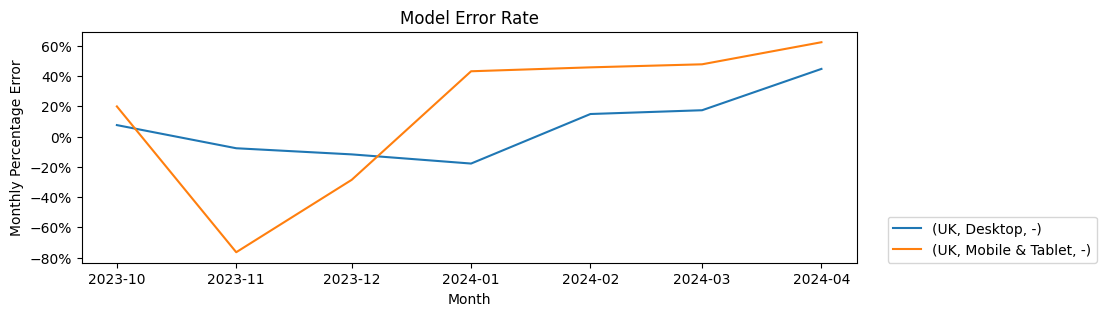

In [25]:
plot_printer = PlotAndSaveAccuracyDf()
fig = plot_printer.Plot(df_for_plt)
plot_name = "Accuracy_By_Month.jpg"
%load_ext autoreload
%autoreload 2

In [28]:
#fig.savefig(plot_name)
plot_printer.SaveToGCS(output_bucket,  plot_name, folder_name)

ups_bj_cost_by_device_optimization/UK/reg/jun_2024_upd_v2/Accuracy_By_Month.jpg
Image saved: ups_bj_cost_by_device_optimization/UK/reg/jun_2024_upd_v2/Accuracy_By_Month.jpg


In [40]:
# min_score = grid_competitor[(grid_competitor['account_type'] == 'Bing Ads')&(grid_competitor['funnel'] == 'Competitor')]['MAPE'].min()

# best_setting_df = grid_competitor[(grid_competitor['account_type'] == 'Bing Ads')&(grid_competitor['funnel'] == 'Competitor')\
#                                           &(grid_competitor['MAPE'] == min_score)]

In [22]:
# search_engine = ProphetParameterSearch()
# search_engine.add_power_params(num=5)
# df1, df2 = search_engine.search(cuts_df, df_filled)
# df2.to_csv('best_setting_df.csv')
# df1.to_csv('all_setting_result_acc_df.csv')  

In [23]:
# new_cuts_df = pd.read_csv('US Model Setting.csv')
# cuts_df_col_ls = ['market', 'account_type', 'funnel', 'starting_date', 'cutoff_month', 'periods', 'periods_for_acc_cal']
# new_cuts_df = new_cuts_df.merge(cuts_df[cuts_df_col_ls], how = 'left', on = ['market', 'account_type', 'funnel'])

# new_cuts_df.to_csv(config_dict['CLIENTINFO']['country'] + ' Breakdown.csv')
# generator = BreakdownSettingFileGenerator()
# new_cuts_df = generator.Generate(daily_df, config_dict, new_cuts_df)
# new_cuts_df = generator.Update()
# generator.SaveFile(bucket_name, folder_name, 'cuts_df.csv')
# new_cuts_df

In [24]:
# new_cuts_df.to_csv('cuts_df.csv')

In [42]:
# calculator = AccuracyCalculator()
# accuracy_df = calculator.CalculateAccuracy(new_cuts_df, df, query_item_list)
# # %load_ext autoreload
# # %autoreload 2
# calculator.SaveFile(bucket_name, folder_name, 'Finalized Model Score.csv')
# accuracy_df

In [58]:
# import json
# param_search_dict = {'power': 5,
#                      'growth': ['linear', 'logistic', 'power'],
#                     'seasonality_mode': ['additive', 'multiplicative'],
#                     'input_mode': ['additive', 'multiplicative'],
#                     'include_holiday': ['NA', 'Custom', 'Default'],
#                     'weekday_or_weekend': ['NA', 'additive', 'multiplicative'],
#                     'covid_year_exclude': ['Exclude', 'na'],
#                     'covid_year_dummy': ['NA', 'additive', 'multiplicative'],
#                     'anomaly_2021':['NA', 'additive', 'multiplicative'],
#                     }
# with open("param serach.json", "w") as outfile:
#     json.dump(param_search_dict, outfile)

In [59]:
# param_search_f = open("param serach.json")
# param_search_dict = json.load(param_search_f)
# power_number = int(param_search_dict['power']) 
# param_search_dict = {k: v for i, (k, v) in enumerate(param_search_dict.items()) if i > 1}
# power_number, param_search_dict

In [60]:
# import itertools
# list(itertools.product(*param_search_dict.values()))
# list(param_search_dict.keys())

# Model Generator

In [16]:
# %load_ext autoreload
# %autoreload 2
# model_generator = GenerateModelFile()
# model_generator.Generate(cuts_df, df_filled, query_item_list, output_bucket, folder_name)

# %load_ext autoreload
# %autoreload 
model_generator = GenerateModelFile()
model_generator.Generate(cuts_df, df_filled , query_item_list, output_bucket, folder_name, base_path=base_path)

04:05:08 - cmdstanpy - INFO - Chain [1] start processing
04:05:08 - cmdstanpy - INFO - Chain [1] done processing
04:05:09 - cmdstanpy - INFO - Chain [1] start processing
04:05:10 - cmdstanpy - INFO - Chain [1] done processing


# Constraint Setting

In [32]:
bounds = cuts_df.copy()
bounds['MinWeight'] = 0.8
bounds['MaxWeight'] = 1.2
bounds

# %load_ext autoreload
# %autoreload 2
constraint_file_generator = ConstraintFileGenerator(config_dict, analytical_file_df)
constraint_file = constraint_file_generator.Generate(bounds)
constraint_file.loc[constraint_file['Month'].isin(['Nov']), 'MinWeight'] = 1.0
constraint_file.loc[constraint_file['Month'].isin(['Nov']), 'MaxWeight'] = 1.1
constraint_file_generator.SaveFile(output_bucket, folder_name, constraint_file_name)

Data Frame file saved


In [40]:
#constraint_file.to_csv('Constrain File.csv')
#constrain_file_generator.SaveFile(output_bucket, folder_name, 'Constraint File.csv')

In [19]:
df_filled[(df_filled.ds>='2024-01-01')&(df_filled.ds<='2024-01-10')].groupby(by='region').sum(numeric_only=1)

,X,y,weekday_or_weekend,floor,AOV,ROAS,cap
region,,,,,,,
Europe,34689.53,4788.0,4,0,451.8,28.3,2750.7392


In [25]:
cuts_df

,market,account_type,funnel,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,...,anomaly_2021,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,MAPE,period_AE,periods,cutoff_month
0,UK,Desktop,-,183,0.1,1.0,1.0,multiplicative,multiplicative,multiplicative,...,na,na,na,na,na,linear,13.72,3.89,251.0,2024-04-25
1,UK,Mobile & Tablet,-,183,0.1,10.0,10.0,multiplicative,multiplicative,multiplicative,...,na,na,na,na,na,linear,22.23,22.77,251.0,2024-04-25


In [29]:
# # cuts_df.loc[5, 'growth'] = 'linear'
# for i in cuts_df.itertuples():
#     pass

# import pickle
# from repo.Accuracy import MakeFuture
# file_name = "UK Mobile & Tablet -.pkl"
# pickle_file_path = base_path + file_name
# pickle_in = open(pickle_file_path,'rb') 
# # unpickled model is the model to use, training_dataset is used to get historical spend
# unpickled_model, training_dataset, model_df = pickle.load(pickle_in)

# analytical_file_copy = analytical_file_df.copy()
# market = 'UK'
# account_type = 'Mobile & Tablet'
# funnel = '-'

# spend_df_for_forecast = analytical_file_copy[(analytical_file_copy['market'] == market) & (analytical_file_copy['account_type'] == account_type) & \
#                                              (analytical_file_copy['funnel'] == funnel)].copy()
# spend_df_for_forecast['ds'] = pd.to_datetime(spend_df_for_forecast.ds)

# future = MakeFuture(unpickled_model, training_dataset, i, 183, spend_df_for_forecast)
# # print(training_dataset.ds.max(), i)
# forecast = unpickled_model.predict(future)
# unpickled_model.plot_components(forecast)

# from prophet.plot import plot_plotly, plot_components_plotly

# plot_plotly(unpickled_model, forecast)